$(0,1)$ differences may occur locally for instances with $10.4 < LSTAT < 14.9, 12 < INDUS < 23, CRIM < 5, RM > 4.8$
- Differences: $11.1 < LSTAT < 14.2, 2.1 < DIS < 3.2, ZN=0$ (3 instances)
- L: $10.5 < LSTAT, ZN ≤12.5, 4 < INDUS, RM < 6.9$
    - CF: $LSTAT≤10.4 \rightarrow (1,1)$
    - LR: $LSTAT < 20.7 \rightarrow (0,0)$
        - CF: $LSTAT≥14.9 \rightarrow (0,0)$
        - CF: $INDUS≥23 \rightarrow (0,0)$
        - CF: $INDUS≤12 \rightarrow (1,1)$
        - CF: $CRIM≥5 \rightarrow (0,0)$
        - CF: $RM≤4.8 \rightarrow (0,0)$

$(1,0)$ differences may occur locally for instances with $16.3 < LSTAT < 16.8, CRIM < 2, 288 < TAX < 327, 7.1 < INDUS < 9.2$
- Differences: $16.4 < LSTAT < 16.6, ZN=0, INDUS=8.14$
- L: $RM < 7.3$
    - CF: $CRIM≥2 \rightarrow (0,0)$
    - CF: $TAX≥327 \rightarrow (1,1)$
    - CF: $TAX≤288 \rightarrow (0,0)$
    - CF: $INDUS≥9.2 \rightarrow (0,0)$
    - CF: $INDUS≤7.1 \rightarrow (1,1)$
    - LR: $LSTAT < 21.9$
        - CF: $LSTAT≤16.3 \rightarrow (1,1)$
        - CF: $LSTAT≥16.8 \rightarrow (0,0)$

$(1,2)$ differences may occur locally for instances with $3.5 < LSTAT < 11.6, ZN > 16, INDUS < 17$
- Differences: $5.4 < LSTAT < 9.6, 20 ≤ ZN, INDUS < 4.2, CRIM < 0.6$
- R: $LSTAT ≤ 14.8$
    - CF: $LSTAT≤3.5 \rightarrow (2,2)$
    - CF: $LSTAT≥11.6 \rightarrow (1,1)$
    - CF: $INDUS≥17 \rightarrow (1,1)$
    - CF: $ZN≤16 \rightarrow (1,1)$

$(2,1)$ differences may occur locally for instances with $6.0 < LSTAT < 7.4, ZN < 19, 9.8 < INDUS < 19.7$
- Differences: $6.4 < LSTAT < 7.2, ZN=0, 11.9 < INDUS ≤ 18.1$
- L: $LSTAT < 10.9$
    - CF: $LSTAT≤6.0 \rightarrow (2,2)$
    - CF: $LSTAT≥7.4 \rightarrow (1,1)$
    - CF: $ZN≥19 \rightarrow (2,2)$
    - CF: $INDUS≤9.8 \rightarrow (2,2)$
    - CF: $INDUS≥19.7 \rightarrow (1,1)$

In [17]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from comparers import ModelComparer
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances,\
                       estimate_feature_interaction_order
from clustering import make_clustering, plot_dendrogram
from tasks.boston_housing import make_task4 as make_task
import matplotlib.pyplot as plt
from IPython.display import display
import shap
shap.initjs()

In [2]:
try:
    with open('shap.expl', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer = pickle.load(f)
    global_feature_order, _ = calc_feature_order(explanations.mclass_diff.log_odds)
except FileNotFoundError:
    pass

# Setup Task

In [3]:
categorical_features = ['AGE']

In [4]:
clf_a, clf_b, X, y, feature_names = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


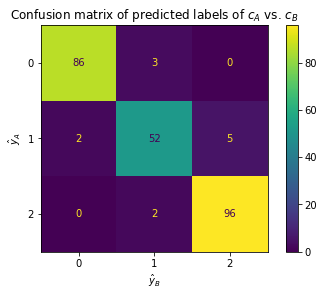

In [5]:
comparer.plot_confusion_matrix(X)

In [6]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker, algorithm='exact',
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])
with open('shap.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer),
                f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 247it [01:44,  2.23it/s]                         
Exact explainer: 247it [01:39,  2.22it/s]                         
Exact explainer: 247it [07:25,  1.86s/it]                         

CPU times: user 12min 7s, sys: 2min 13s, total: 14min 20s
Wall time: 10min 50s


As we can see, no instances had infinite log-space predictions and no instances had infinite SHAP values:

In [7]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((246, 11), (0,), (0,))

# Traditional SHAP Explanations

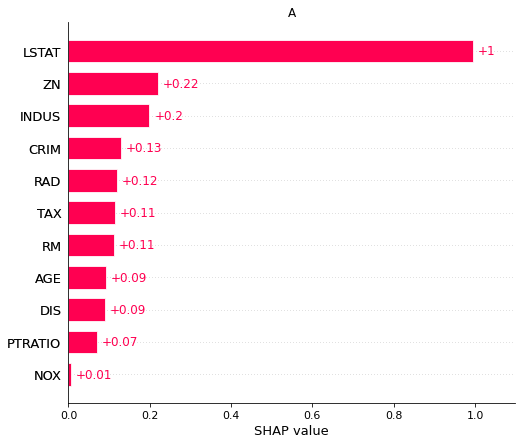

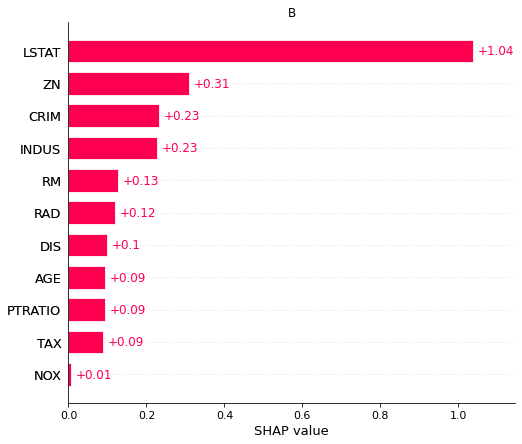

In [2]:
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.A)
plot_feature_importance_bar(feature_importances, 'A')
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.B)
plot_feature_importance_bar(feature_importances, 'B')

In [3]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds)
feature_order = feature_order[:-1]

In [4]:
node, Z = make_clustering(comparer, explanations.indiv.log_odds, categorical_features=categorical_features)

root
(2, 2)    96
(0, 0)    86
(1, 1)    52
(1, 2)     5
(0, 1)     3
(1, 0)     2
(2, 1)     2
dtype: int64


In [5]:
feature_it = iter(feature_order)

In [6]:
def plot_next_feature():
    feature = next(feature_it)
    for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
        node.plot_feature(feature, classes=list(classes), alpha=0.5)

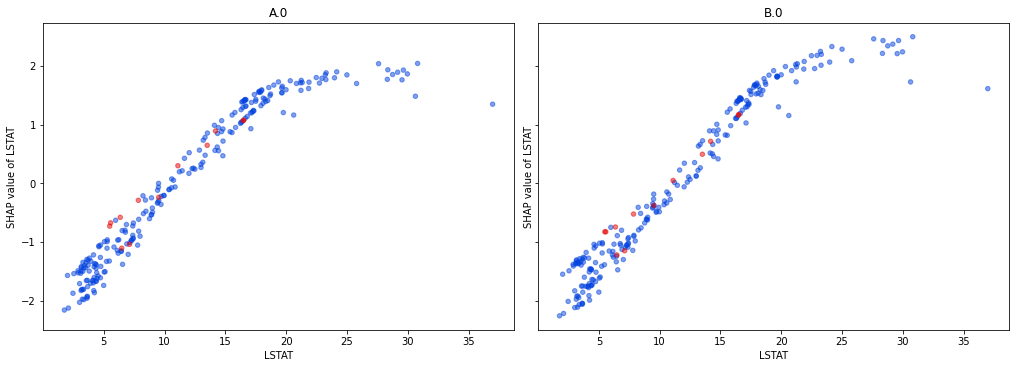

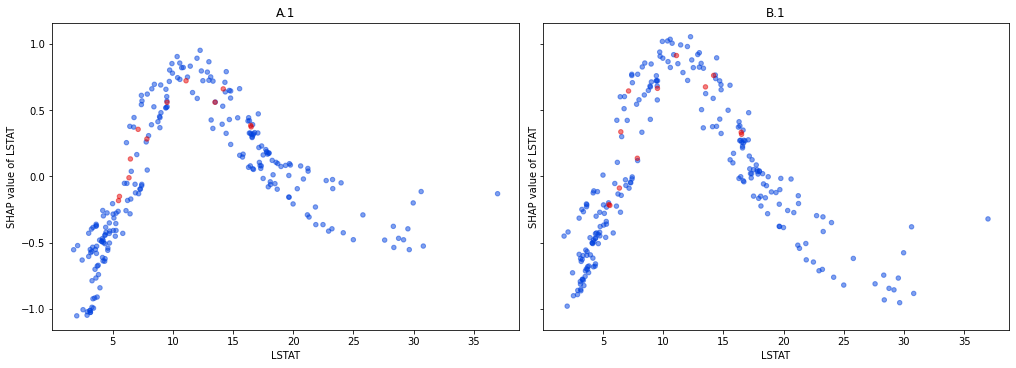

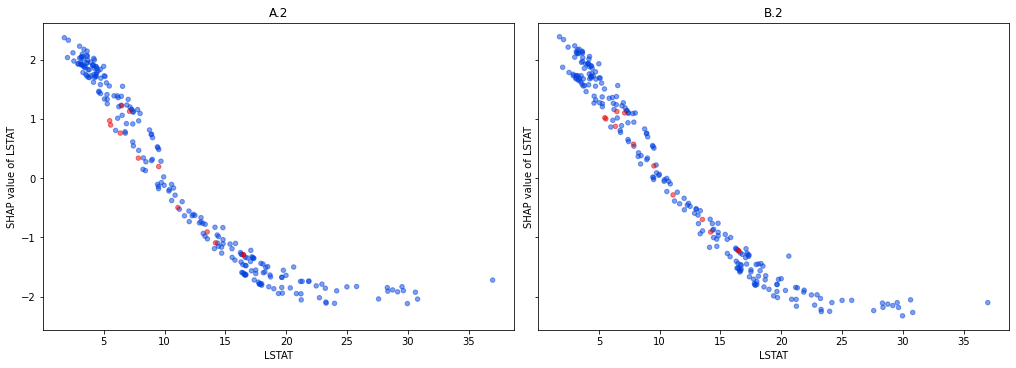

In [7]:
plot_next_feature()

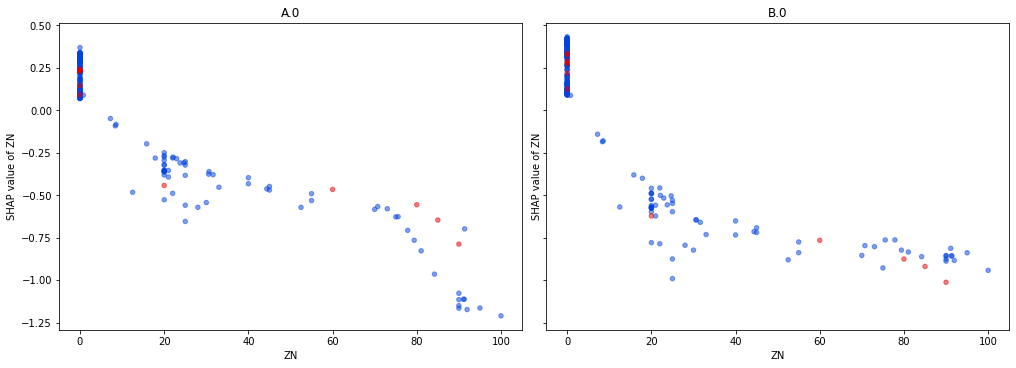

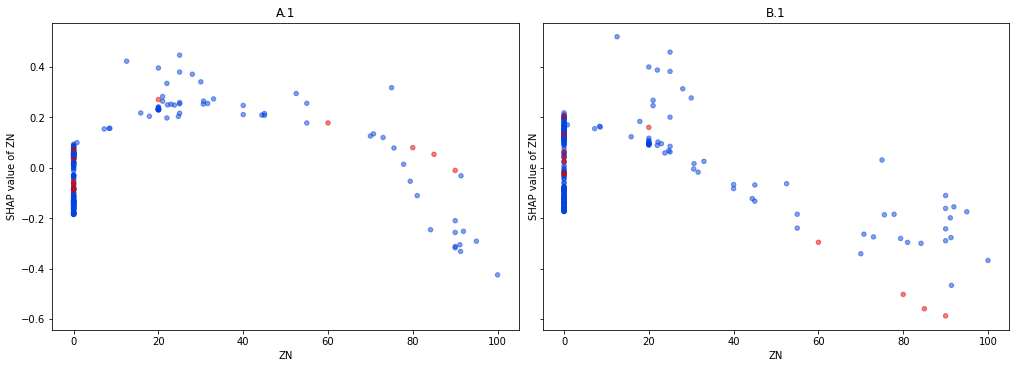

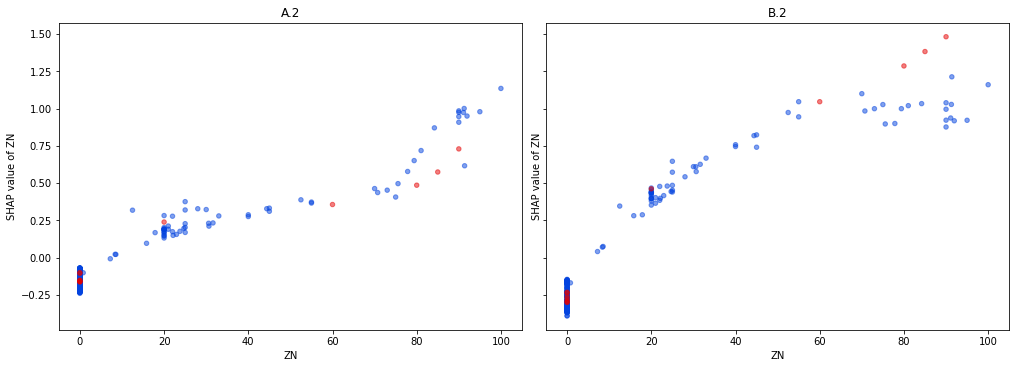

In [8]:
plot_next_feature()

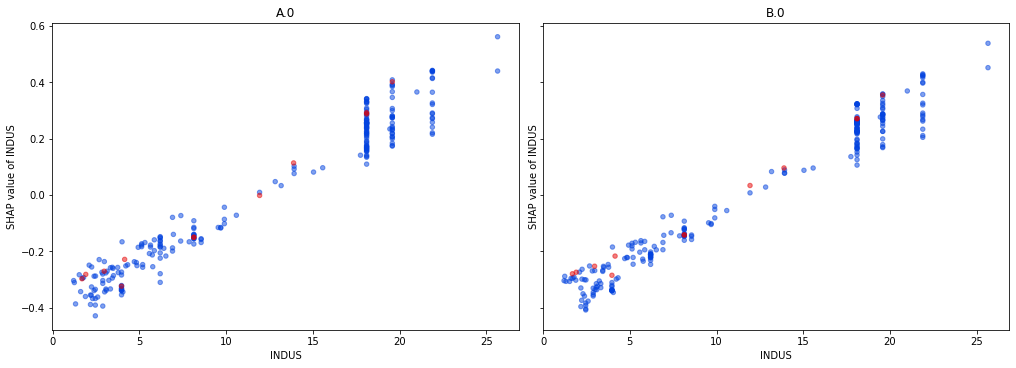

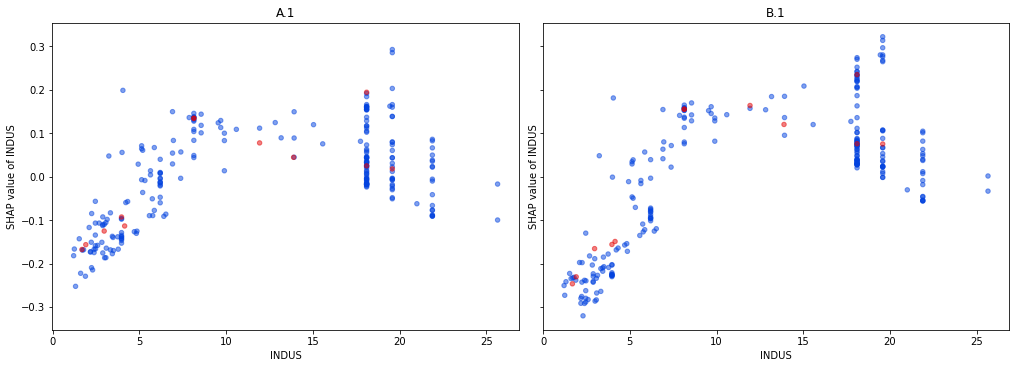

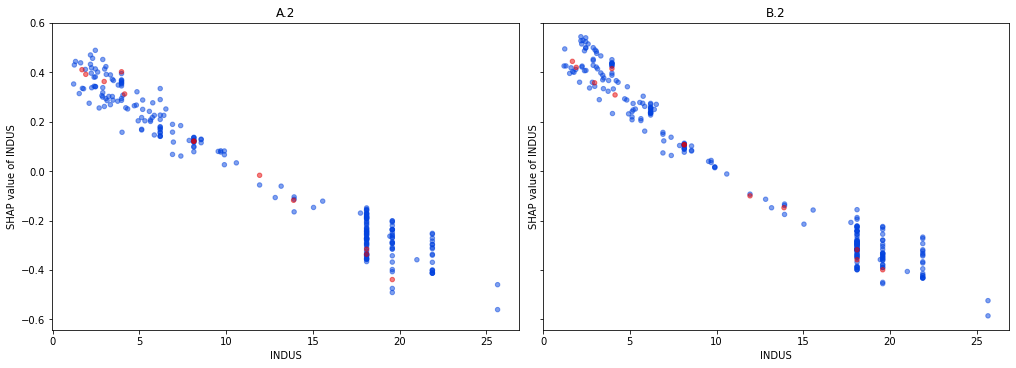

In [9]:
plot_next_feature()

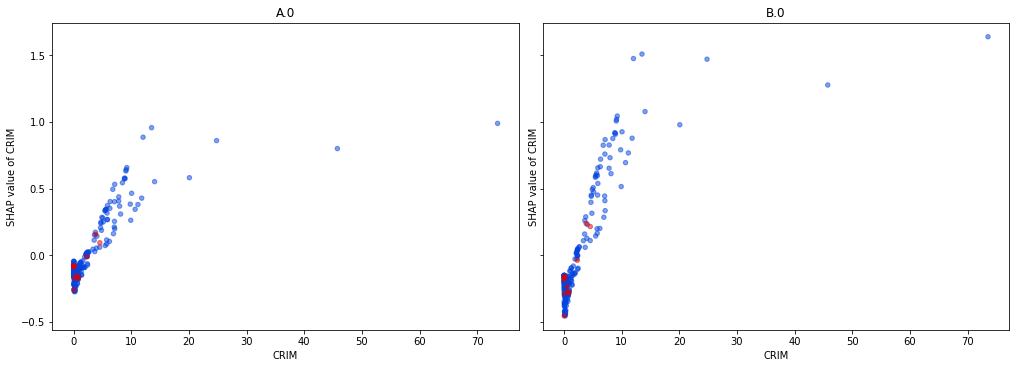

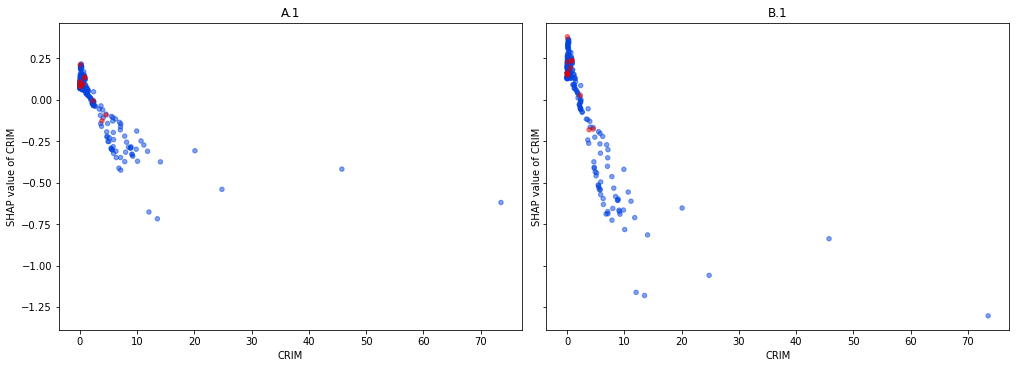

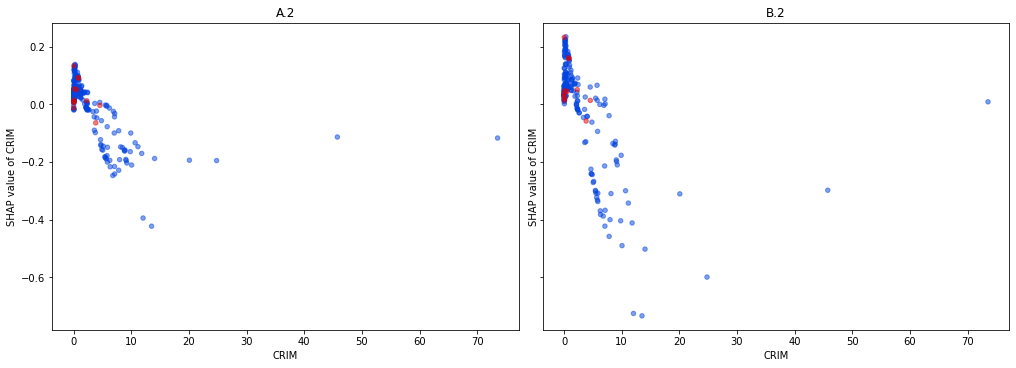

In [10]:
plot_next_feature()

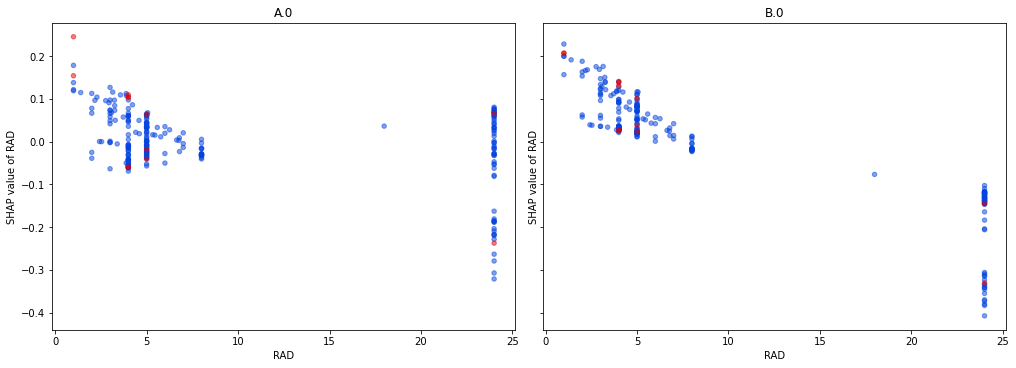

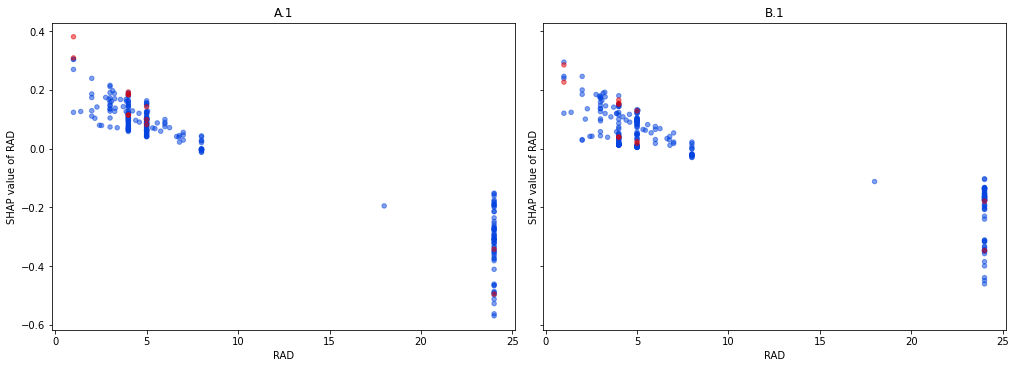

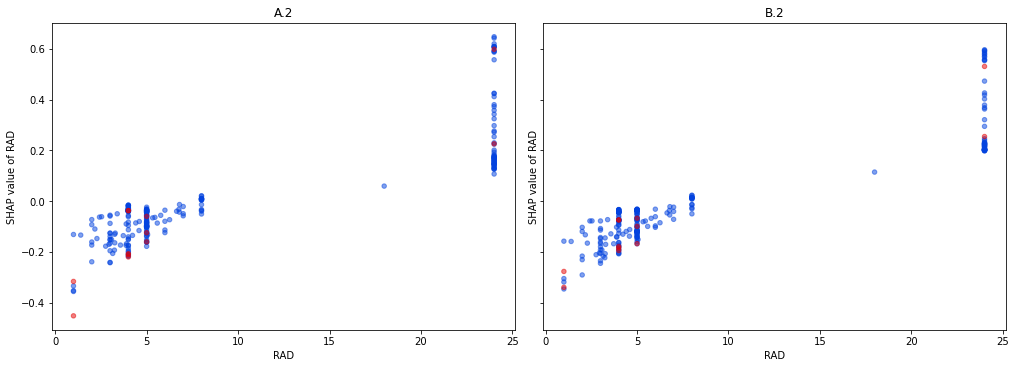

In [11]:
plot_next_feature()

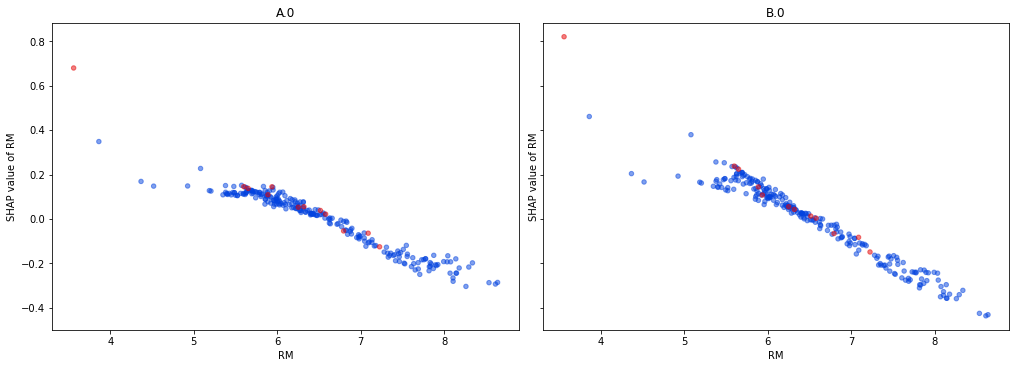

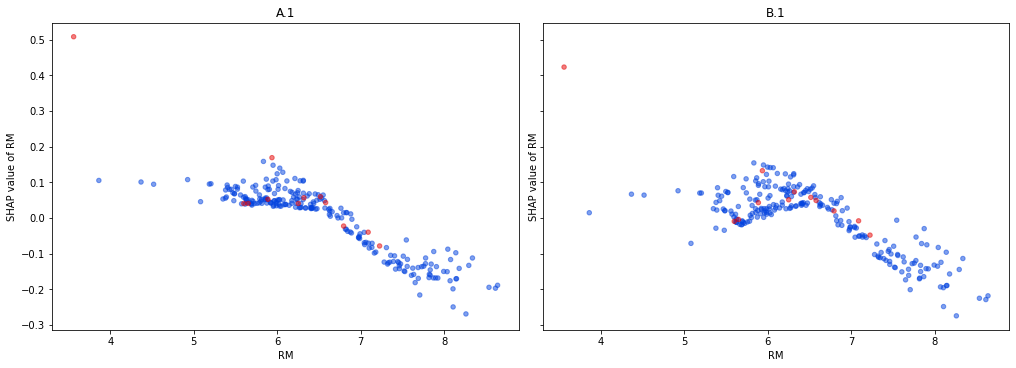

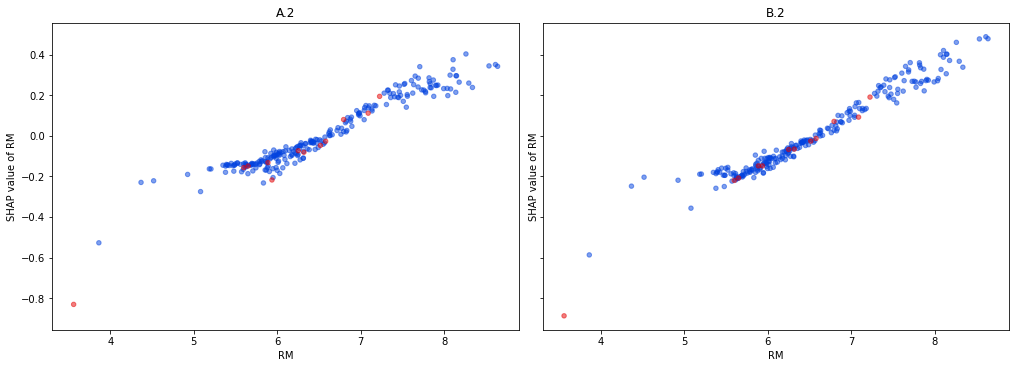

In [12]:
plot_next_feature()

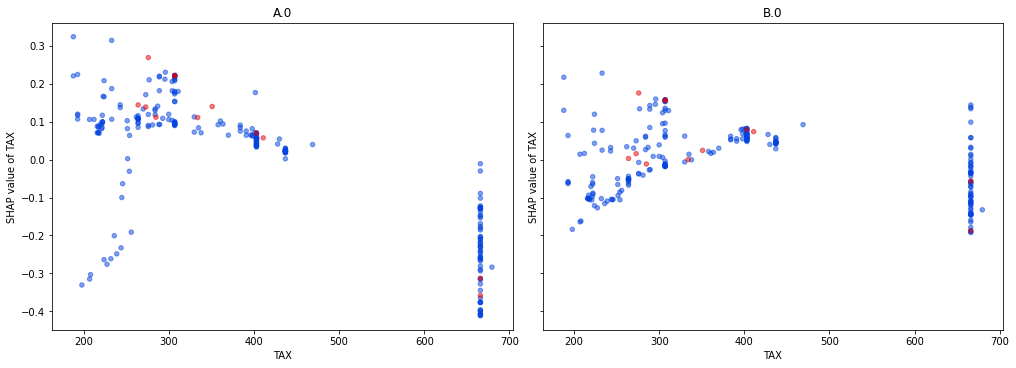

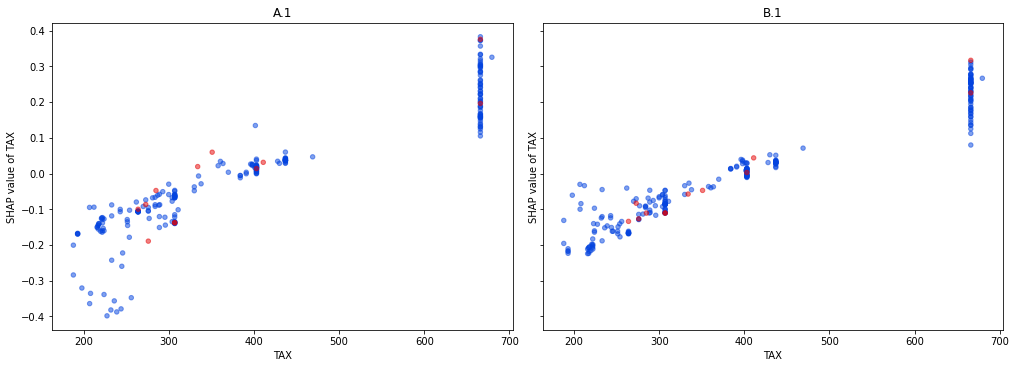

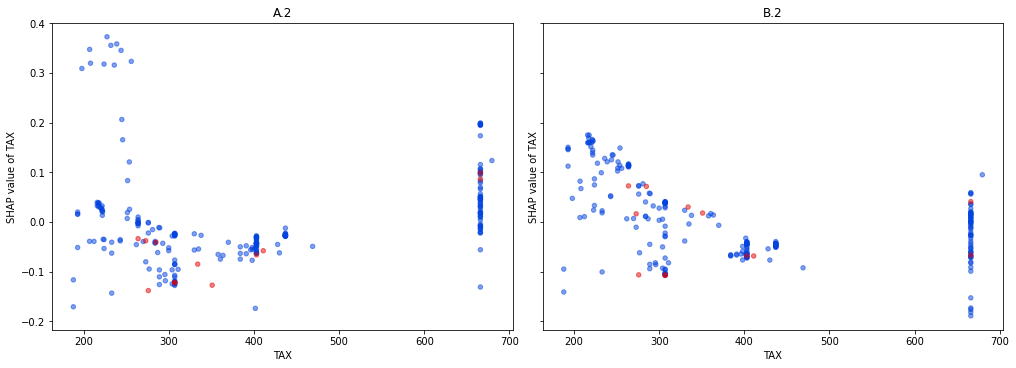

In [13]:
plot_next_feature()

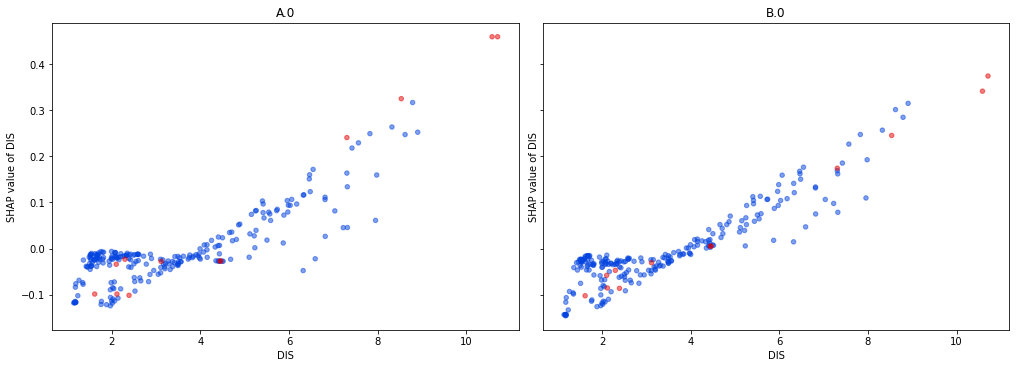

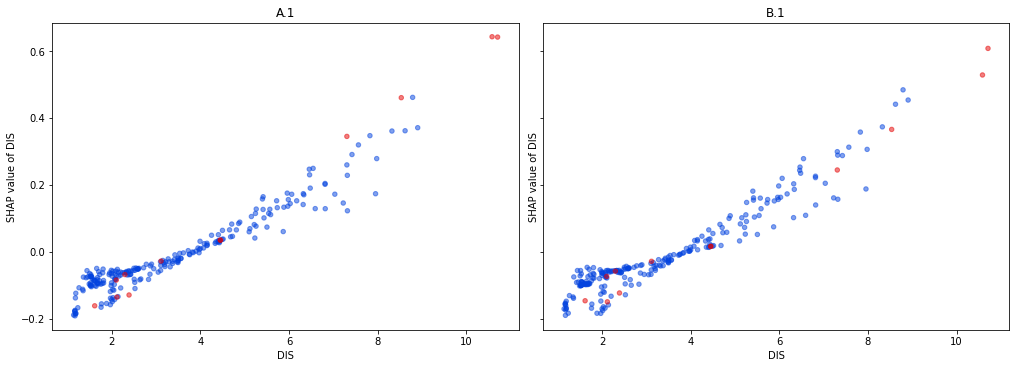

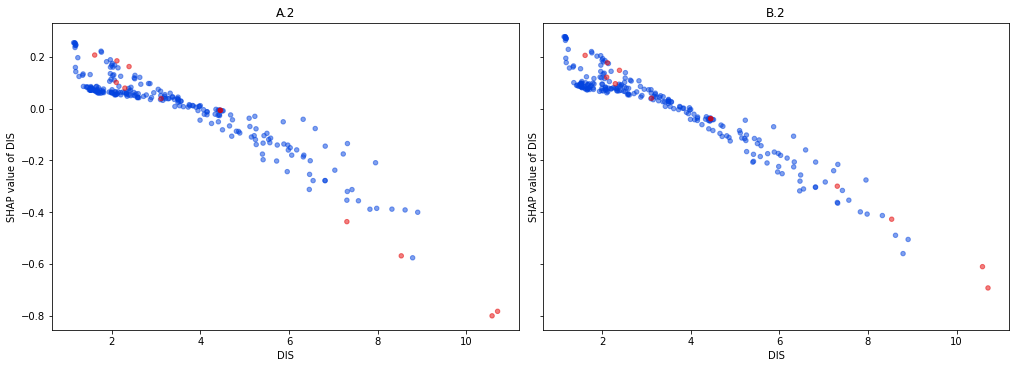

In [14]:
plot_next_feature()

The vertical spread in the dependence plots of DIS suggests that interactions are present, but more important it looks like the interactions cause different DIS effects.

The SHAP package can estimate interactions based on correlation.

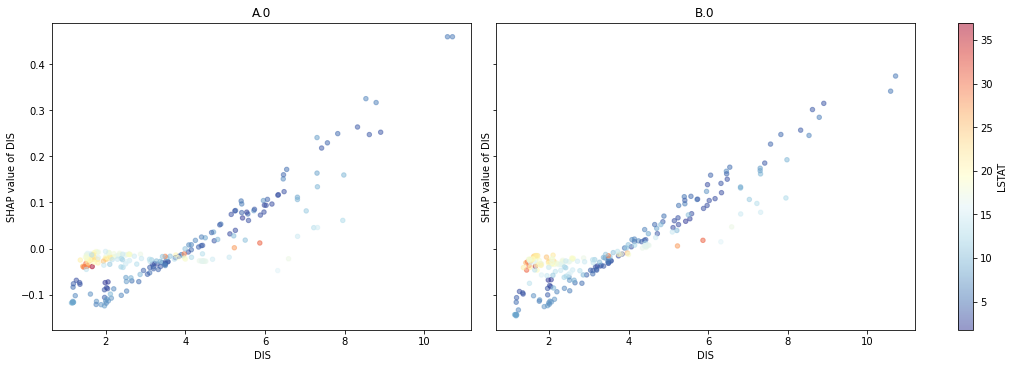

In [9]:
feature_interaction_order = estimate_feature_interaction_order(node.shap_values[:, :, 0].A, 'DIS')
node.plot_feature('DIS', classes=['A.0', 'B.0'], alpha=0.5, color=int(feature_interaction_order[0]))

The strongest interactions are with feature LSTAT, clearly instances with medium to high LSTAT values yield different effects of feature DIS than with low values.

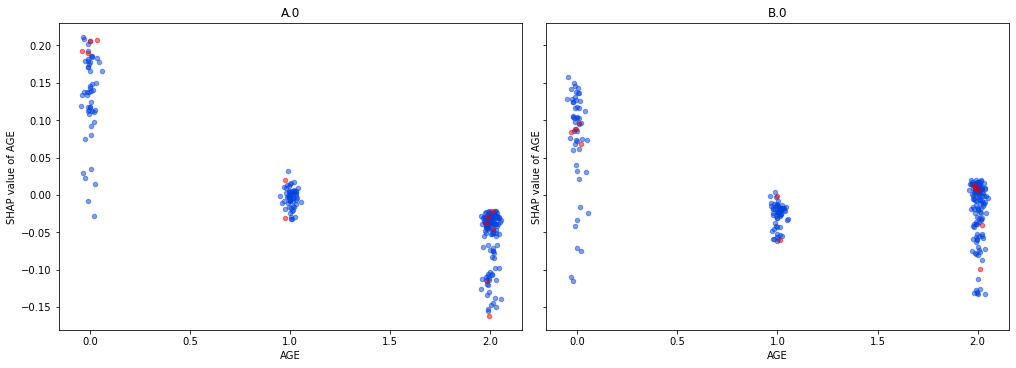

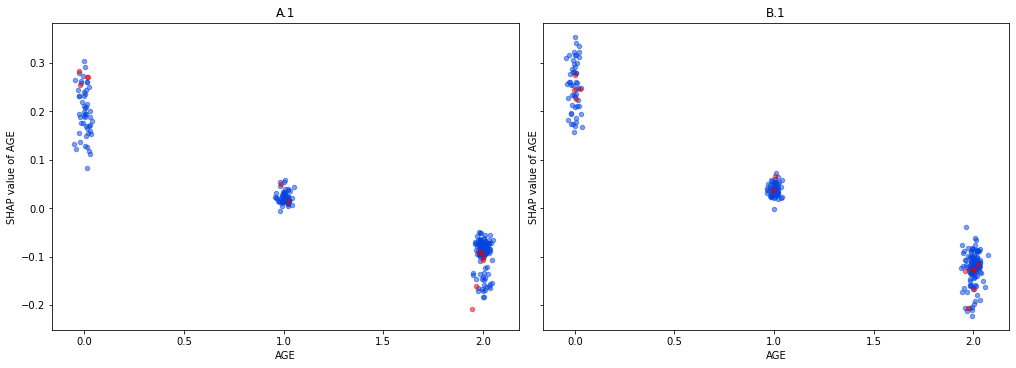

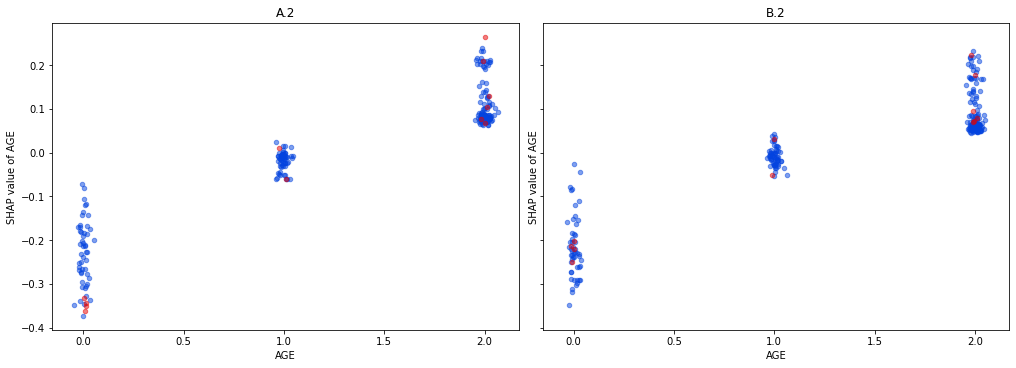

In [21]:
plot_next_feature()

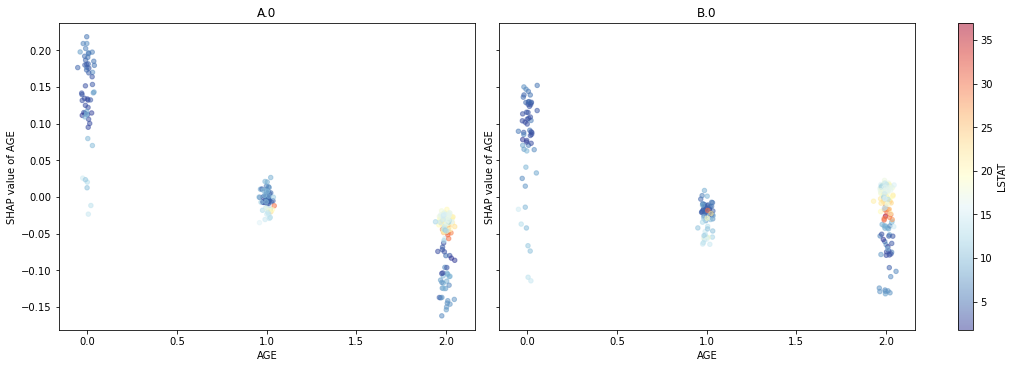

In [11]:
feature_interaction_order = estimate_feature_interaction_order(node.shap_values[:, :, 0].B, 'AGE')
node.plot_feature('AGE', classes=['A.0', 'B.0'], alpha=0.5, color=int(feature_interaction_order[0]))

For AGE too, LSTAT mainly accounts for the vertical spread.

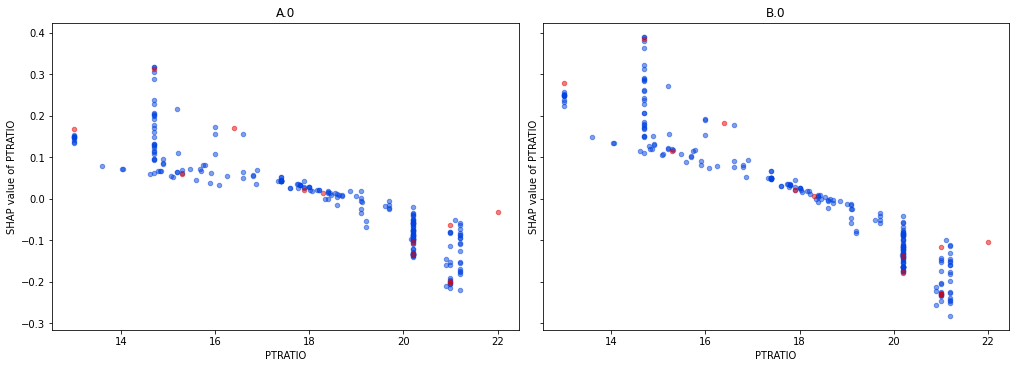

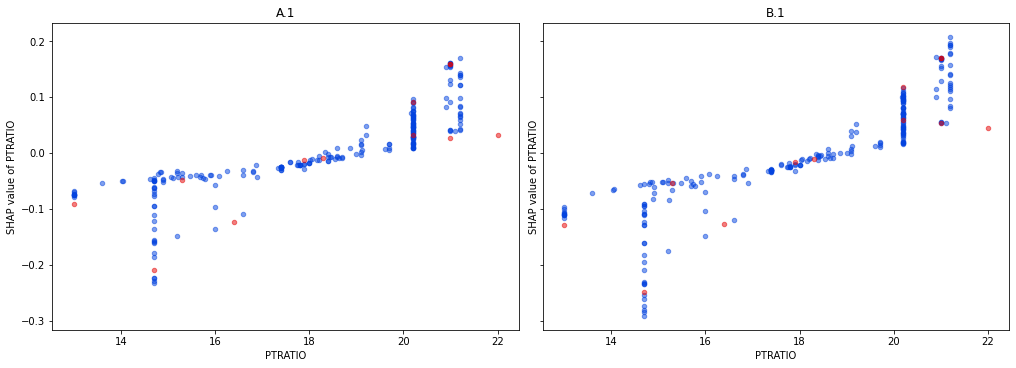

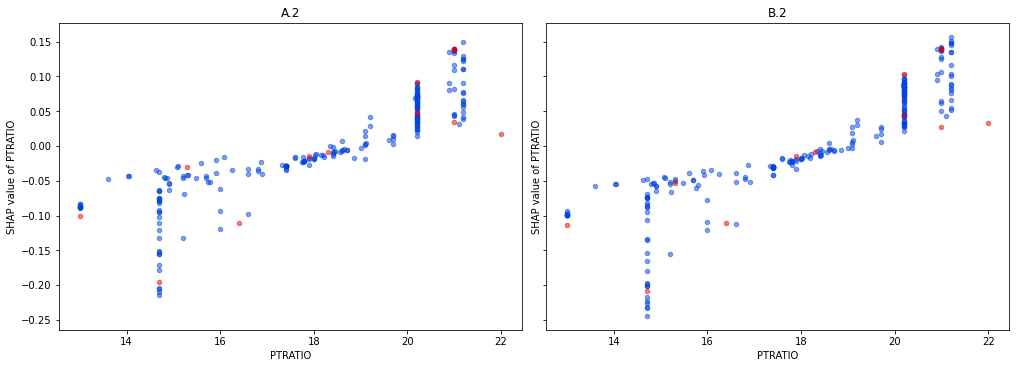

In [22]:
plot_next_feature()

# Difference Classifier SHAP Explanations

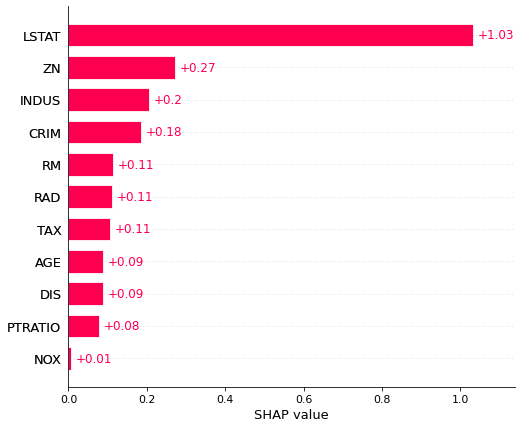

In [10]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.log_odds)
plot_feature_importance_bar(feature_importances)

In [11]:
feature_order = feature_order[:-1]
global_feature_order = feature_order

The equality classes (0,0) and (2,2) have the highest mean absolute SHAP value, which means that the influences to and from these classes are highest. 

(0,2) and (2,0) have the least importances.

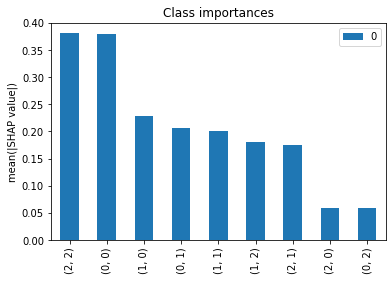

In [12]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [13]:
class_order = np.sort(class_order[:-2])

## Clustering of Class $(0,1)$ SHAP Values

In [14]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds, '(0, 1)', ['(0, 0)', '(0, 1)', '(1, 1)'],
                          categorical_features=categorical_features)

root
(2, 2)    96
(0, 0)    86
(1, 1)    52
(1, 2)     5
(0, 1)     3
(2, 1)     2
(1, 0)     2
dtype: int64


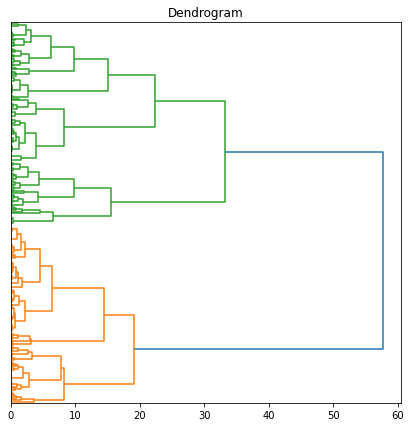

In [15]:
plot_dendrogram(Z)

### Root Node

It's hard to spot, but telling from LSTAT (the most important feature) and DIS, the $(0,1)$ differences could be of local nature.

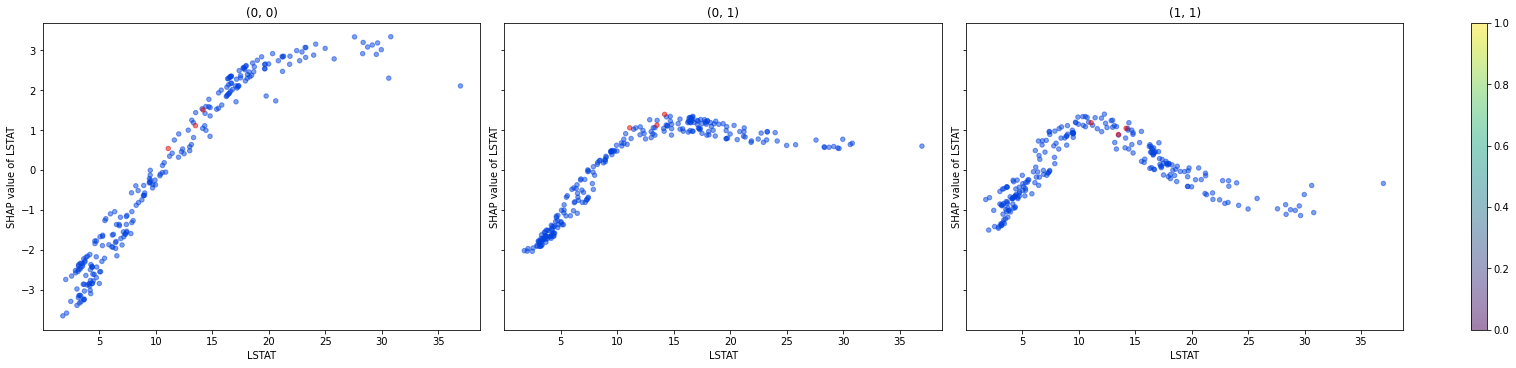

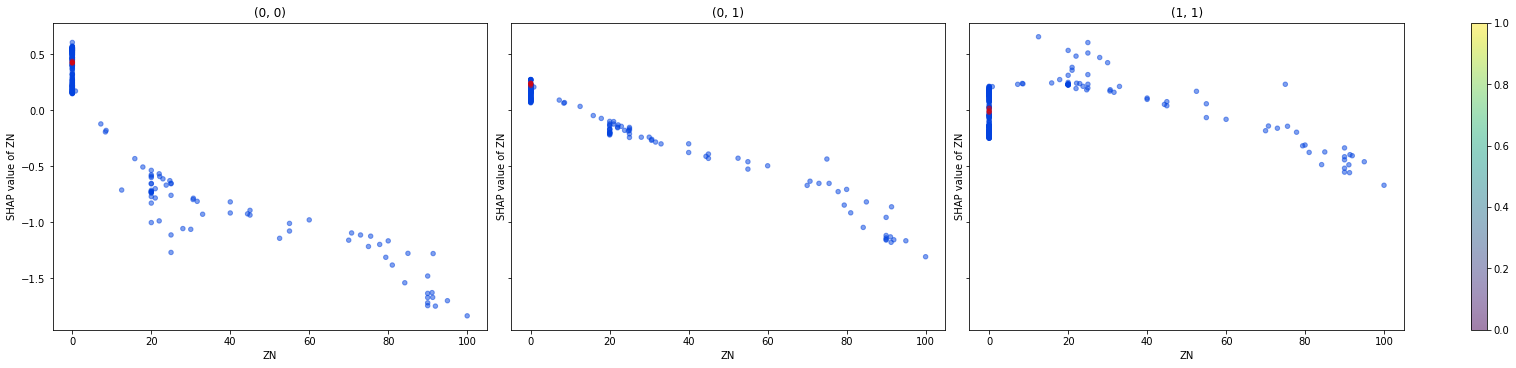

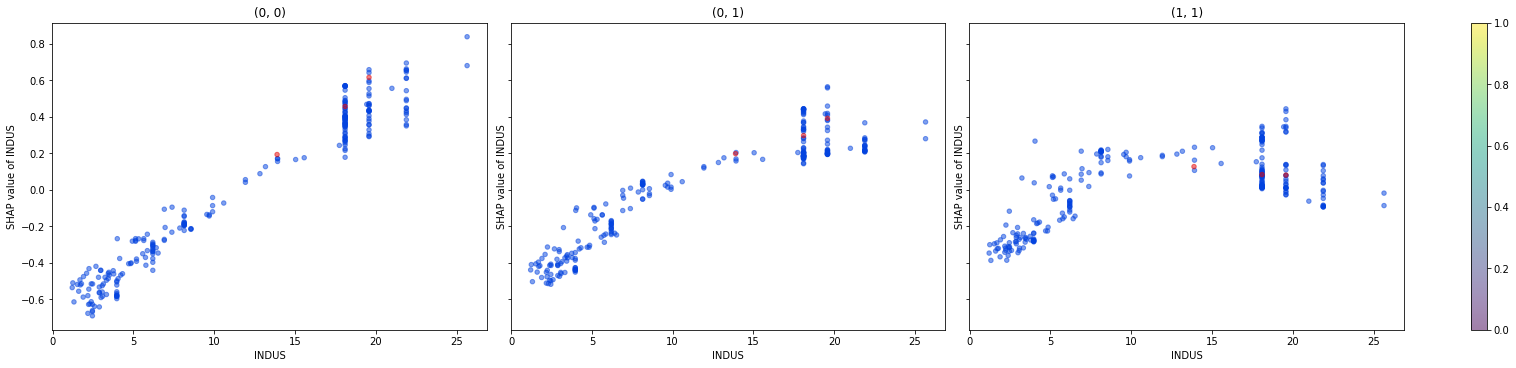

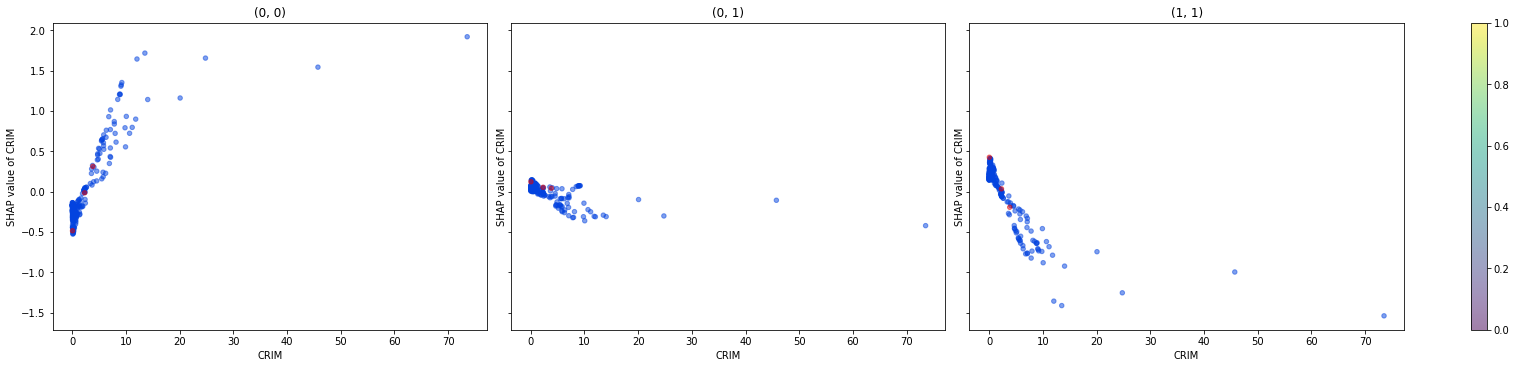

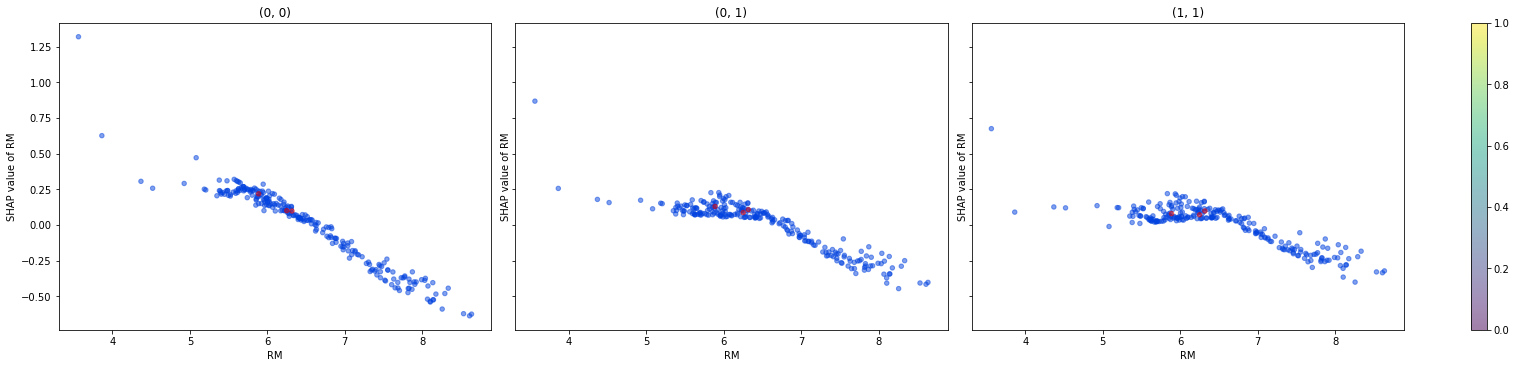

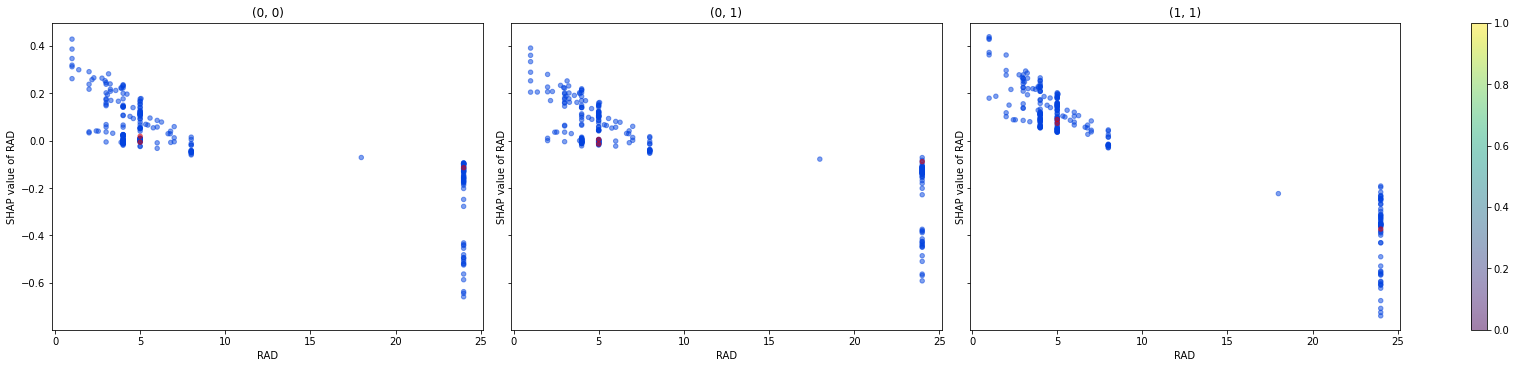

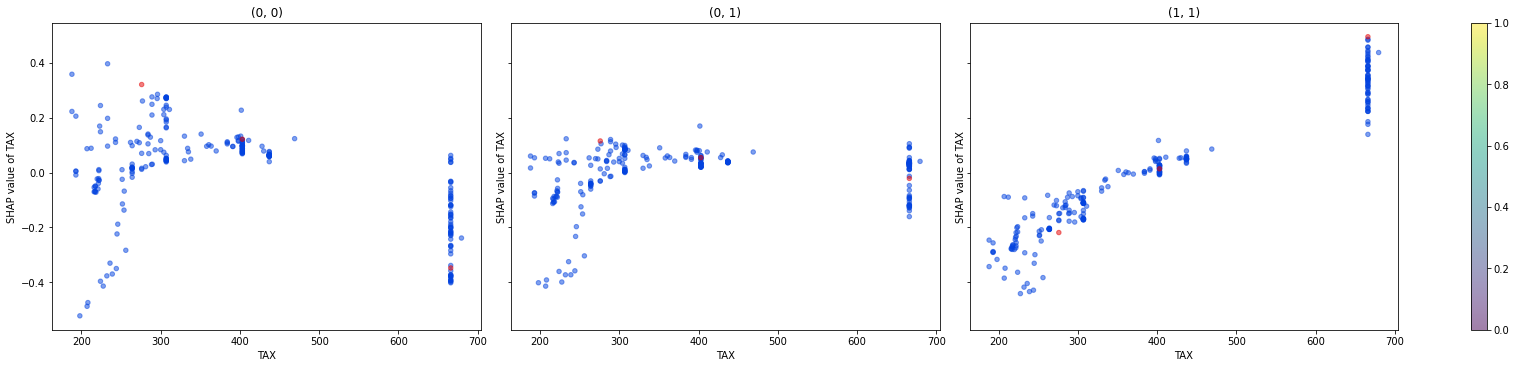

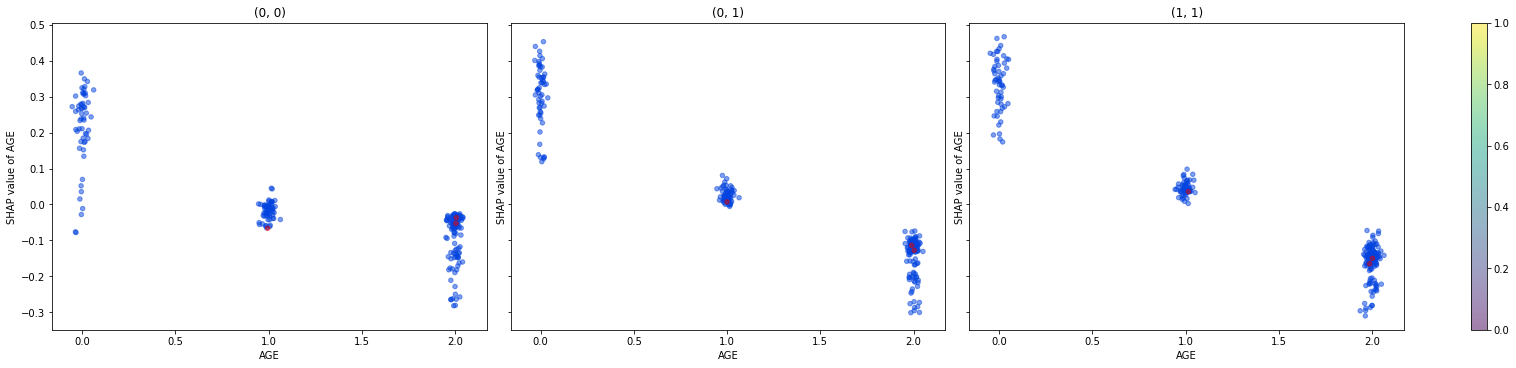

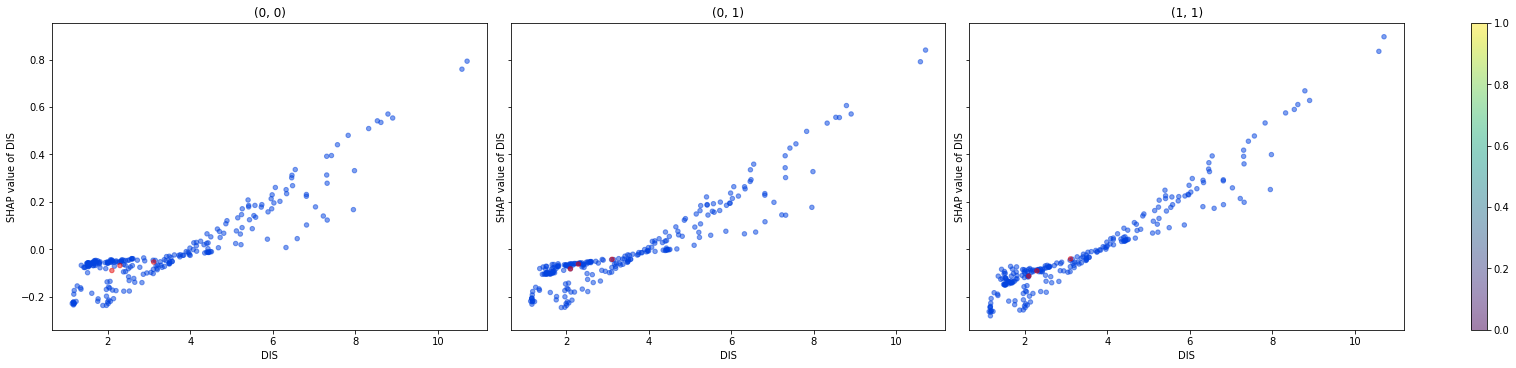

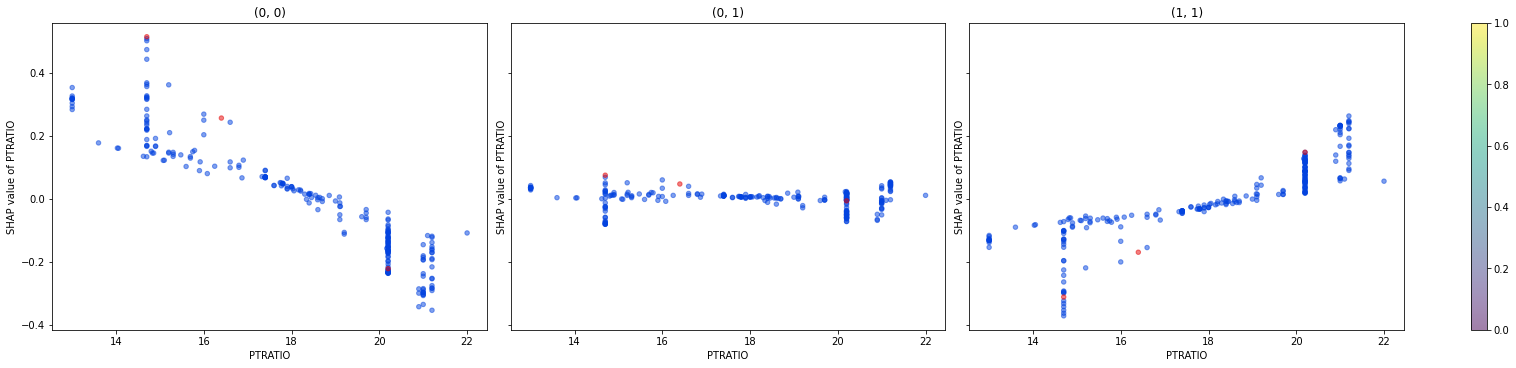

In [16]:
for feature in global_feature_order:
    node.plot_feature(feature, alpha=0.5)

In [9]:
node.describe_feature('LSTAT')

global   local-all  local-diff
count  246.000000  246.000000    3.000000
mean    11.736981   11.736981   12.933333
std      7.372550    7.372550    1.623710
min      1.763949    1.763949   11.100000
25%      5.008267    5.008267   12.305000
50%      9.950000    9.950000   13.510000
75%     17.091674   17.091674   13.850000
max     36.980000   36.980000   14.190000

In [10]:
node.describe_feature('DIS')

global   local-all  local-diff
count  246.000000  246.000000    3.000000
mean     3.501706    3.501706    2.502533
std      2.007156    2.007156    0.536874
min      1.137912    1.137912    2.100000
25%      1.967365    1.967365    2.197750
50%      2.866600    2.866600    2.295500
75%      4.621654    4.621654    2.703800
max     10.710300   10.710300    3.112100

In [11]:
node.describe_feature('ZN')

global   local-all  local-diff
count  246.000000  246.000000         3.0
mean    12.841063   12.841063         0.0
std     25.552540   25.552540         0.0
min      0.000000    0.000000         0.0
25%      0.000000    0.000000         0.0
50%      0.000000    0.000000         0.0
75%     20.000000   20.000000         0.0
max    100.000000  100.000000         0.0

In [12]:
node.describe_feature('RM')

global   local-all  local-diff
count  246.000000  246.000000    3.000000
mean     6.511388    6.511388    6.152667
std      0.889747    0.889747    0.231716
min      3.561000    3.561000    5.888000
25%      5.882000    5.882000    6.069500
50%      6.315500    6.315500    6.251000
75%      7.134552    7.134552    6.285000
max      8.638029    8.638029    6.319000

In [13]:
node.describe_feature('AGE')

0.0   1.0    2.0
global      55.0  61.0  130.0
local-all   55.0  61.0  130.0
local-diff   NaN   1.0    2.0

### Node L

In [14]:
node = node.get_left()

L
(0, 0)    86
(1, 1)    24
(0, 1)     3
(1, 0)     2
dtype: int64


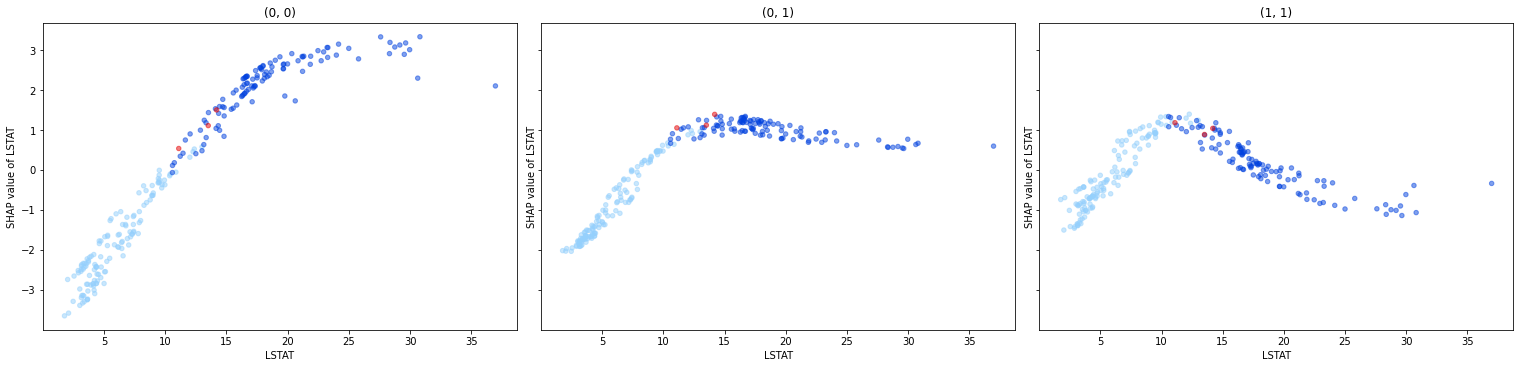

In [15]:
node.parent.plot_feature('LSTAT', focus=node, alpha=0.5)

In [16]:
node.describe_feature('LSTAT')

global   local-all  local-diff
count  246.000000  115.000000    3.000000
mean    11.736981   18.400582   12.933333
std      7.372550    5.028417    1.623710
min      1.763949   10.580000   11.100000
25%      5.008267   15.100000   12.305000
50%      9.950000   17.310000   13.510000
75%     17.091674   20.480000   13.850000
max     36.980000   36.980000   14.190000

In [17]:
node.test(LSTAT=10.4)

before  after
(0, 1)     3.0    NaN
(1, 1)     NaN    3.0

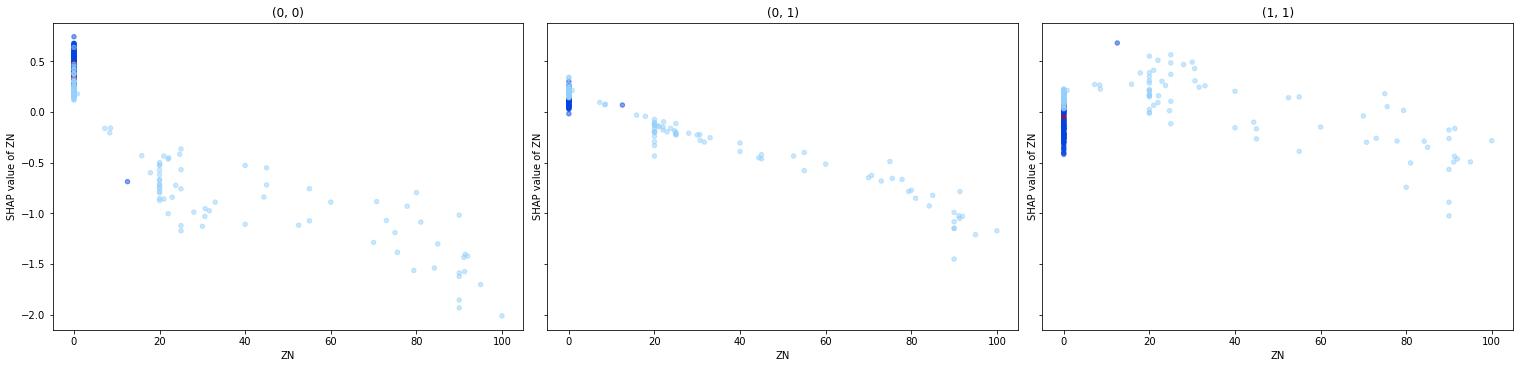

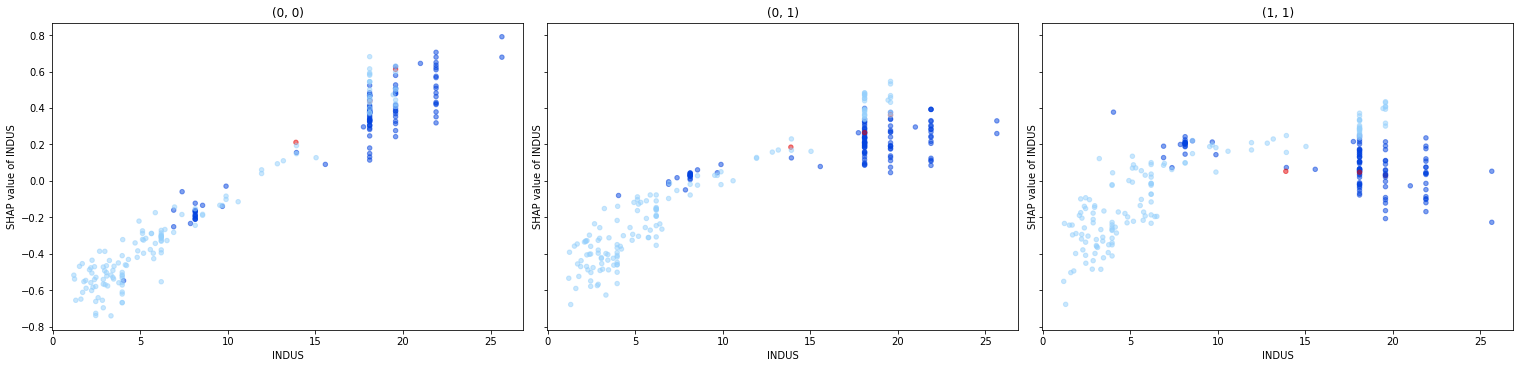

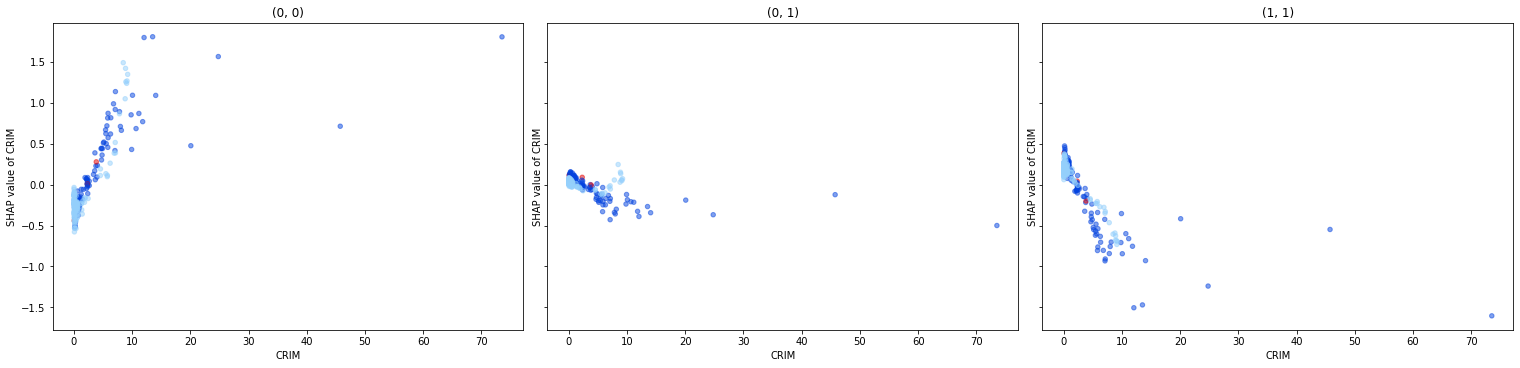

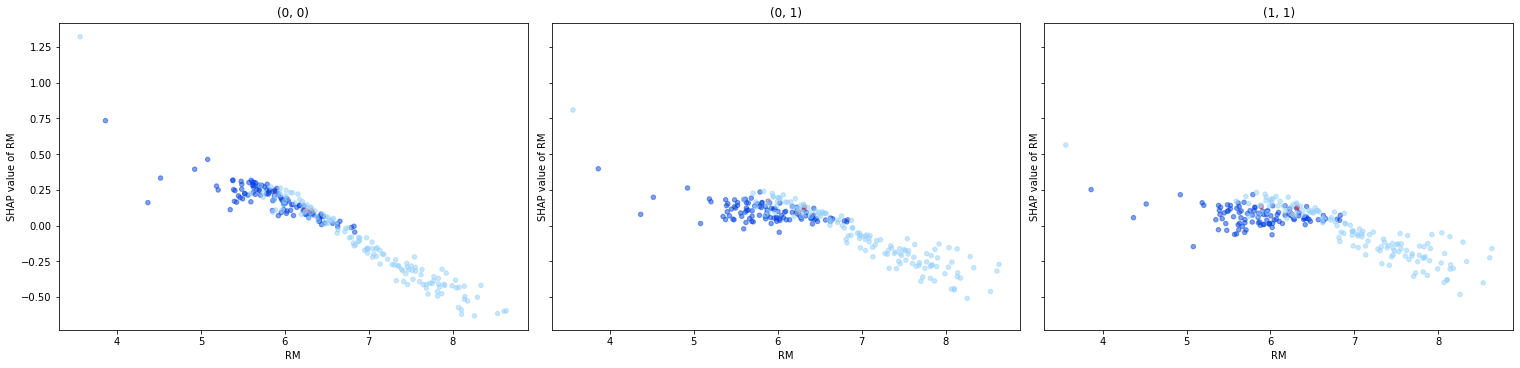

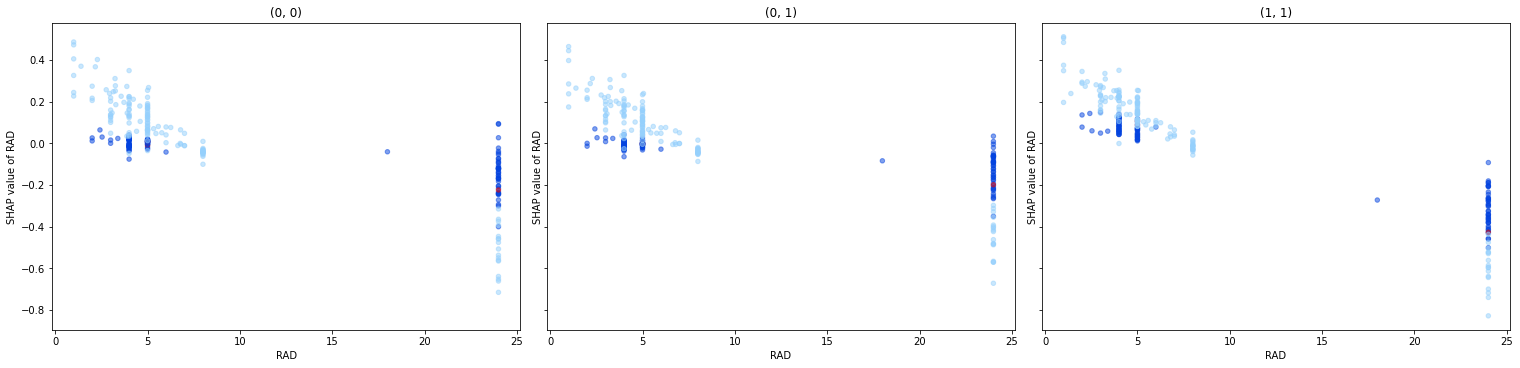

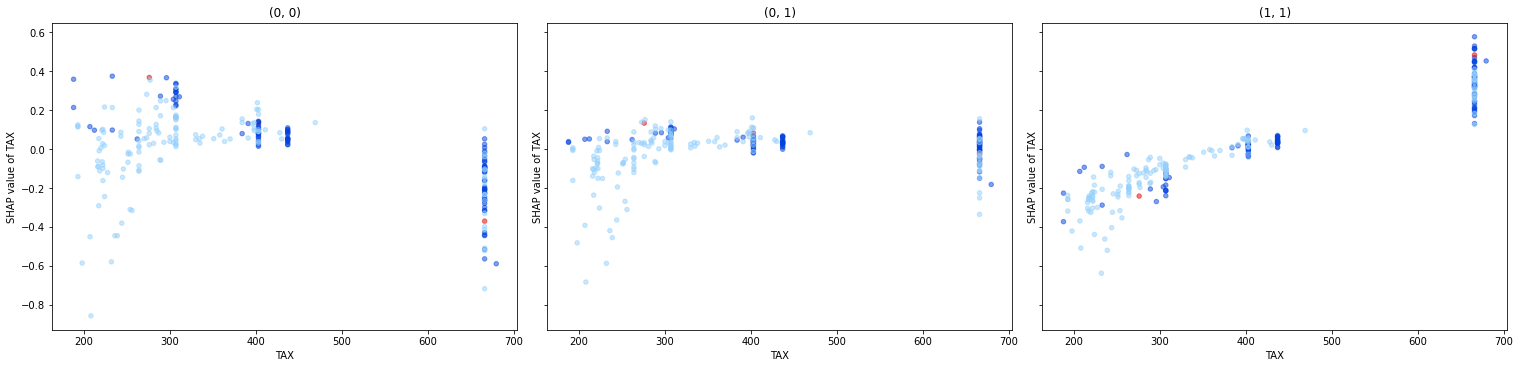

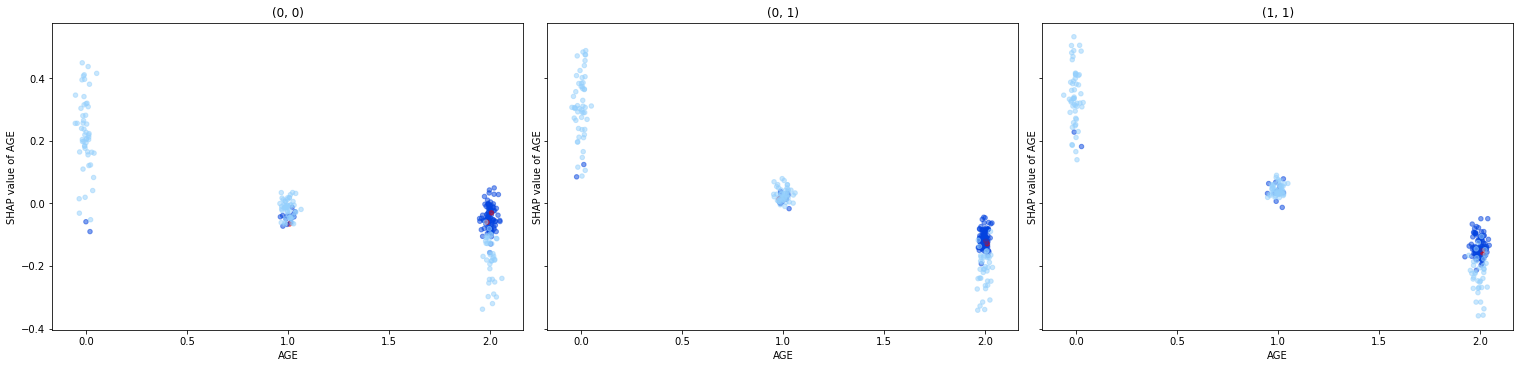

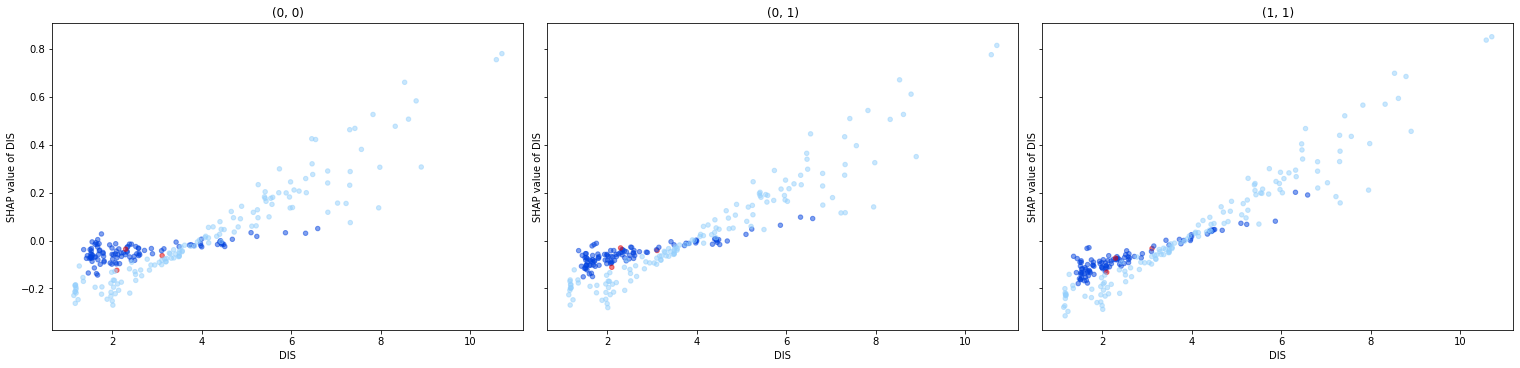

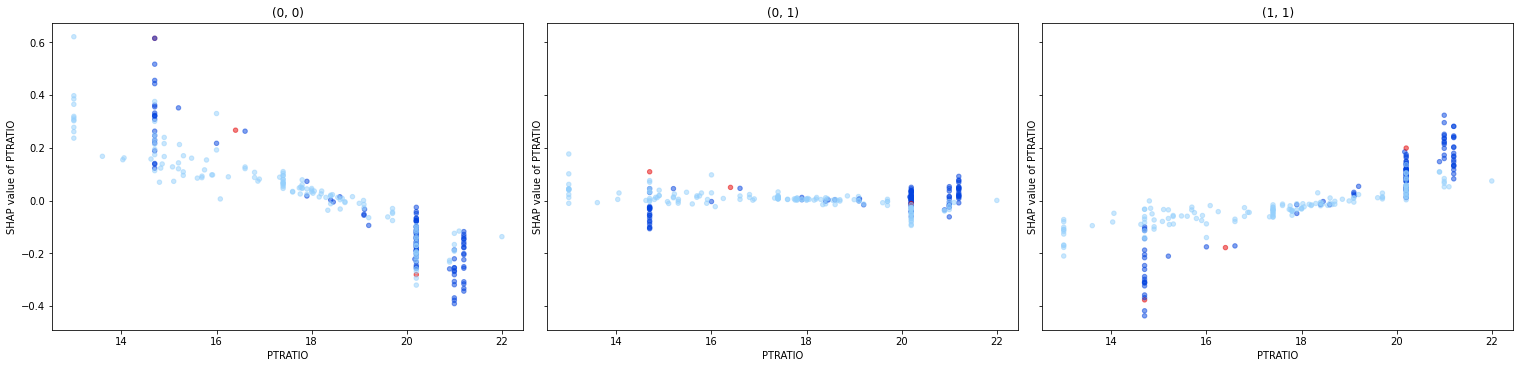

In [48]:
for feature in global_feature_order[1:]:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [45]:
node.describe_feature('ZN')

global   local-all  local-diff
count  246.000000  108.000000         3.0
mean    12.841063    0.115741         0.0
std     25.552540    1.202813         0.0
min      0.000000    0.000000         0.0
25%      0.000000    0.000000         0.0
50%      0.000000    0.000000         0.0
75%     20.000000    0.000000         0.0
max    100.000000   12.500000         0.0

In [46]:
node.describe_feature('INDUS')

global   local-all  local-diff
count  246.000000  108.000000    3.000000
mean    11.718208   17.187994   17.190000
std      7.290396    4.798006    2.952135
min      1.210000    4.050000   13.890000
25%      4.243588   18.100000   15.995000
50%      9.900000   18.100000   18.100000
75%     18.100000   19.580000   18.840000
max     25.650000   25.650000   19.580000

In [47]:
node.describe_feature('RM')

global   local-all  local-diff
count  246.000000  108.000000    3.000000
mean     6.511388    5.875902    6.152667
std      0.889747    0.484219    0.231716
min      3.561000    3.863000    5.888000
25%      5.882000    5.614930    6.069500
50%      6.315500    5.884000    6.251000
75%      7.134552    6.229000    6.285000
max      8.638029    6.833000    6.319000

In the plot of feature DIS we can see, that the different clusters account for the varying degree of effects.

In [50]:
node = node.get_left()

LL
(0, 0)    54
dtype: int64


In [51]:
node = node.parent.get_right()

LR
(0, 0)    32
(1, 1)    17
(0, 1)     3
(1, 0)     2
dtype: int64


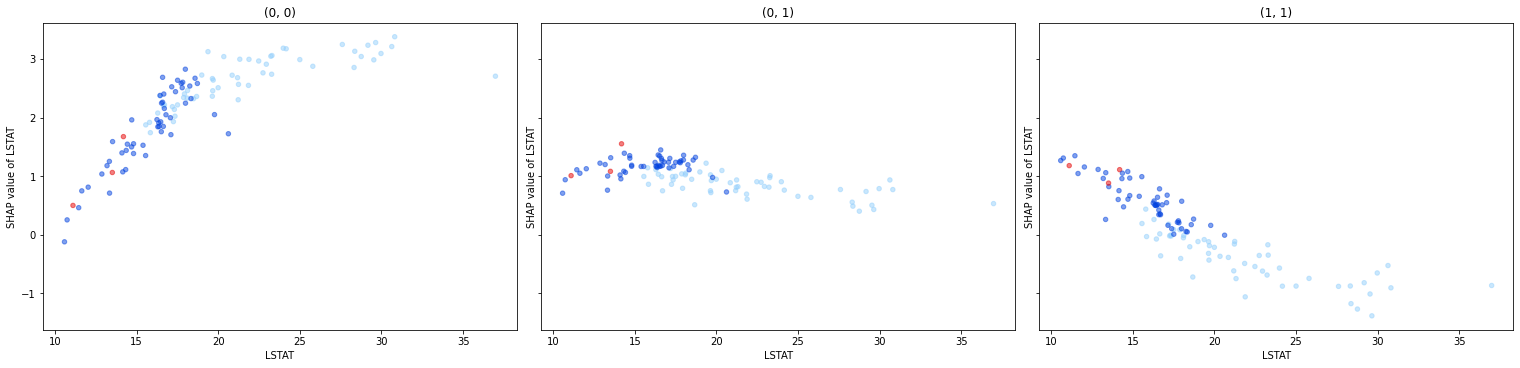

In [52]:
node.parent.plot_feature('LSTAT', focus=node, alpha=0.5)

In [19]:
node.describe_feature('LSTAT')

global  local-all  local-diff
count  246.000000  54.000000    3.000000
mean    11.736981  15.625853   12.933333
std      7.372550   2.329829    1.623710
min      1.763949  10.580000   11.100000
25%      5.008267  14.160000   12.305000
50%      9.950000  16.363418   13.510000
75%     17.091674  17.137500   13.850000
max     36.980000  20.620000   14.190000

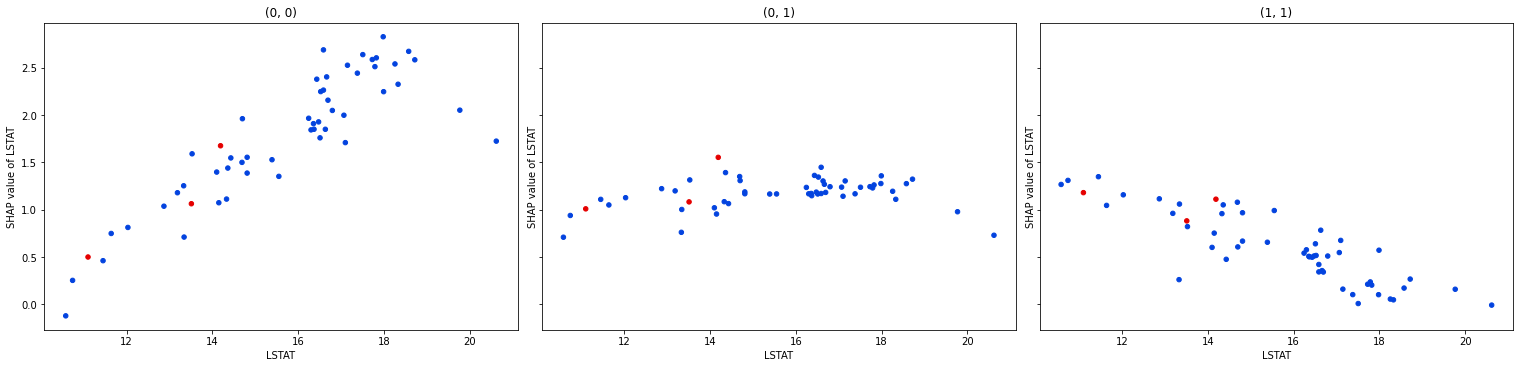

In [20]:
node.plot_feature('LSTAT')

In [21]:
node.test(LSTAT=14.9)

before  after
(0, 0)     NaN    3.0
(0, 1)     3.0    NaN

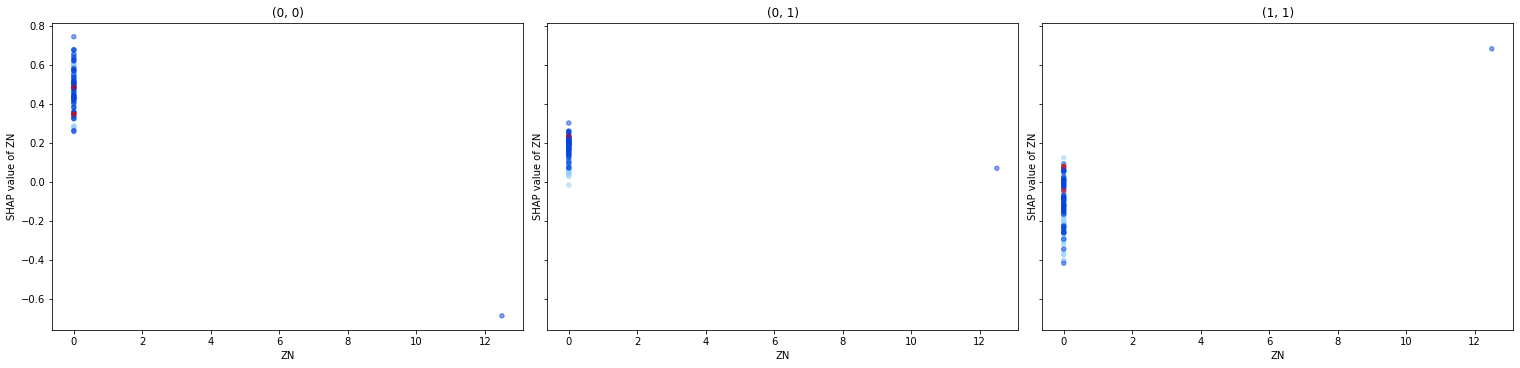

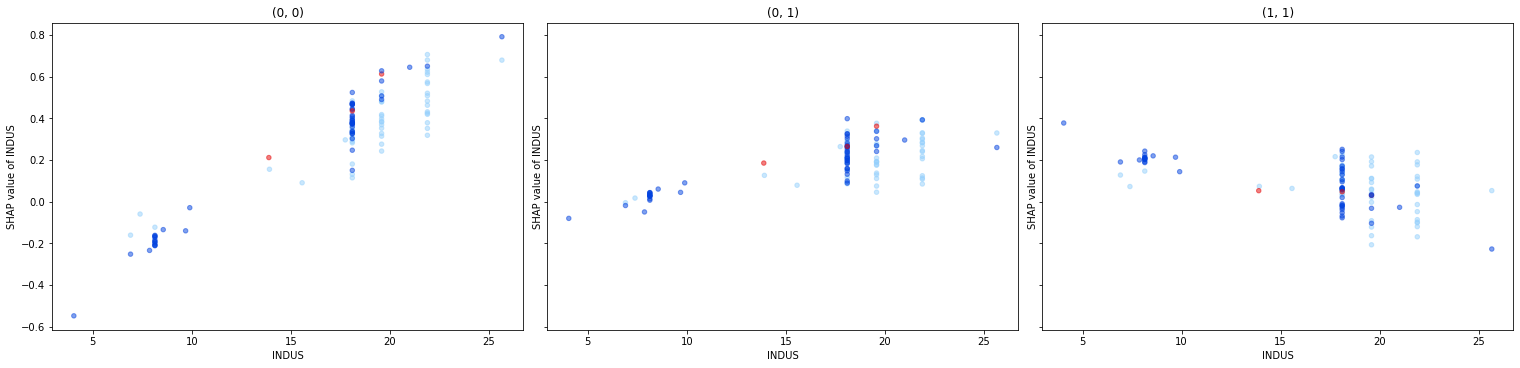

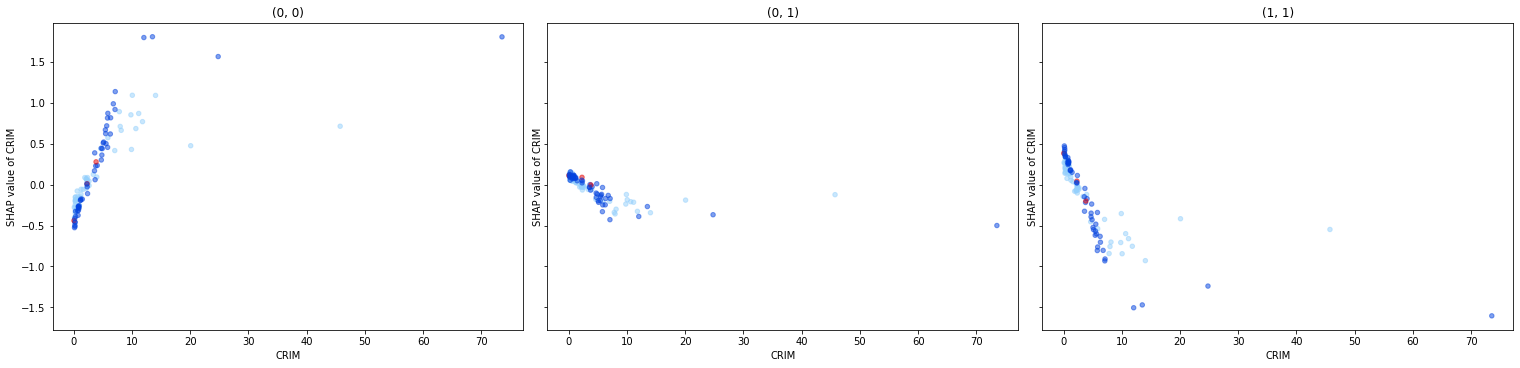

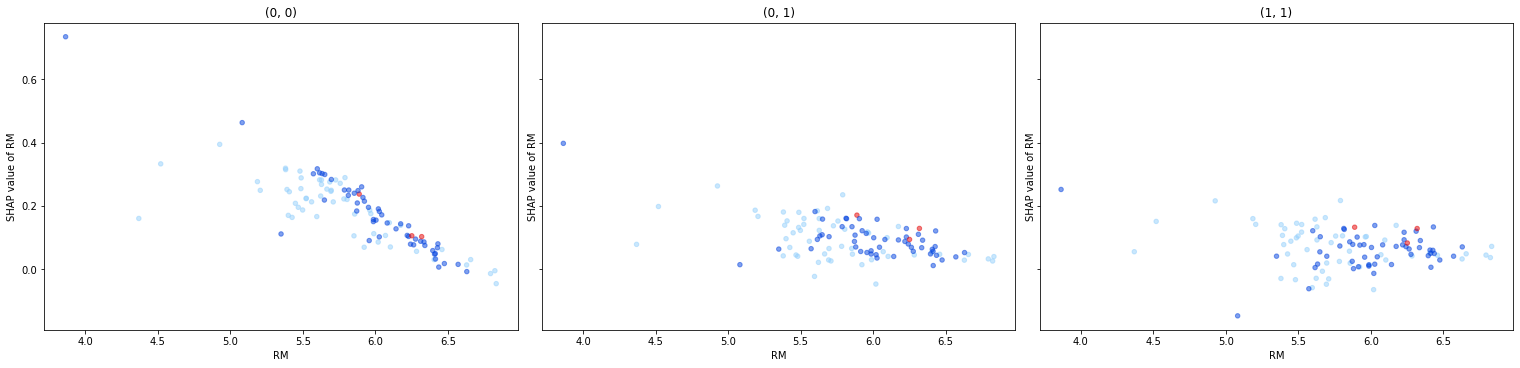

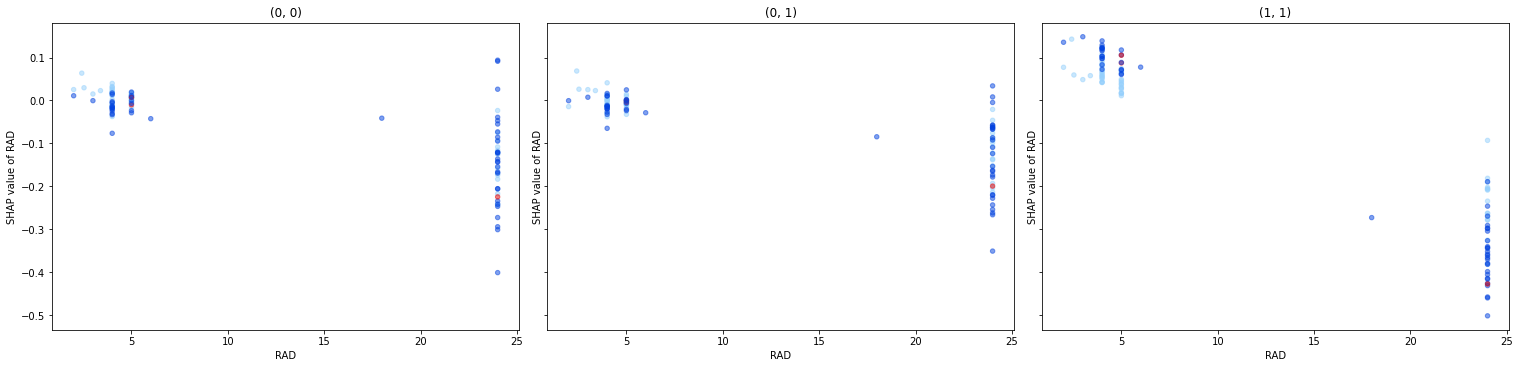

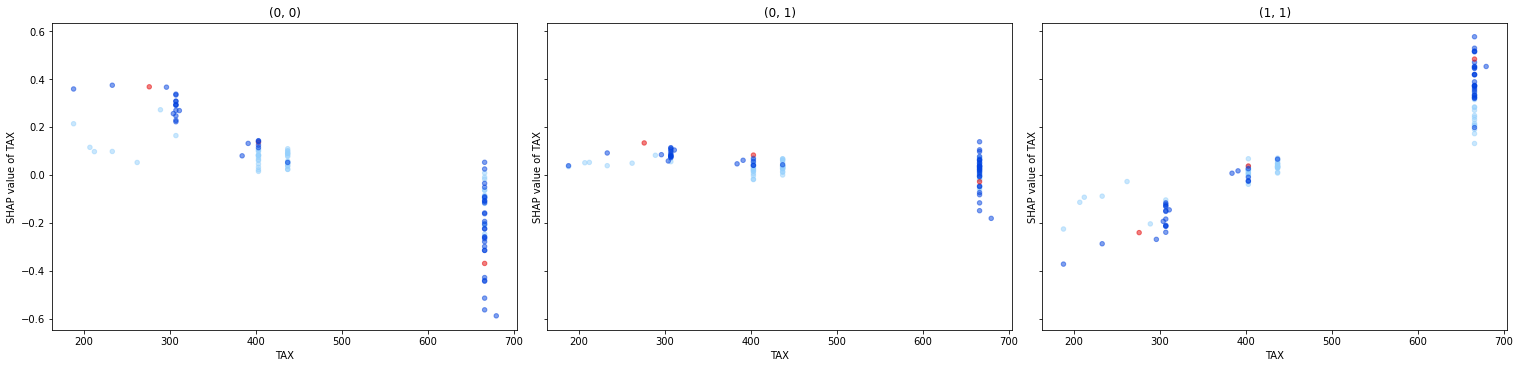

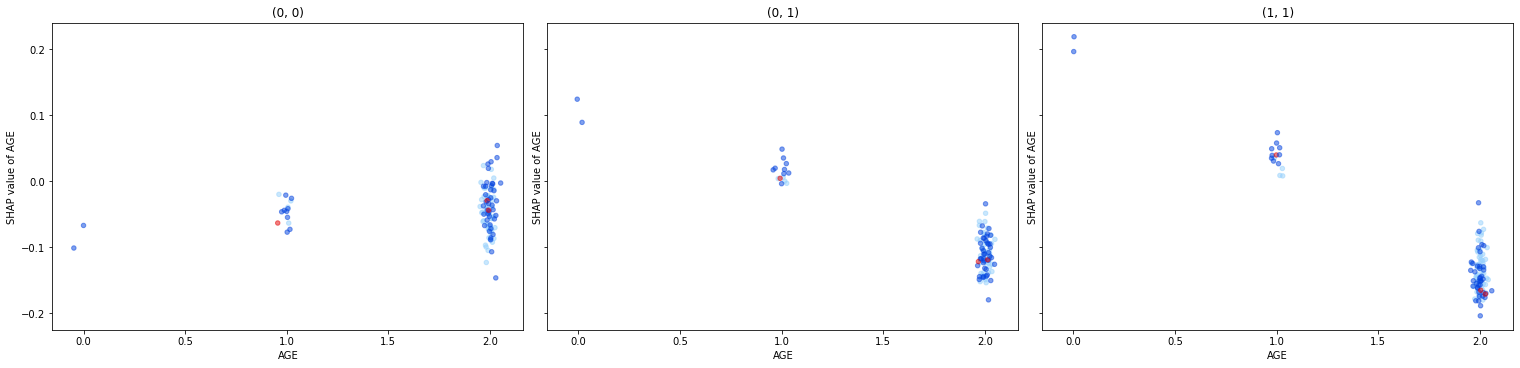

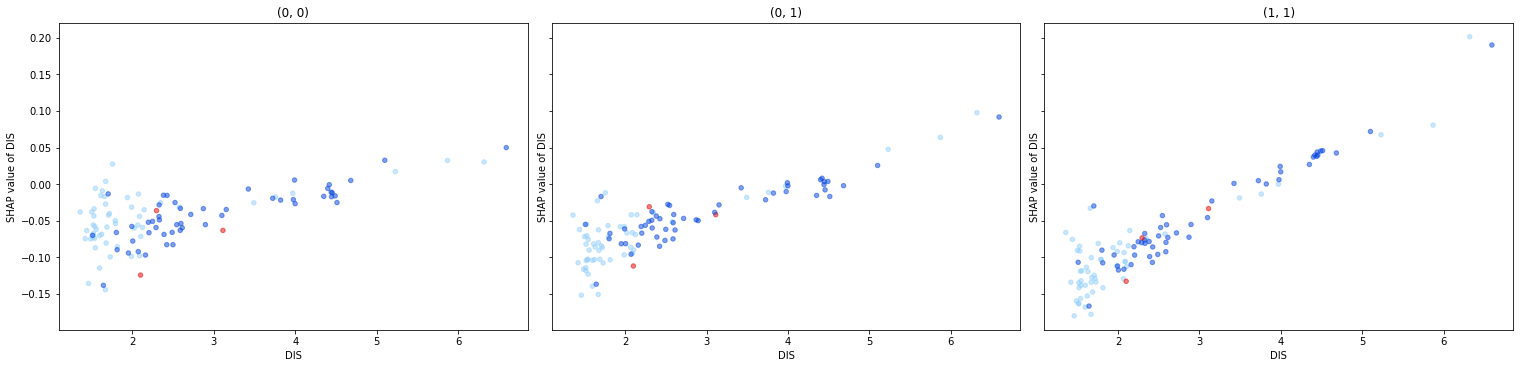

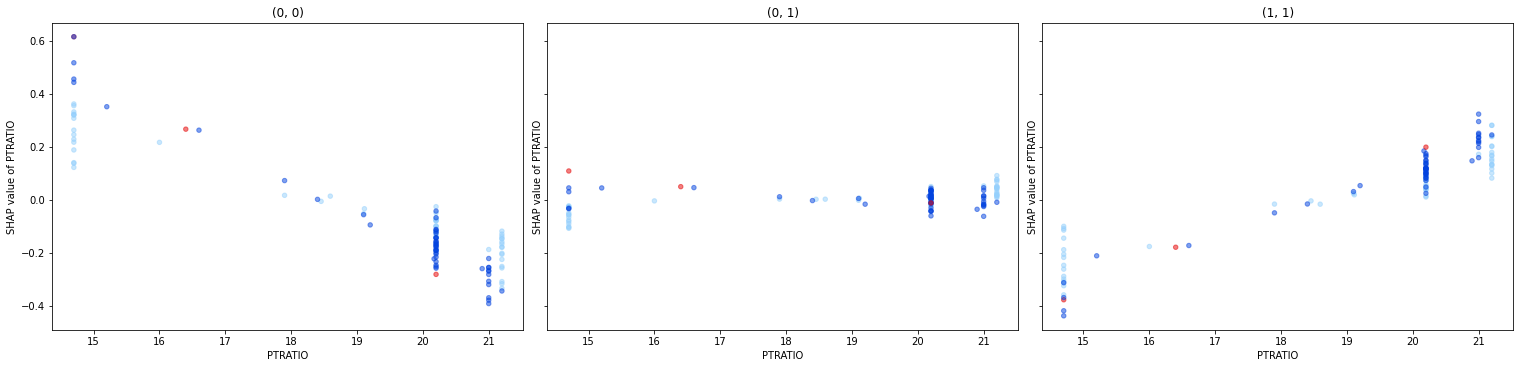

In [53]:
for feature in global_feature_order[1:]:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [42]:
node.test(INDUS=23)

before  after
(0, 0)     NaN    3.0
(0, 1)     3.0    NaN

In [120]:
node.test(INDUS=12)

before  after
(0, 1)     3.0    NaN
(1, 1)     NaN    3.0

In [38]:

node.test(CRIM=5)

before  after
(0, 0)     NaN    3.0
(0, 1)     3.0    NaN

In [31]:
node.test(RM=4.8)

before  after
(0, 0)     NaN    3.0
(0, 1)     3.0    NaN

## Clustering of Class $(1,0)$ SHAP Values

In [54]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds, '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'],
                          categorical_features=categorical_features)

root
(2, 2)    96
(0, 0)    86
(1, 1)    52
(1, 2)     5
(0, 1)     3
(1, 0)     2
(2, 1)     2
dtype: int64


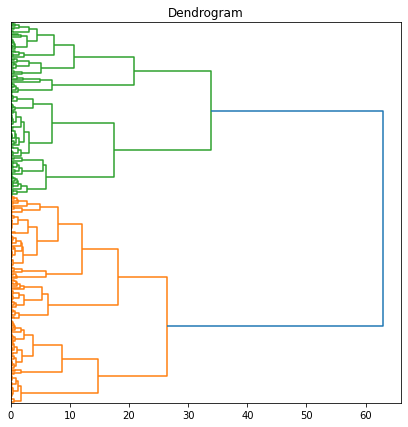

In [55]:
plot_dendrogram(Z)

### Root Node

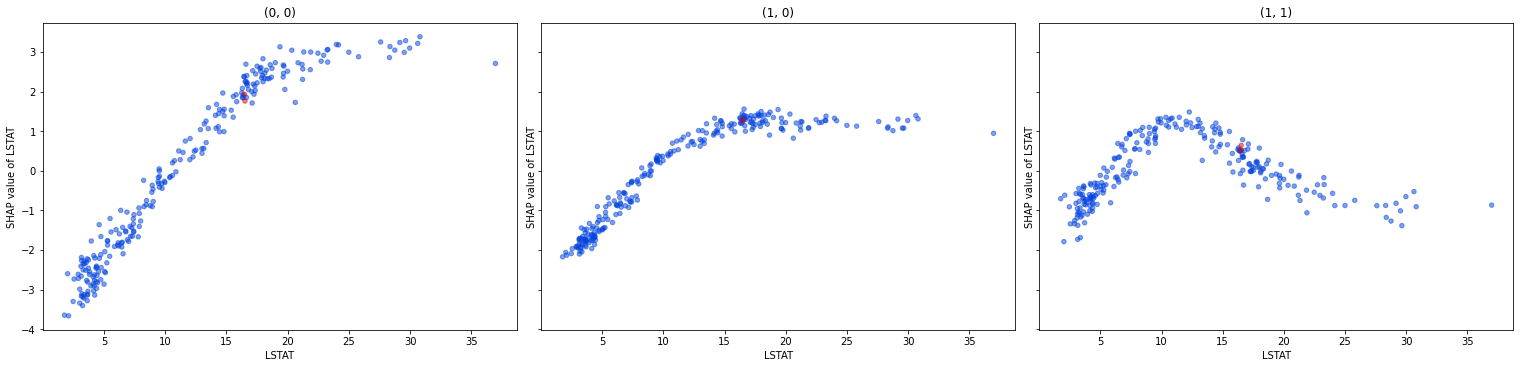

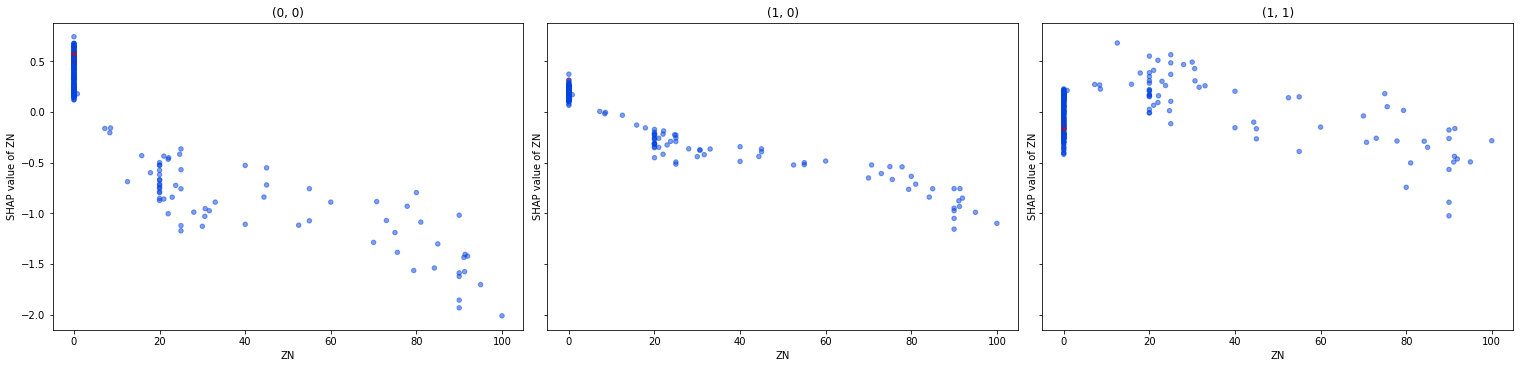

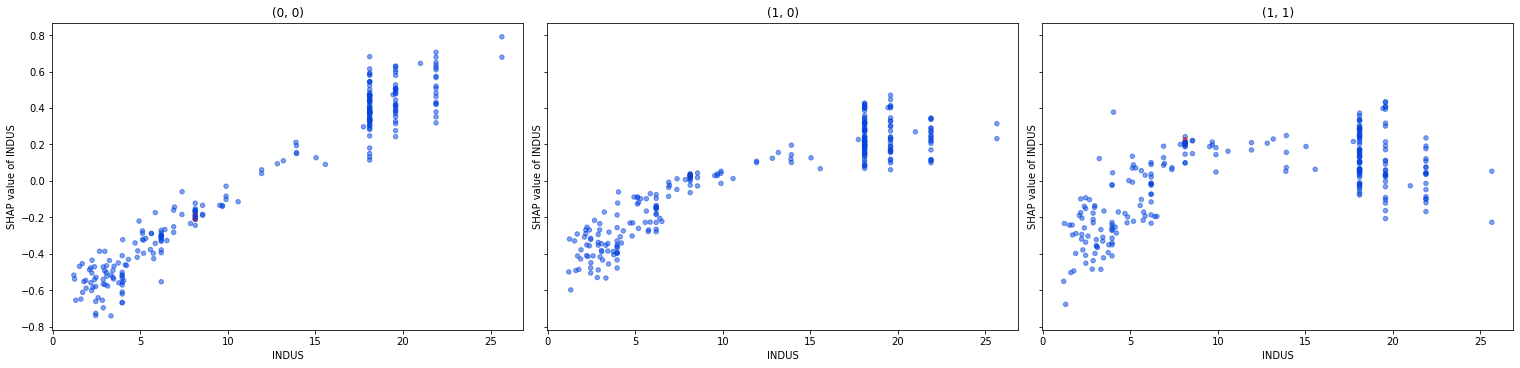

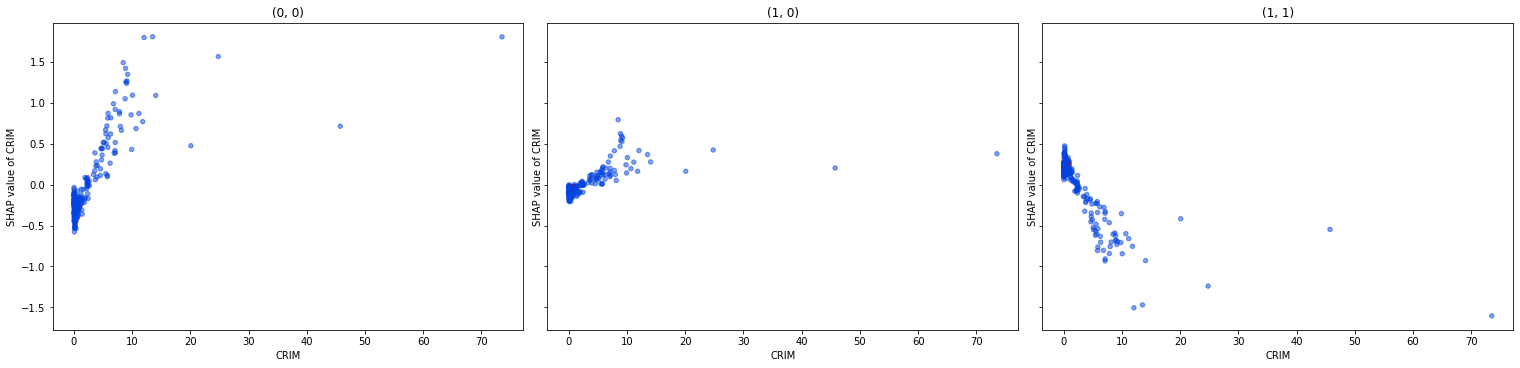

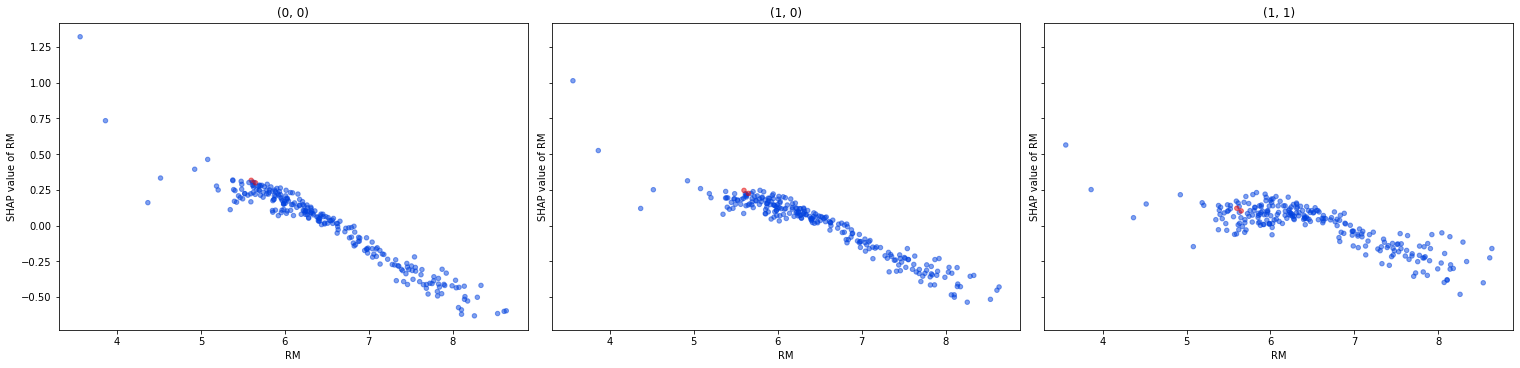

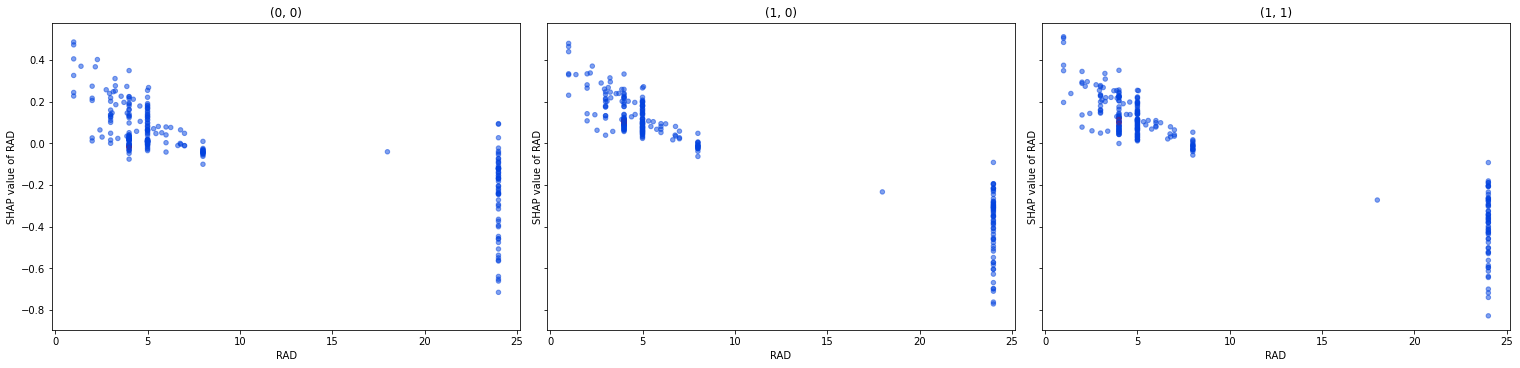

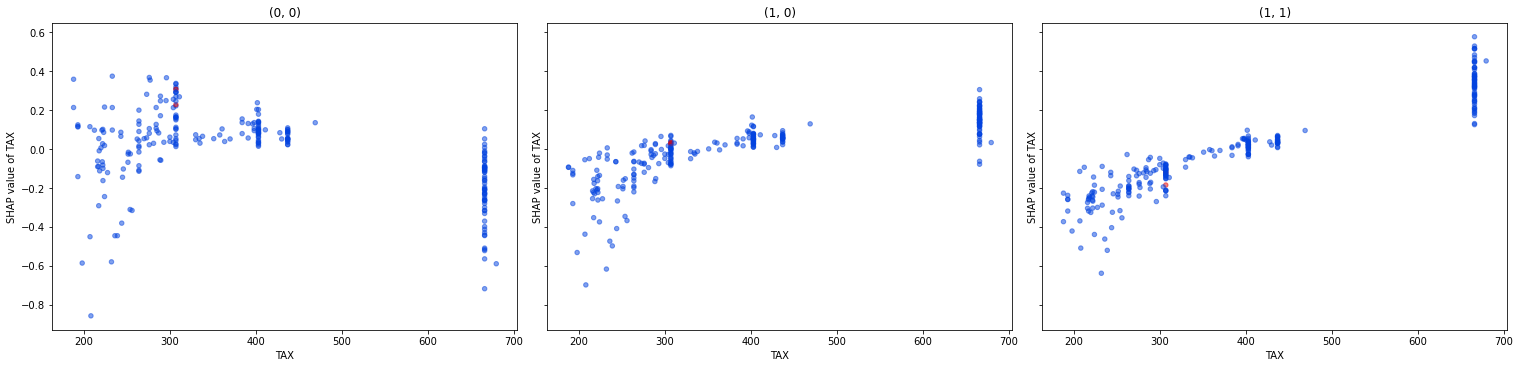

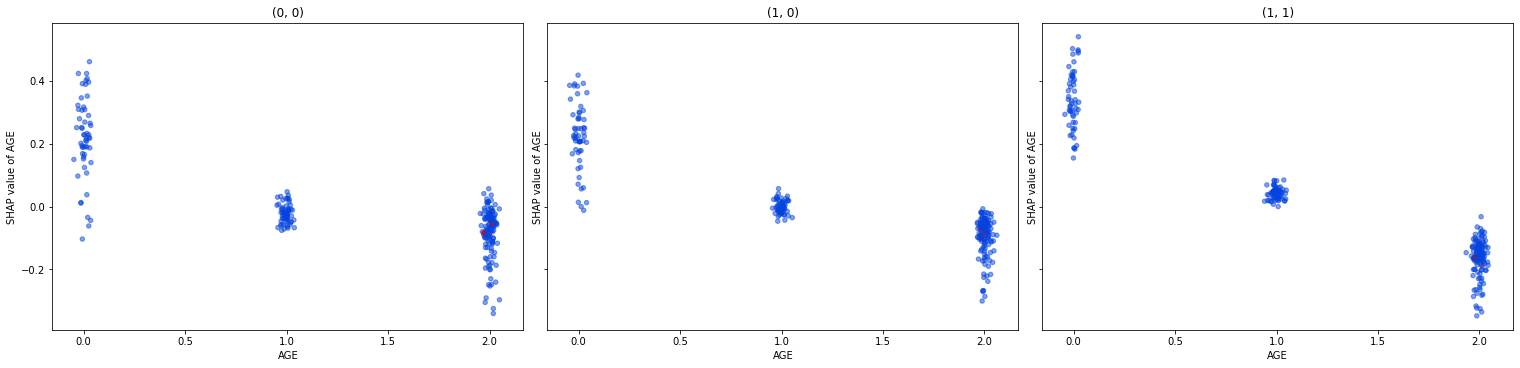

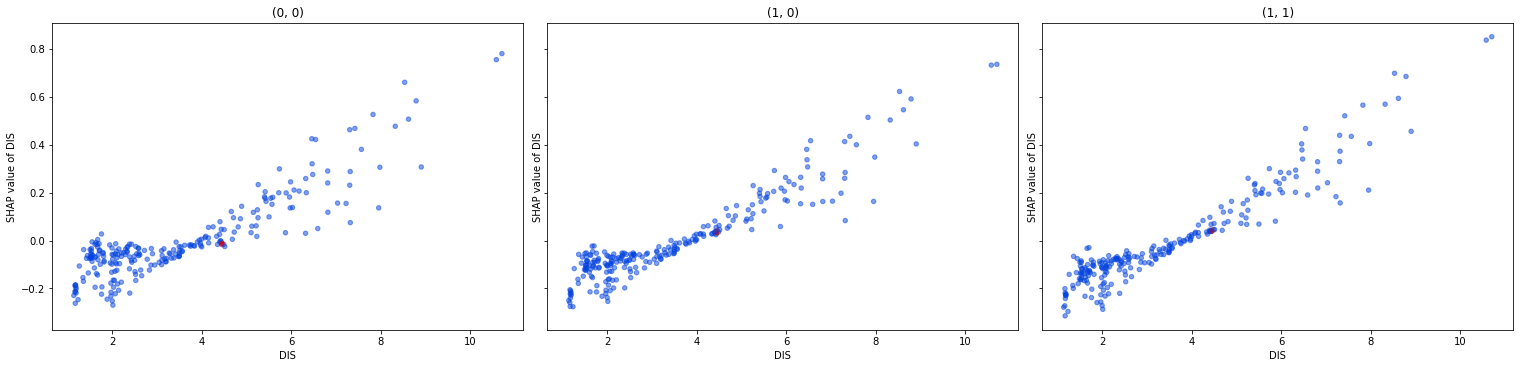

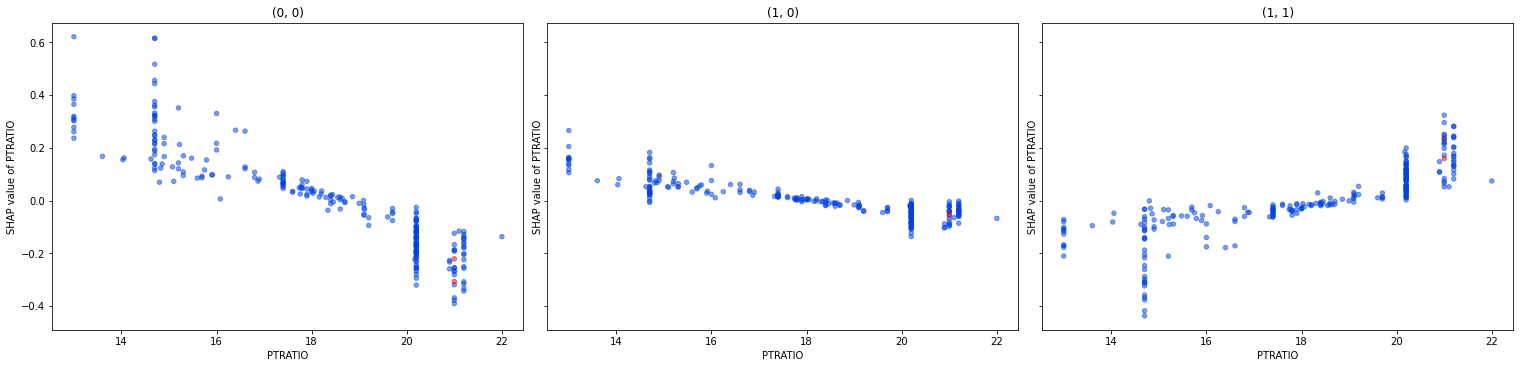

In [56]:
for feature in global_feature_order:
    node.plot_feature(feature, alpha=0.5)

In [57]:
node.describe_feature('LSTAT')

global   local-all  local-diff
count  246.000000  246.000000    2.000000
mean    11.736981   11.736981   16.493291
std      7.372550    7.372550    0.023630
min      1.763949    1.763949   16.476581
25%      5.008267    5.008267   16.484936
50%      9.950000    9.950000   16.493291
75%     17.091674   17.091674   16.501645
max     36.980000   36.980000   16.510000

In [58]:
node.describe_feature('ZN')

global   local-all  local-diff
count  246.000000  246.000000         2.0
mean    12.841063   12.841063         0.0
std     25.552540   25.552540         0.0
min      0.000000    0.000000         0.0
25%      0.000000    0.000000         0.0
50%      0.000000    0.000000         0.0
75%     20.000000   20.000000         0.0
max    100.000000  100.000000         0.0

In [59]:
node.describe_feature('INDUS')

global   local-all  local-diff
count  246.000000  246.000000        2.00
mean    11.718208   11.718208        8.14
std      7.290396    7.290396        0.00
min      1.210000    1.210000        8.14
25%      4.243588    4.243588        8.14
50%      9.900000    9.900000        8.14
75%     18.100000   18.100000        8.14
max     25.650000   25.650000        8.14

I will only use the first three features to characterize these instances.

### Node L

In [60]:
node = node.get_left()

L
(0, 0)    86
(1, 1)    41
(0, 1)     3
(1, 0)     2
(2, 2)     1
(1, 2)     1
dtype: int64


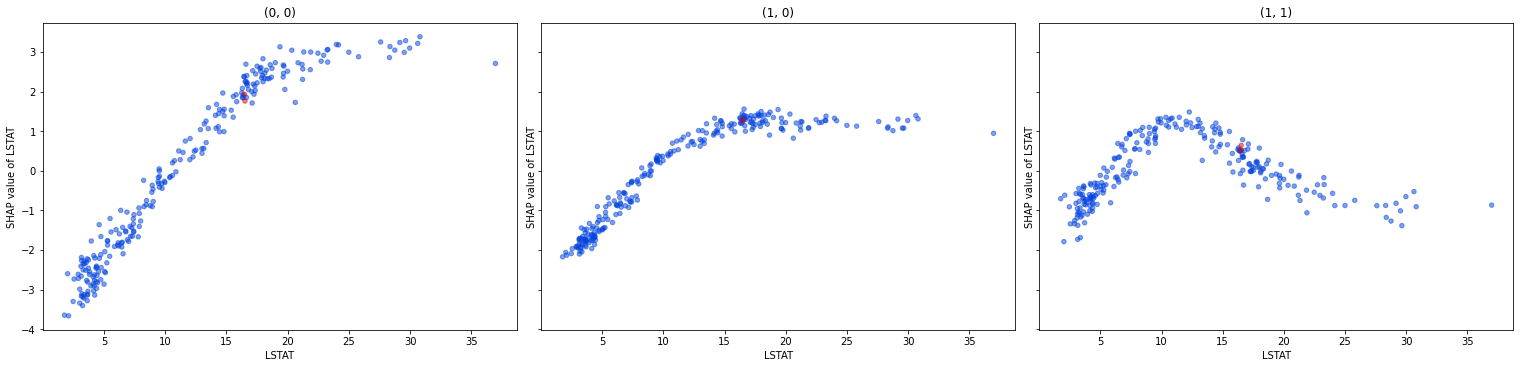

In [61]:
node.parent.plot_feature('LSTAT', alpha=0.5)

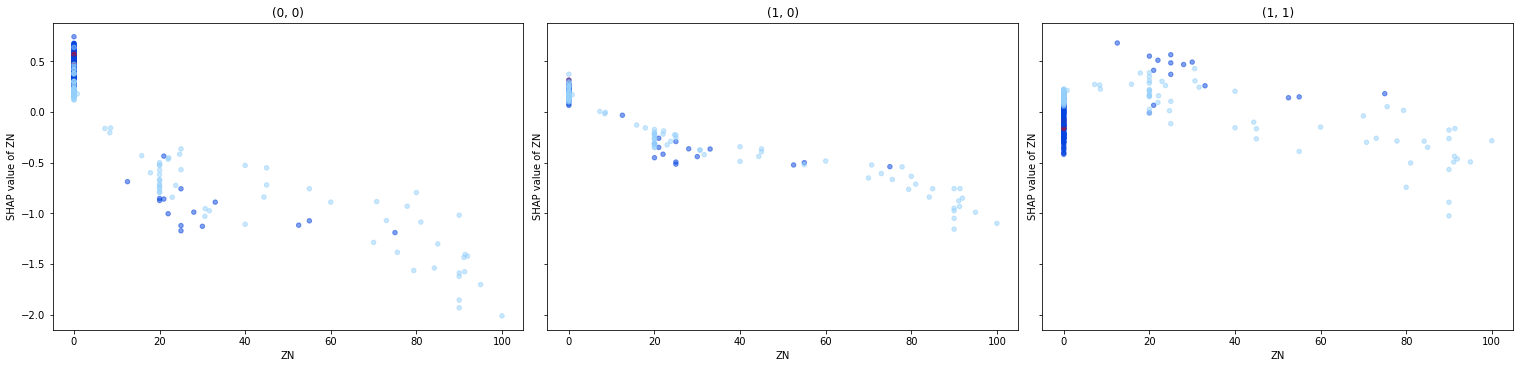

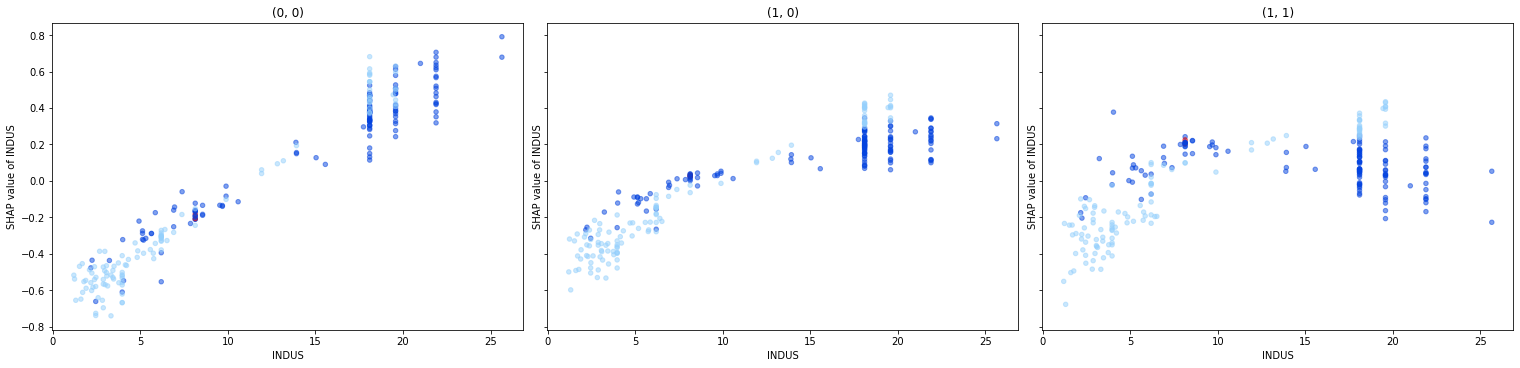

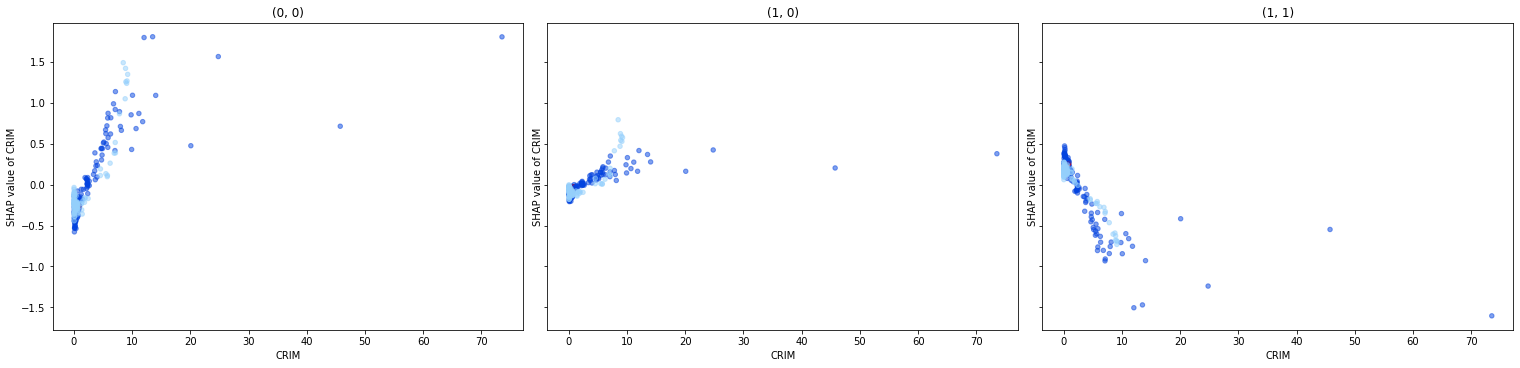

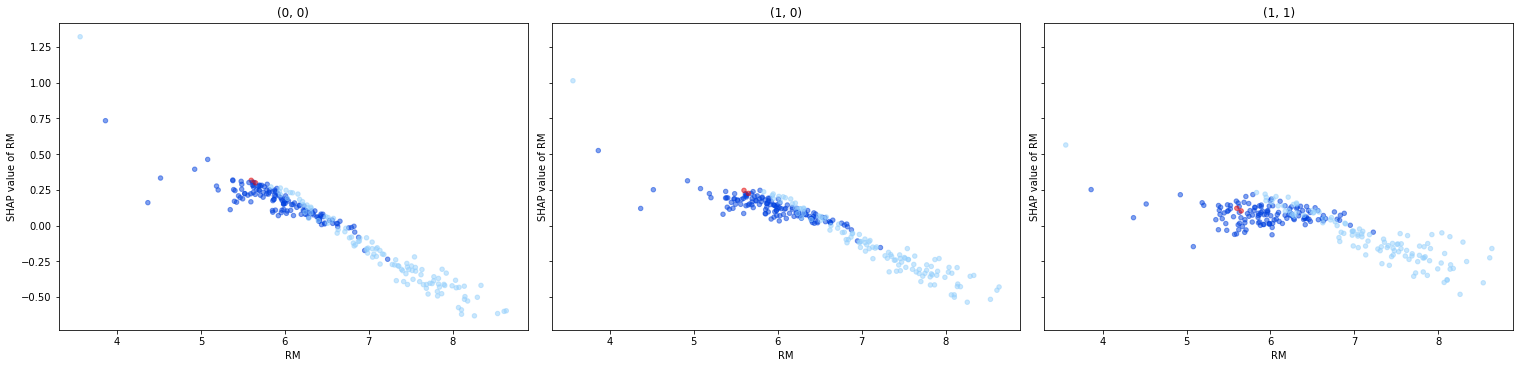

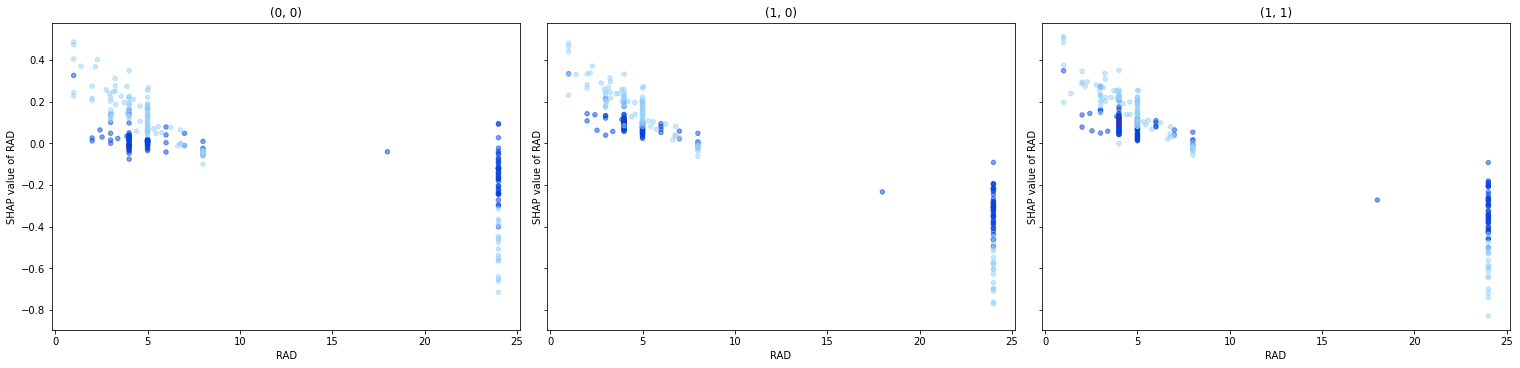

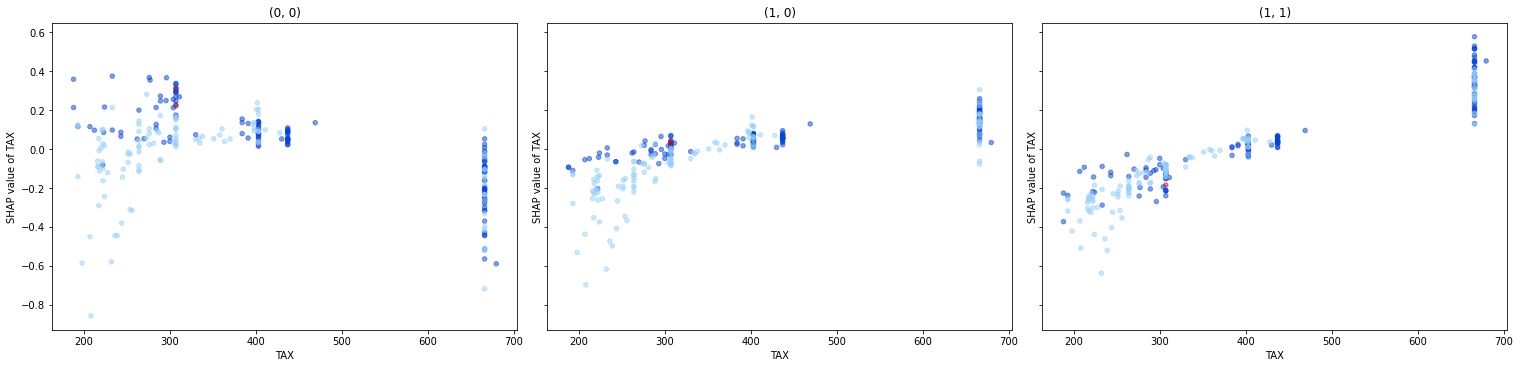

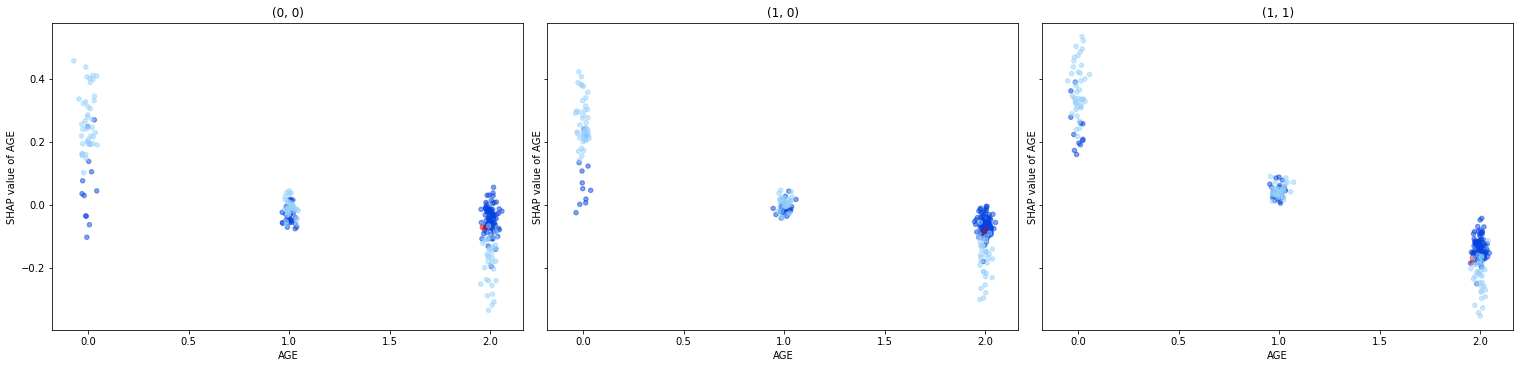

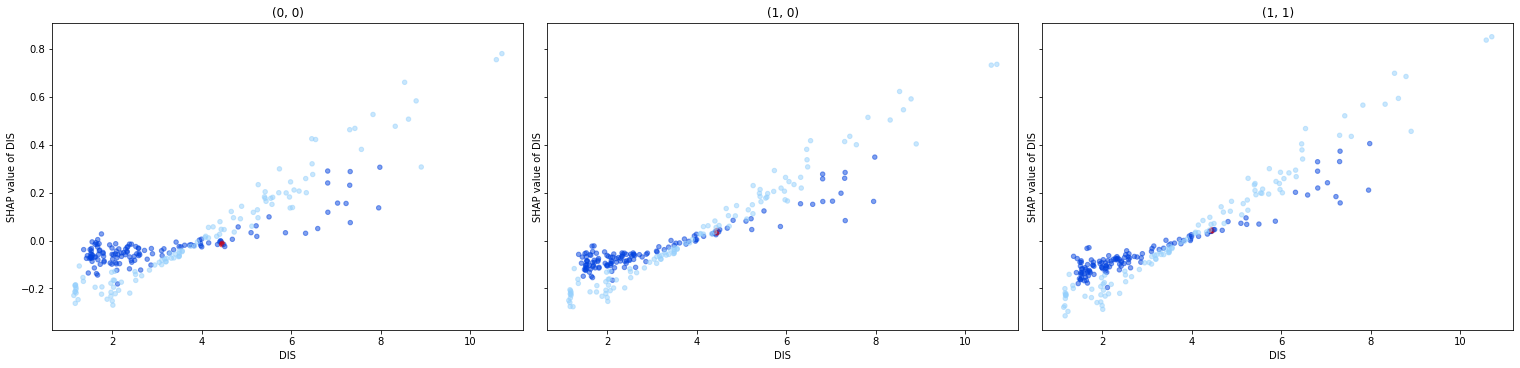

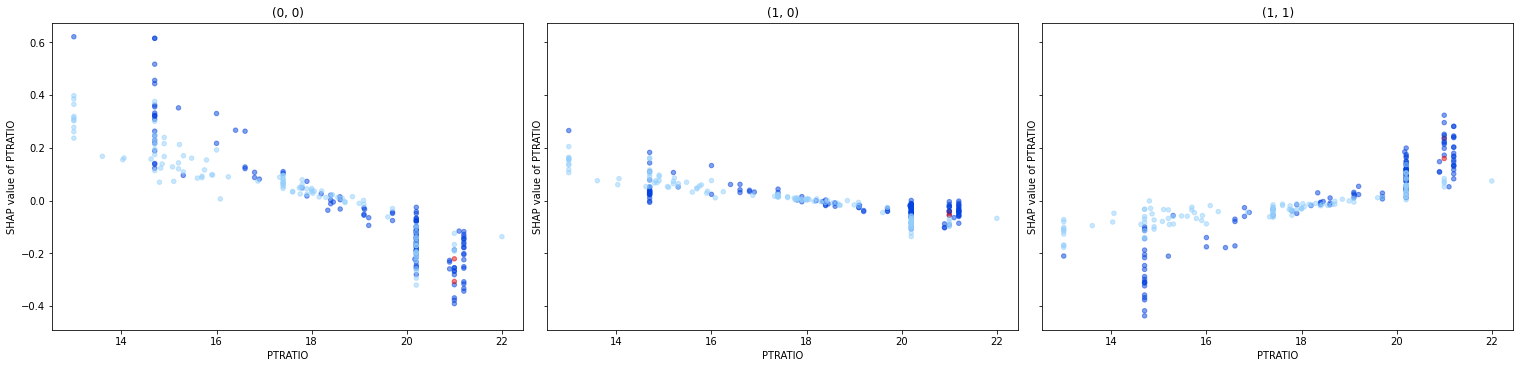

In [62]:
for feature in global_feature_order[1:]:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [63]:
node.describe_feature('RM')

global   local-all  local-diff
count  246.000000  134.000000    2.000000
mean     6.511388    5.944769    5.624860
std      0.889747    0.493170    0.036571
min      3.561000    3.863000    5.599000
25%      5.882000    5.648680    5.611930
50%      6.315500    5.938000    5.624860
75%      7.134552    6.273322    5.637789
max      8.638029    7.225003    5.650719

In [64]:
node.describe_feature('CRIM')

global   local-all  local-diff
count  246.000000  134.000000    2.000000
mean     2.720010    3.828613    0.833357
std      6.388147    8.169453    0.010159
min      0.009060    0.010960    0.826173
25%      0.099321    0.263988    0.829765
50%      0.540032    1.219945    0.833357
75%      3.181873    4.811689    0.836948
max     73.534100   73.534100    0.840540

In [69]:
node.test(CRIM=2)

before  after
(0, 0)     NaN    2.0
(1, 0)     2.0    NaN

In [70]:
node.describe_feature('TAX')

global   local-all  local-diff
count  246.000000  134.000000         2.0
mean   403.132604  451.463966       307.0
std    165.416533  163.536319         0.0
min    188.000000  188.000000       307.0
25%    273.000000  307.000000       307.0
50%    362.186013  403.000000       307.0
75%    461.000000  666.000000       307.0
max    679.526743  679.526743       307.0

In [77]:
node.test(TAX=327)

before  after
(1, 0)     2.0    NaN
(1, 1)     NaN    2.0

In [86]:
node.test(TAX=288)

before  after
(0, 0)     NaN    2.0
(1, 0)     2.0    NaN

In [90]:
node.test(INDUS=9.2)

before  after
(0, 0)     NaN    2.0
(1, 0)     2.0    NaN

In [97]:
node.test(INDUS=7.1)

before  after
(1, 0)     2.0    NaN
(1, 1)     NaN    2.0

### Node LR

In [100]:
node = node.get_right()

LR
(1, 1)    41
(0, 0)    32
(0, 1)     3
(1, 0)     2
(1, 2)     1
(2, 2)     1
dtype: int64


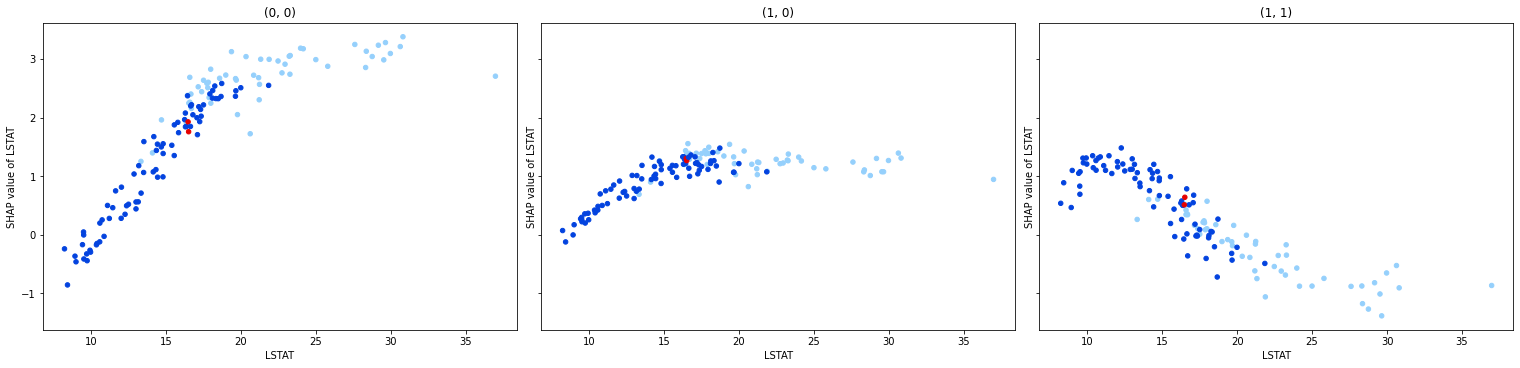

In [107]:
node.parent.plot_feature('LSTAT', focus=node)

In [108]:
node.describe_feature('LSTAT')

global  local-all  local-diff
count  246.000000  80.000000    2.000000
mean    11.736981  14.258667   16.493291
std      7.372550   3.281826    0.023630
min      1.763949   8.230000   16.476581
25%      5.008267  11.392500   16.484936
50%      9.950000  14.435000   16.493291
75%     17.091674  16.726068   16.501645
max     36.980000  21.849034   16.510000

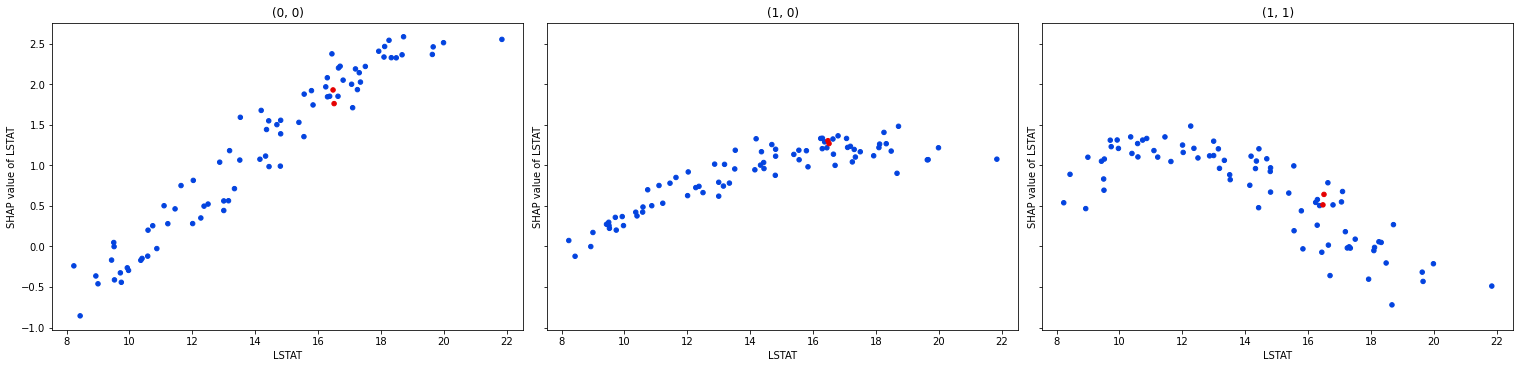

In [101]:
node.plot_feature('LSTAT')

In [103]:
node.test(LSTAT=16.3)

before  after
(1, 0)     2.0    NaN
(1, 1)     NaN    2.0

In [106]:
node.test(LSTAT=16.8)

before  after
(0, 0)     NaN    2.0
(1, 0)     2.0    NaN

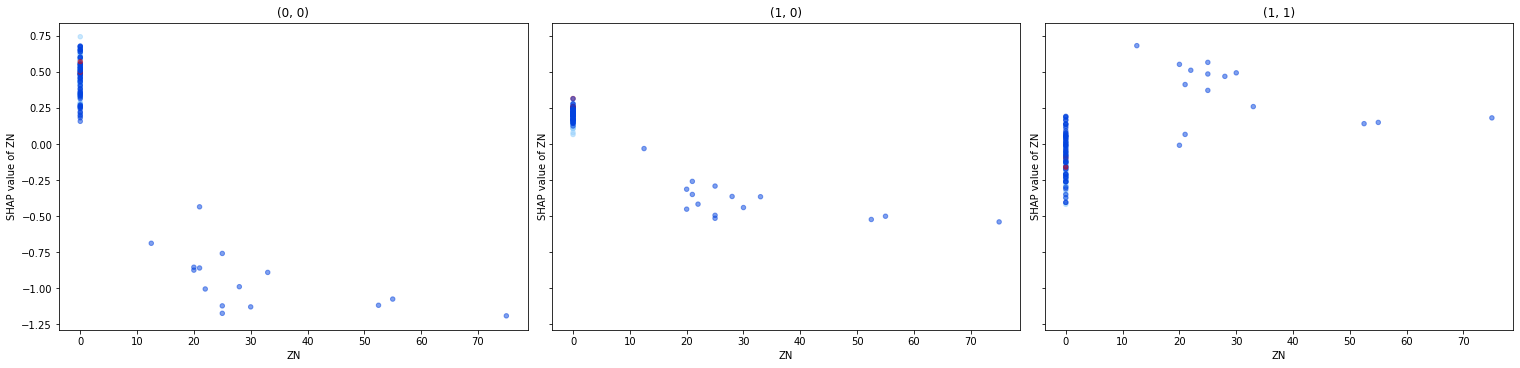

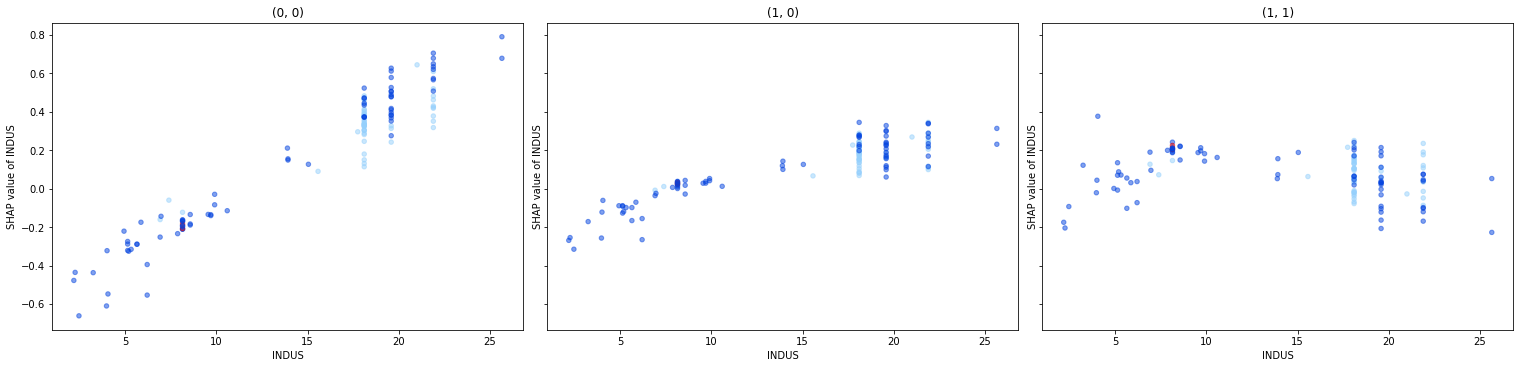

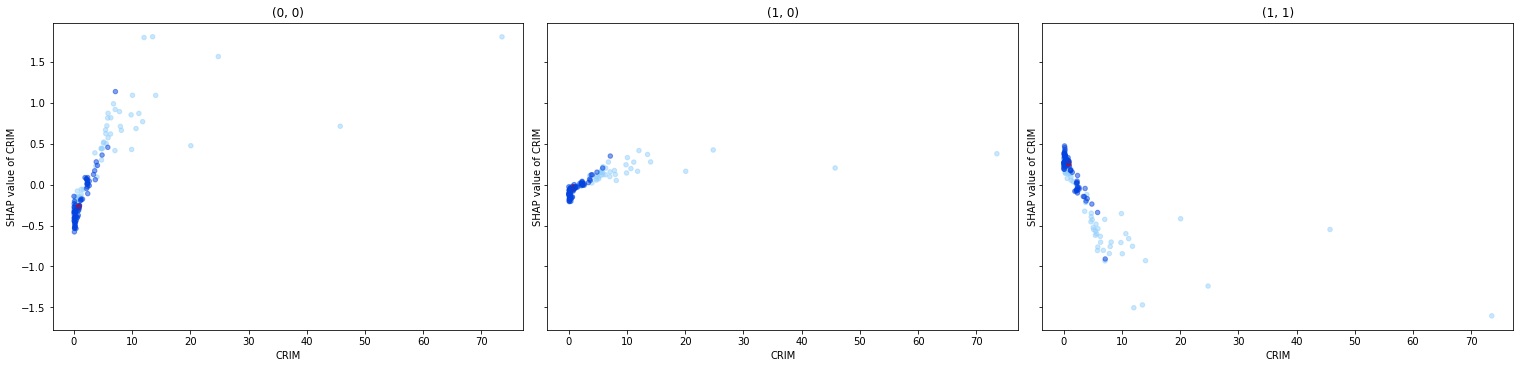

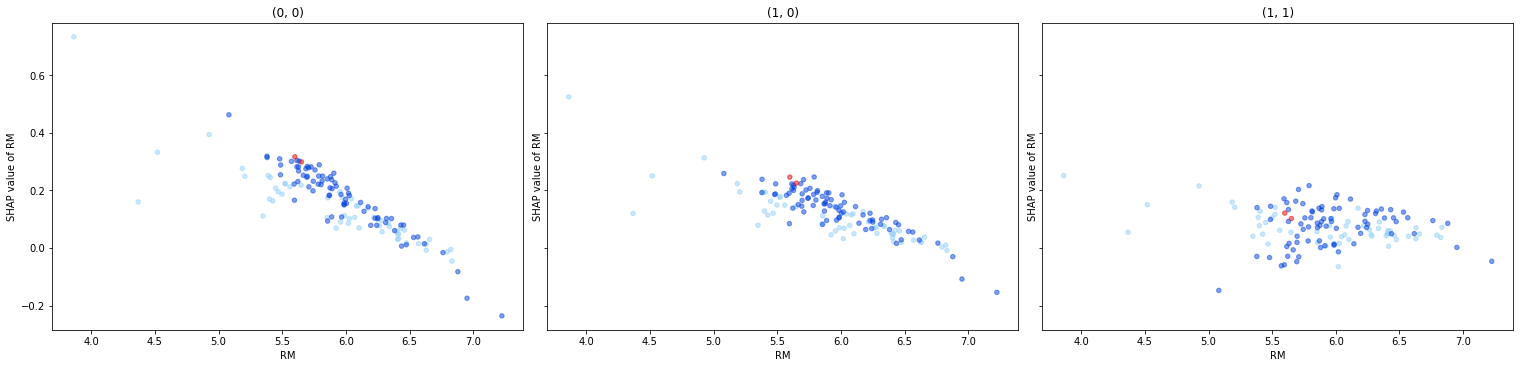

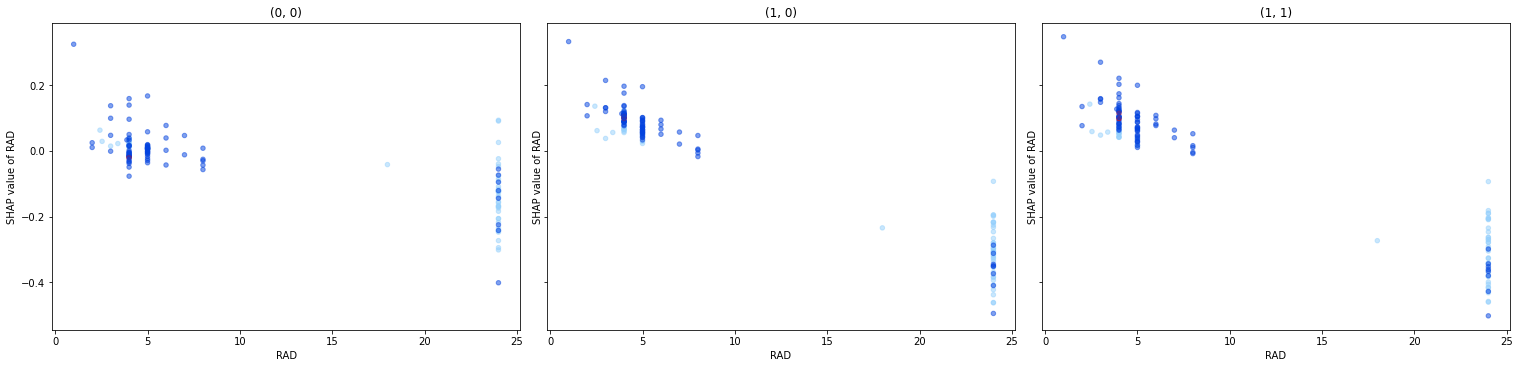

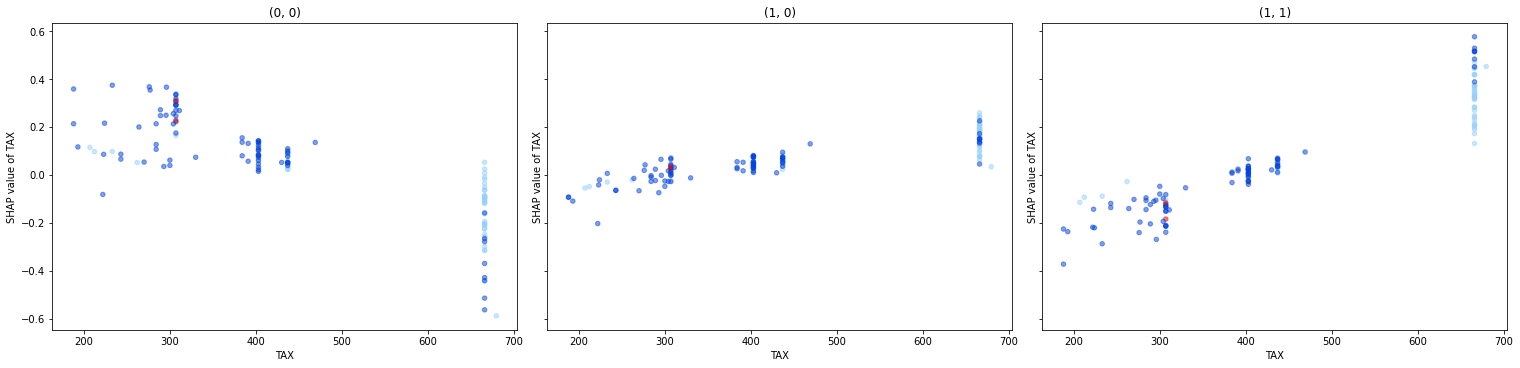

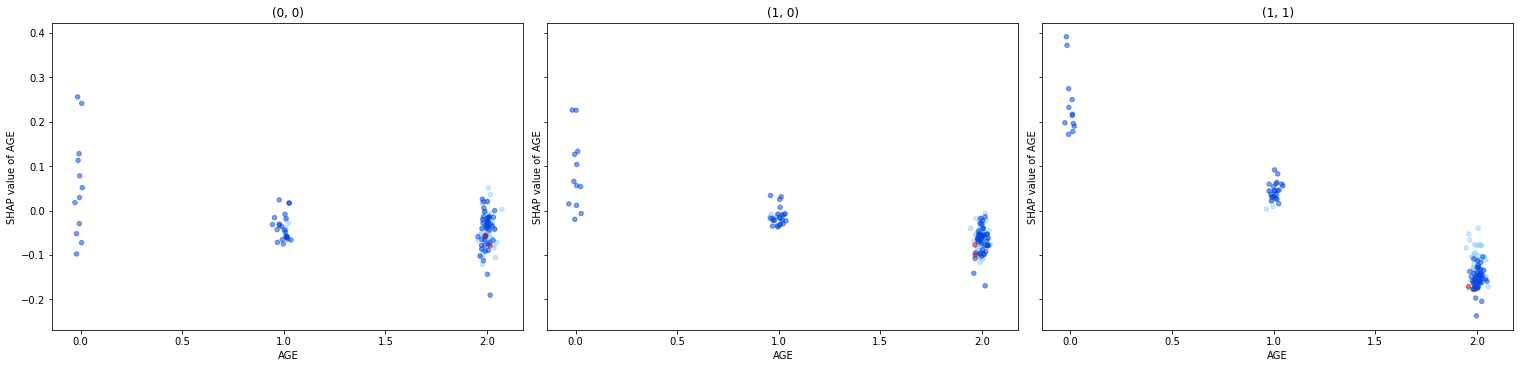

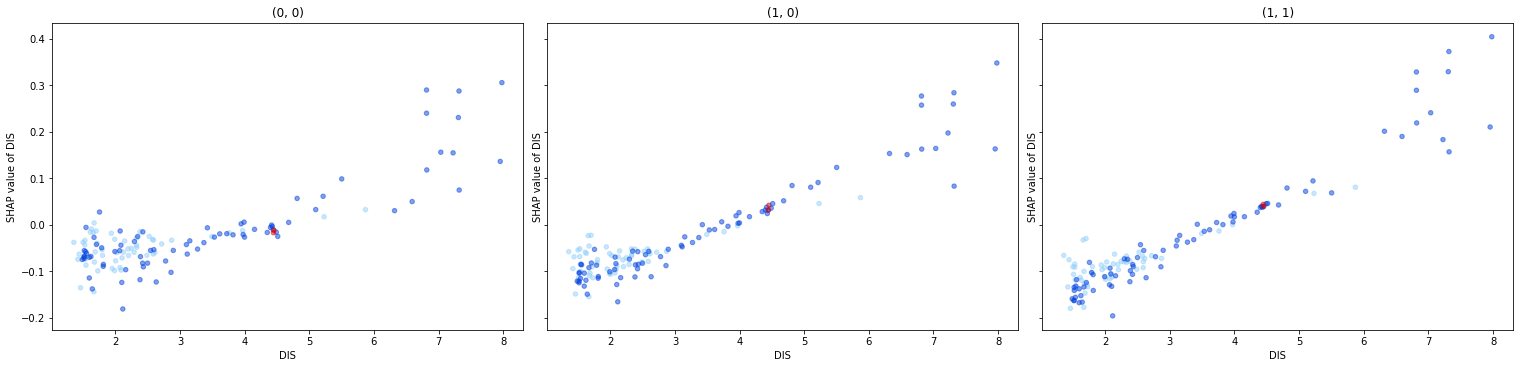

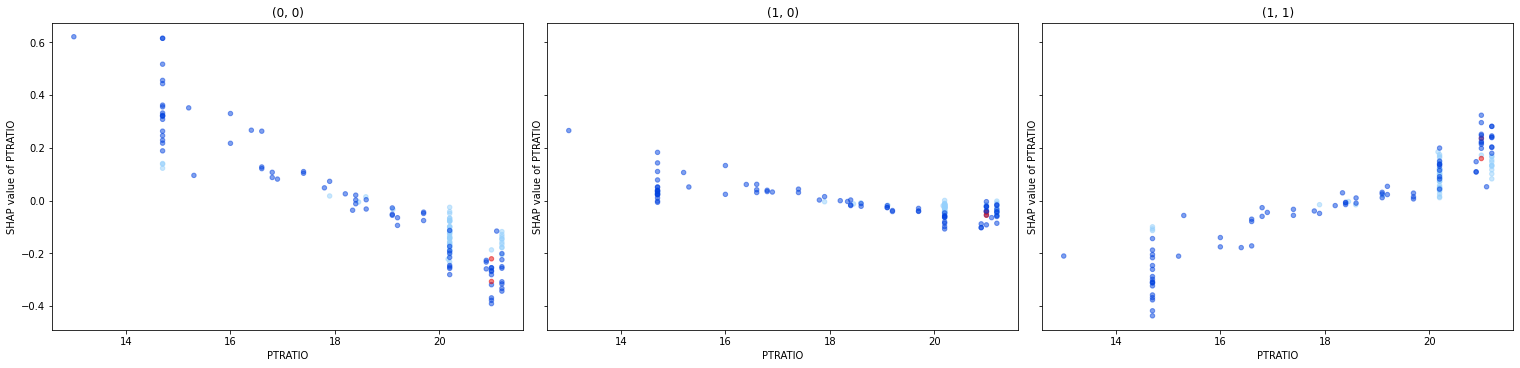

In [109]:
for feature in global_feature_order[1:]:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

## Clustering of Class $(1,2)$ SHAP Values

In [178]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds, '(1, 2)', ['(1, 1)', '(1, 2)', '(2, 2)'],
                          categorical_features=categorical_features)

root
(2, 2)    96
(0, 0)    86
(1, 1)    52
(1, 2)     5
(0, 1)     3
(1, 0)     2
(2, 1)     2
dtype: int64


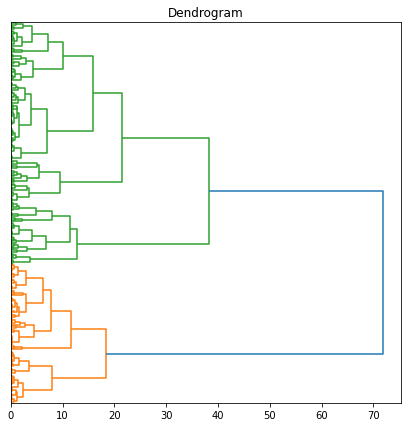

In [179]:
plot_dendrogram(Z)

### Root Node

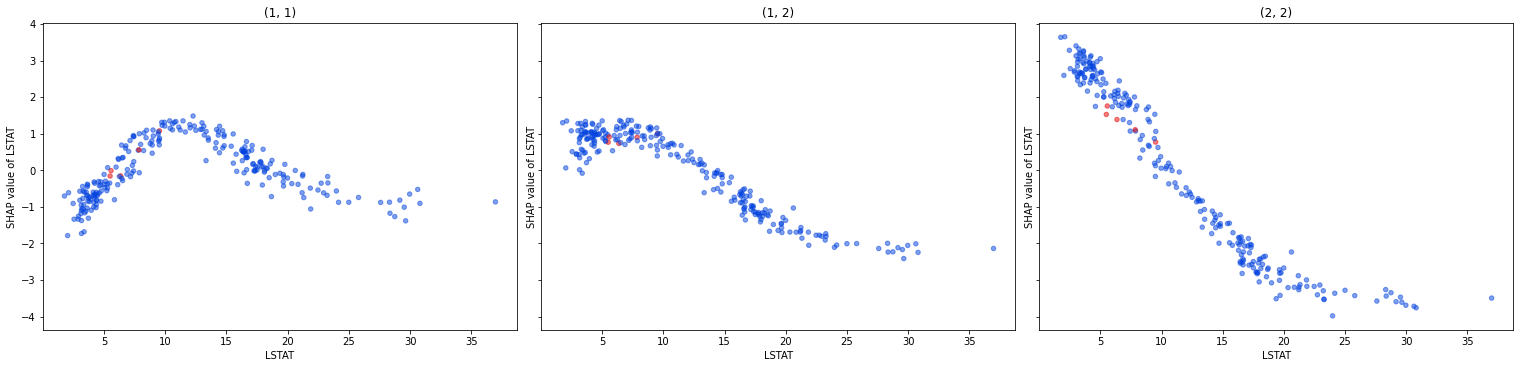

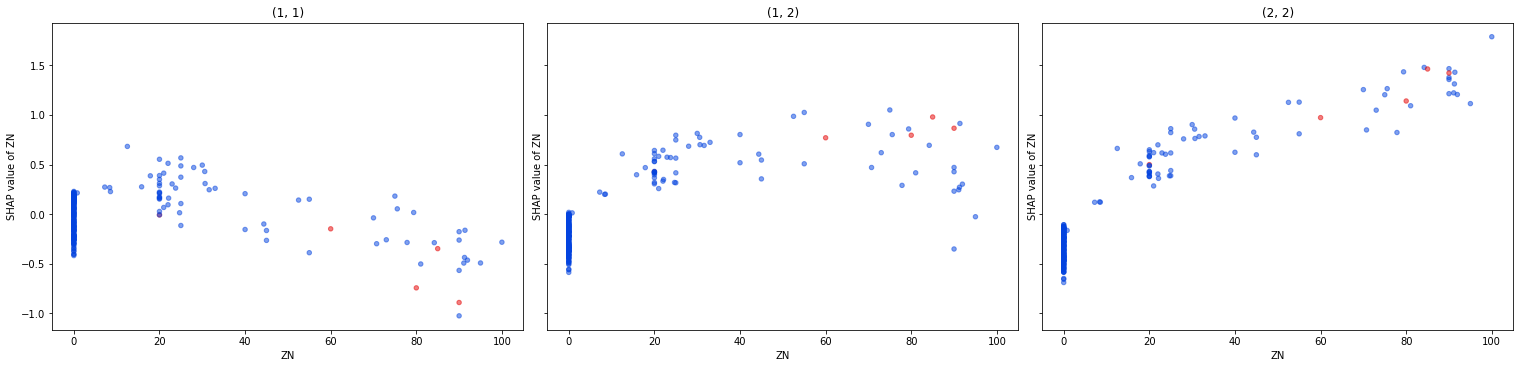

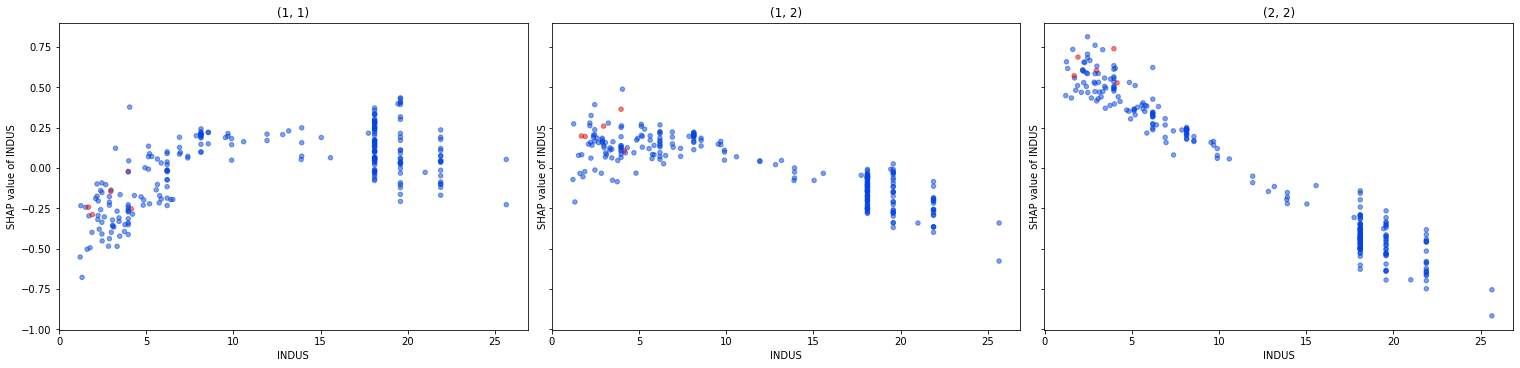

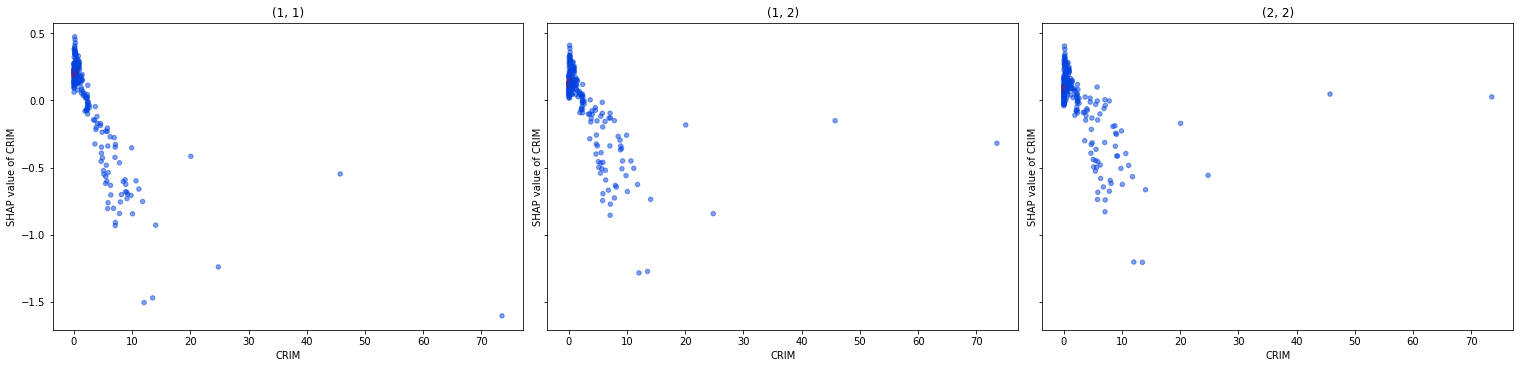

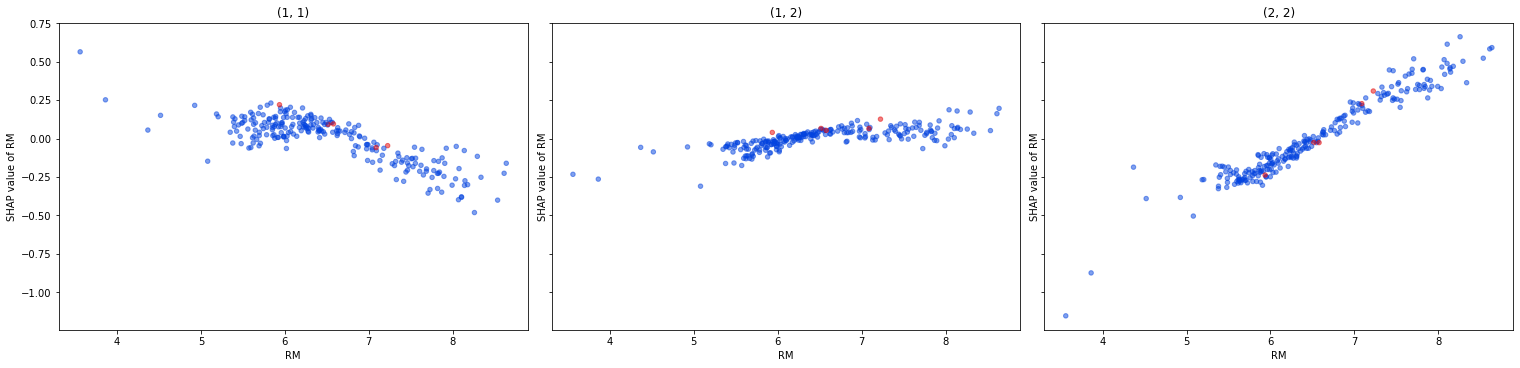

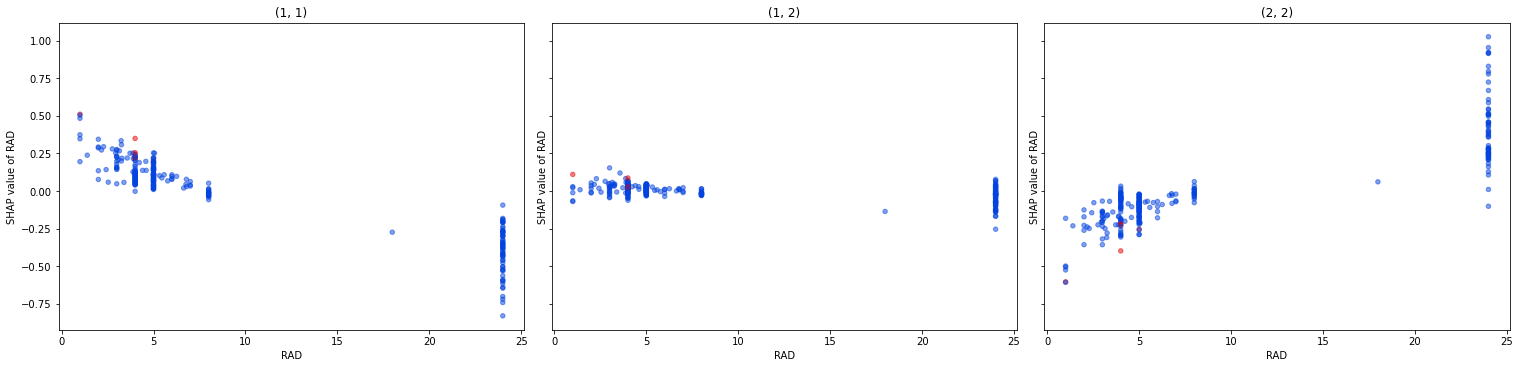

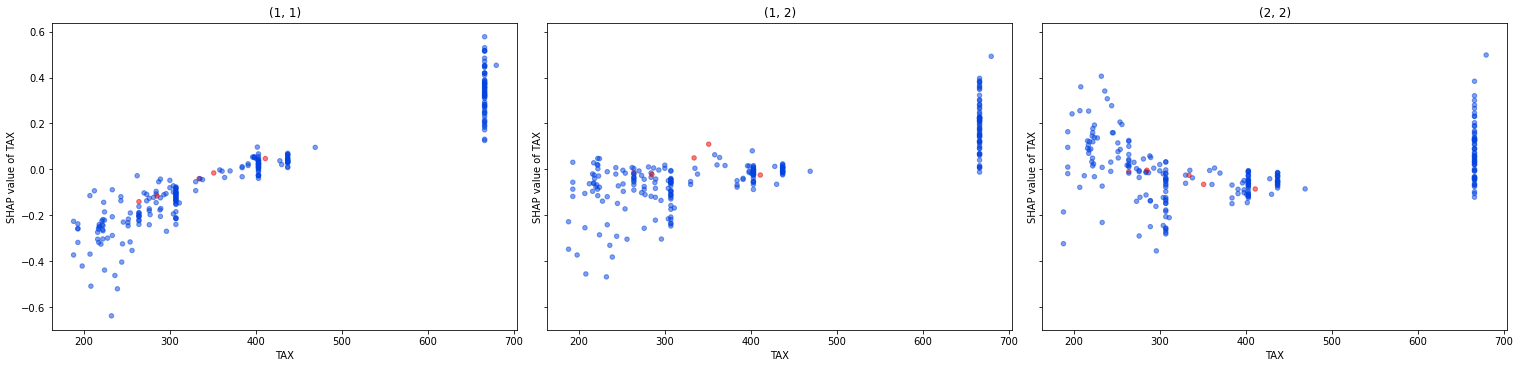

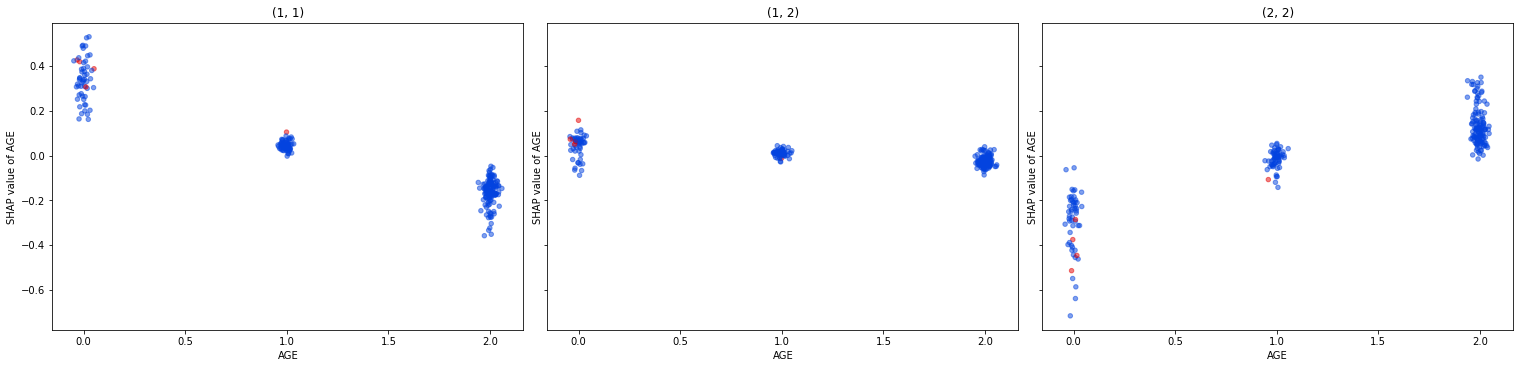

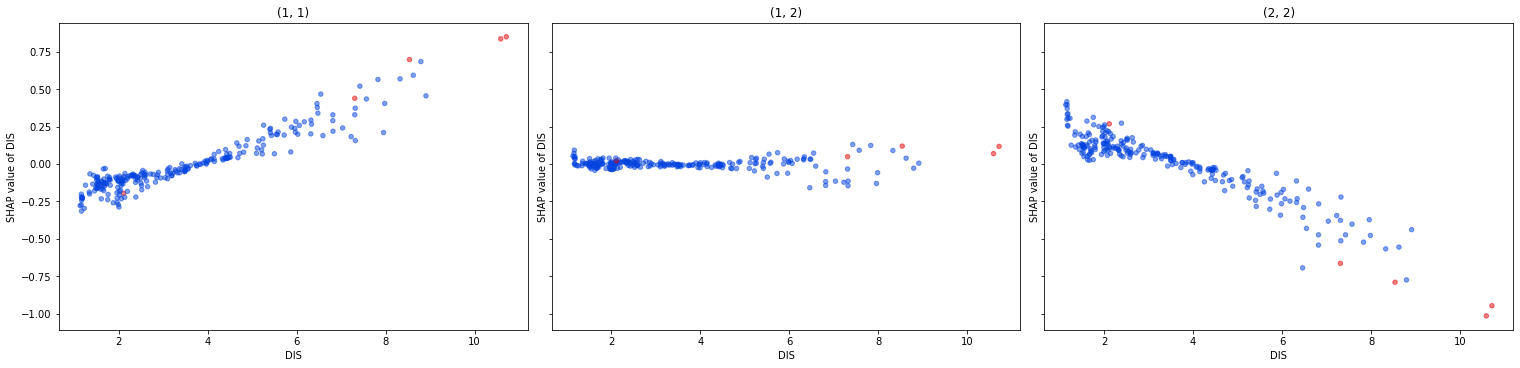

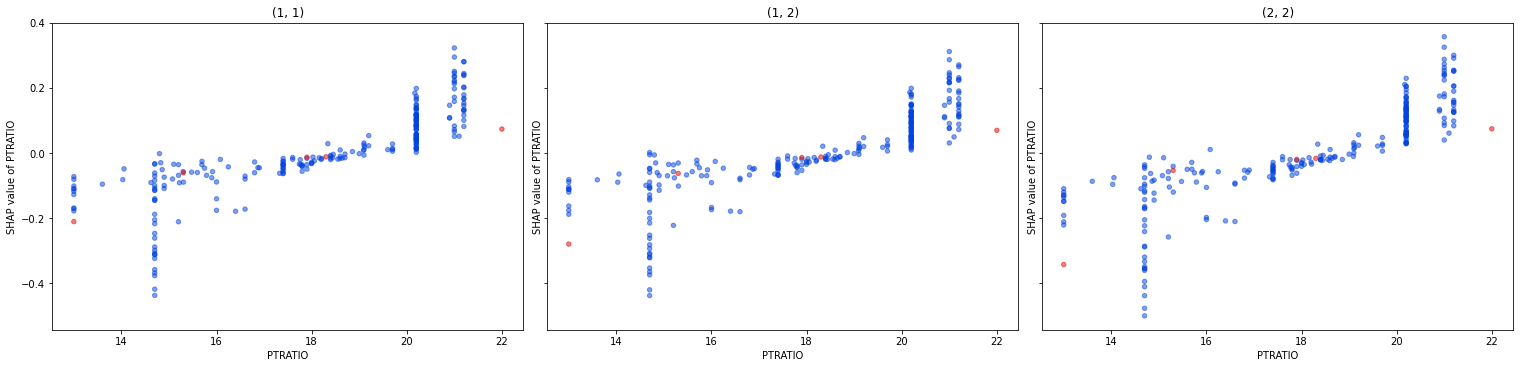

In [180]:
for feature in global_feature_order:
    node.plot_feature(feature, alpha=0.5)

In [181]:
node.describe_feature('LSTAT')

global   local-all  local-diff
count  246.000000  246.000000    5.000000
mean    11.736981   11.736981    6.958448
std      7.372550    7.372550    1.718297
min      1.763949    1.763949    5.490000
25%      5.008267    5.008267    5.570000
50%      9.950000    9.950000    6.360000
75%     17.091674   17.091674    7.850000
max     36.980000   36.980000    9.522242

In [182]:
node.describe_feature('INDUS')

global   local-all  local-diff
count  246.000000  246.000000    5.000000
mean    11.718208   11.718208    2.938000
std      7.290396    7.290396    1.134601
min      1.210000    1.210000    1.690000
25%      4.243588    4.243588    1.910000
50%      9.900000    9.900000    2.970000
75%     18.100000   18.100000    3.970000
max     25.650000   25.650000    4.150000

In [183]:
node.describe_feature('CRIM')

global   local-all  local-diff
count  246.000000  246.000000    5.000000
mean     2.720010    2.720010    0.150718
std      6.388147    6.388147    0.221278
min      0.009060    0.009060    0.009060
25%      0.099321    0.099321    0.018700
50%      0.540032    0.540032    0.079500
75%      3.181873    3.181873    0.106590
max     73.534100   73.534100    0.539742

### Node R

In [184]:
node = node.get_right()

R
(2, 2)    96
(1, 1)    47
(1, 2)     5
(0, 0)     3
(0, 1)     3
(2, 1)     2
dtype: int64


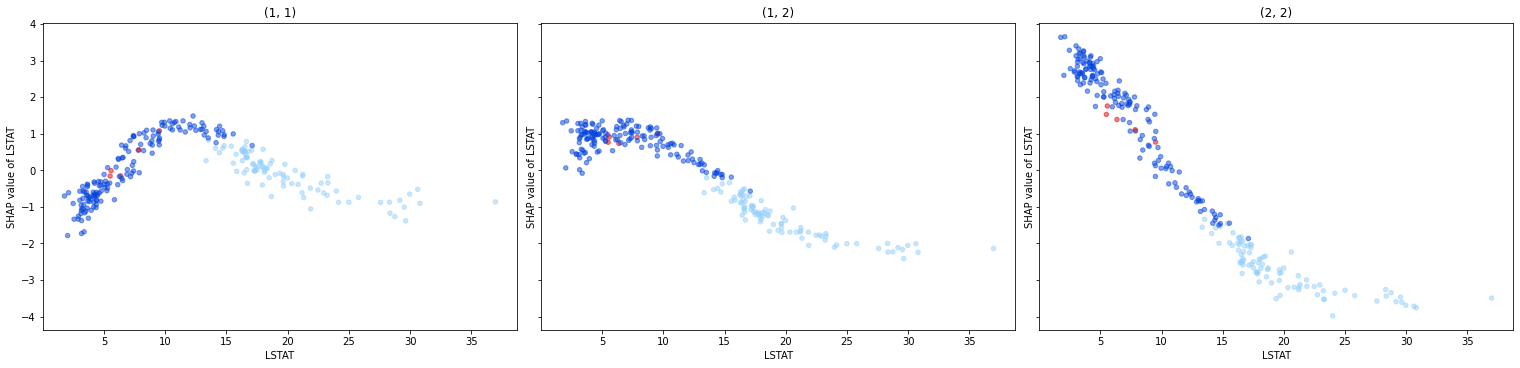

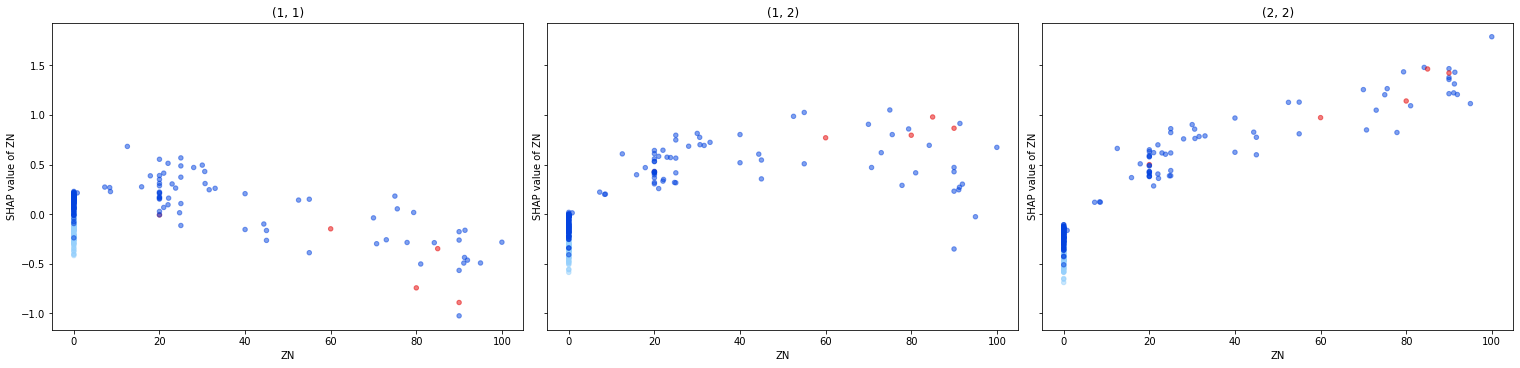

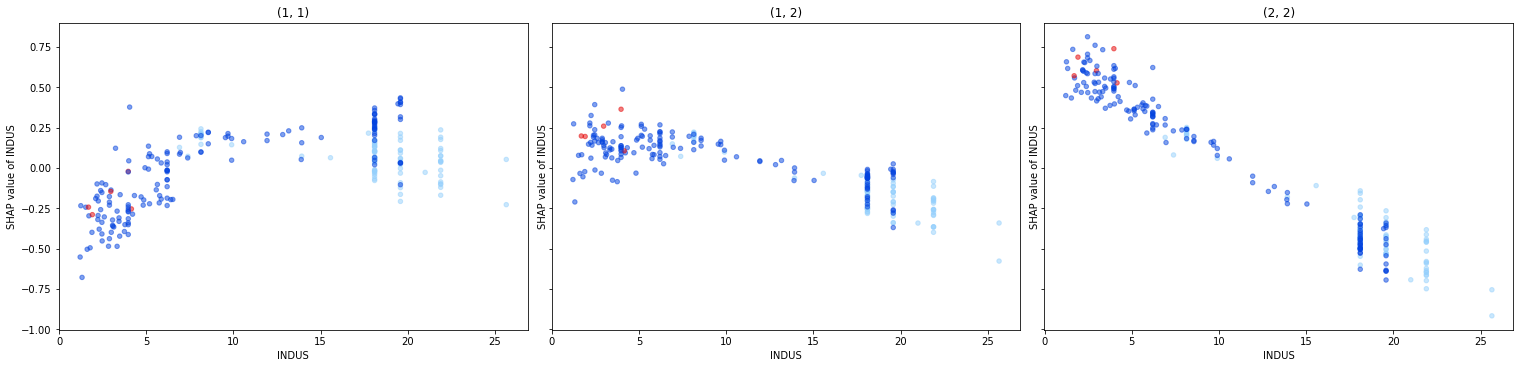

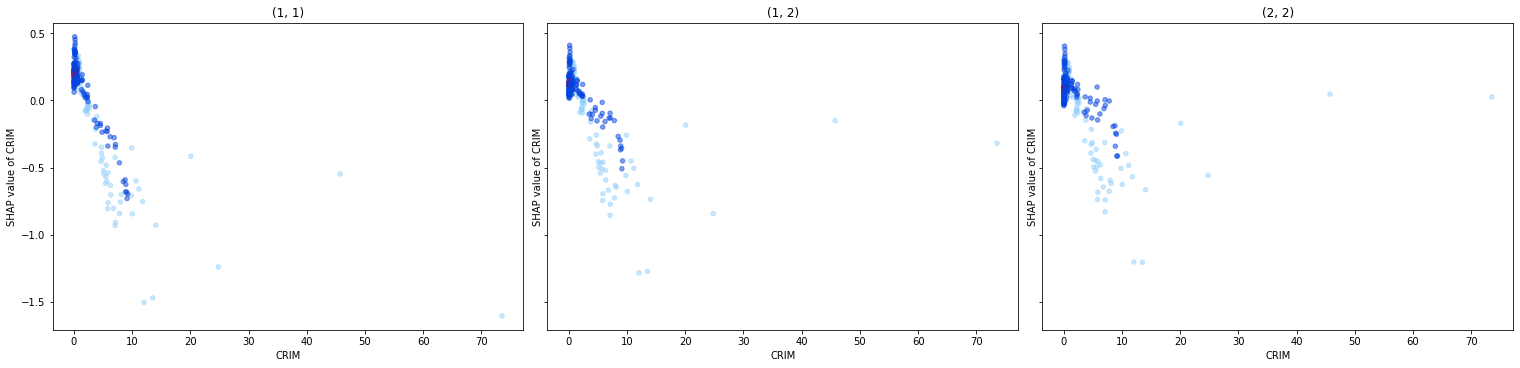

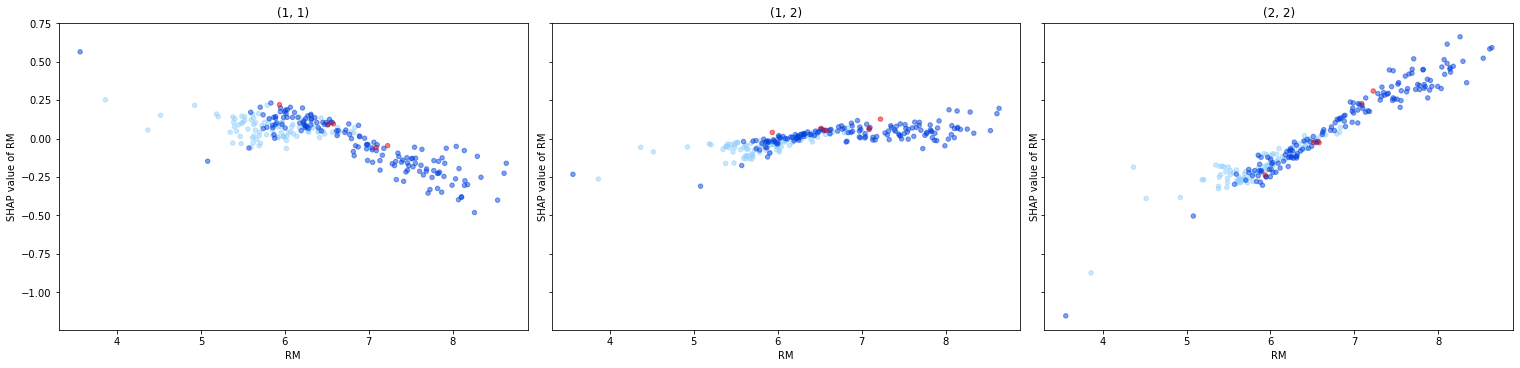

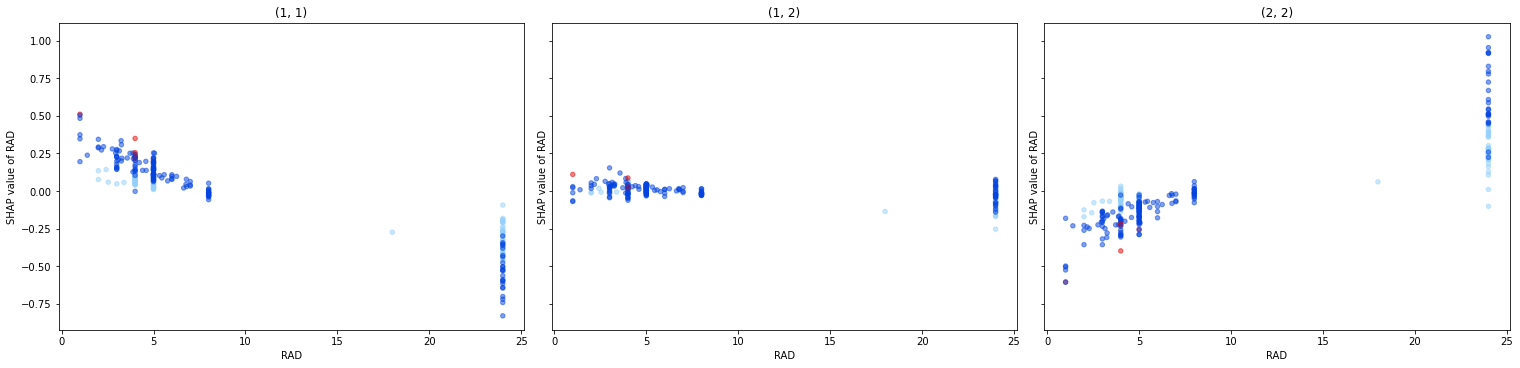

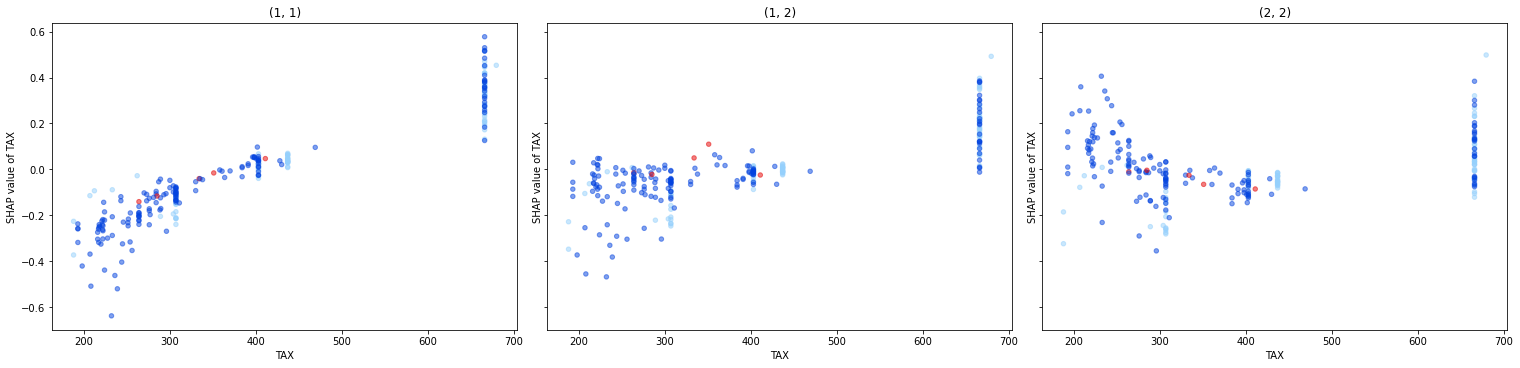

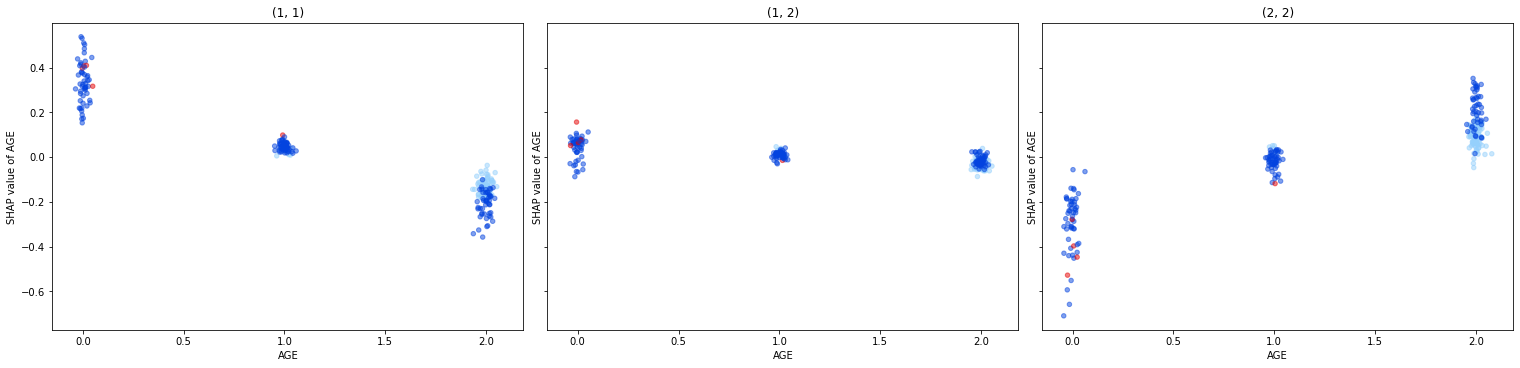

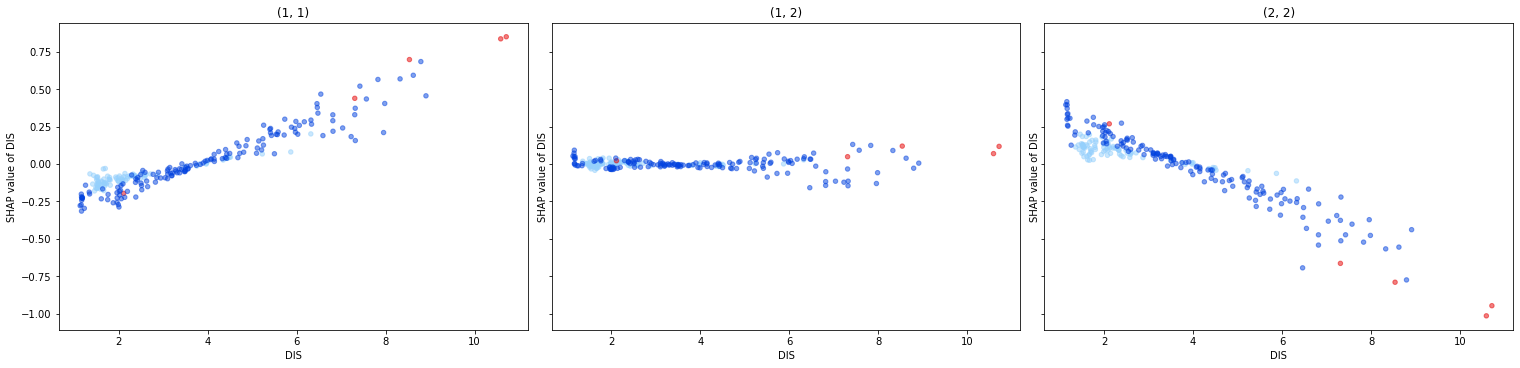

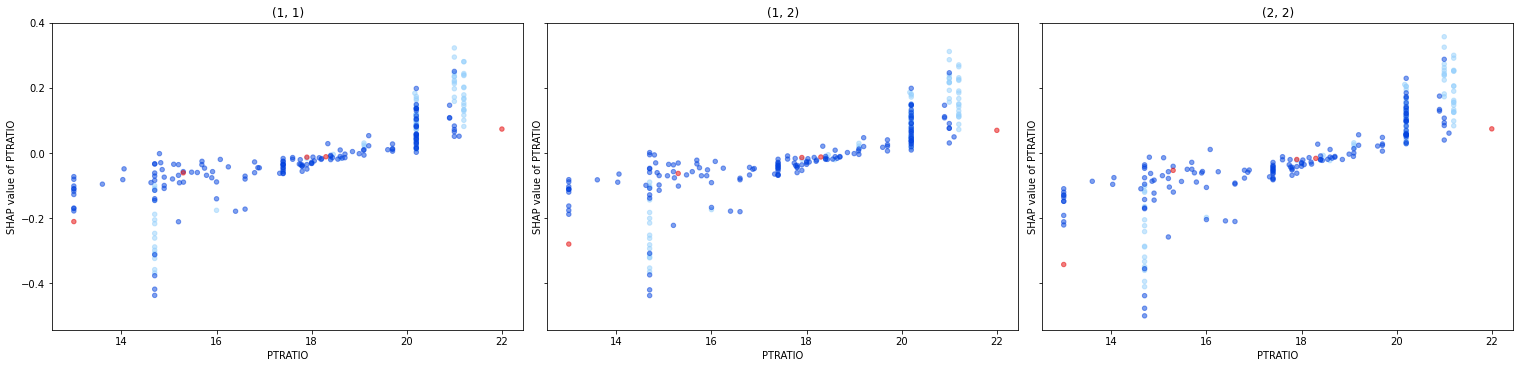

In [185]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, alpha=0.5, focus=node)

In [186]:
node.describe_feature('LSTAT')

global   local-all  local-diff
count  246.000000  156.000000    5.000000
mean    11.736981    7.054840    6.958448
std      7.372550    3.618423    1.718297
min      1.763949    1.763949    5.490000
25%      5.008267    4.103676    5.570000
50%      9.950000    6.301820    6.360000
75%     17.091674    9.502500    7.850000
max     36.980000   17.100000    9.522242

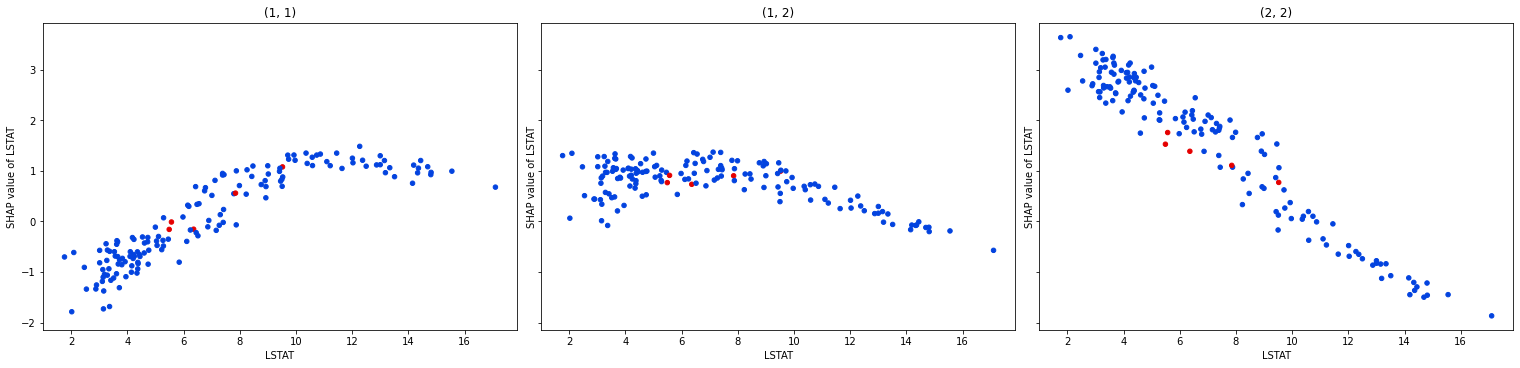

In [187]:
node.plot_feature('LSTAT')

In [188]:
node.test(LSTAT=3.5)

before  after
(1, 2)     5.0    NaN
(2, 2)     NaN    5.0

In [189]:
node.test(LSTAT=11.6)

before  after
(1, 1)     NaN    5.0
(1, 2)     5.0    NaN

In [190]:
node.describe_feature('INDUS')

global   local-all  local-diff
count  246.000000  156.000000    5.000000
mean    11.718208    8.272474    2.938000
std      7.290396    6.291695    1.134601
min      1.210000    1.210000    1.690000
25%      4.243588    3.307500    1.910000
50%      9.900000    5.815645    2.970000
75%     18.100000   13.897500    3.970000
max     25.650000   19.580000    4.150000

In [165]:
node.test(INDUS=17)

before  after
(1, 1)     NaN    5.0
(1, 2)     5.0    NaN

In [177]:
node.test(CRIM=50)

before  after
(0, 0)     NaN    1.0
(1, 0)     NaN    1.0
(1, 2)     5.0    NaN
(2, 2)     NaN    3.0

In [192]:
node.describe_feature('ZN')

global   local-all  local-diff
count  246.000000  156.000000    5.000000
mean    12.841063   20.249368   67.000000
std     25.552540   29.682873   28.635642
min      0.000000    0.000000   20.000000
25%      0.000000    0.000000   60.000000
50%      0.000000    0.000000   80.000000
75%     20.000000   25.000000   85.000000
max    100.000000  100.000000   90.000000

In [197]:
node.test(ZN=16)

before  after
(1, 1)     NaN    5.0
(1, 2)     5.0    NaN

## Clustering of Class $(1,2)$ SHAP Values

In [199]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds, '(2, 1)', ['(1, 1)', '(2, 1)', '(2, 2)'],
                          categorical_features=categorical_features)

root
(2, 2)    96
(0, 0)    86
(1, 1)    52
(1, 2)     5
(0, 1)     3
(1, 0)     2
(2, 1)     2
dtype: int64


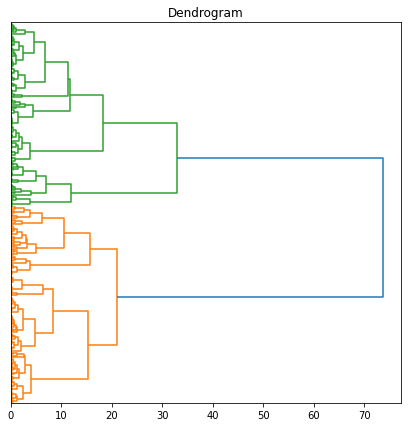

In [200]:
plot_dendrogram(Z)

### Root Node

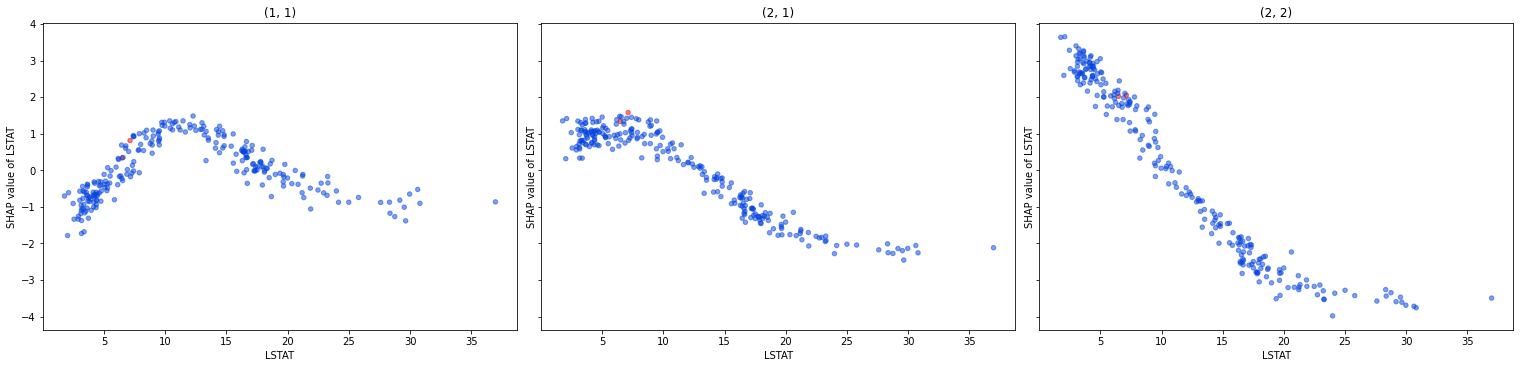

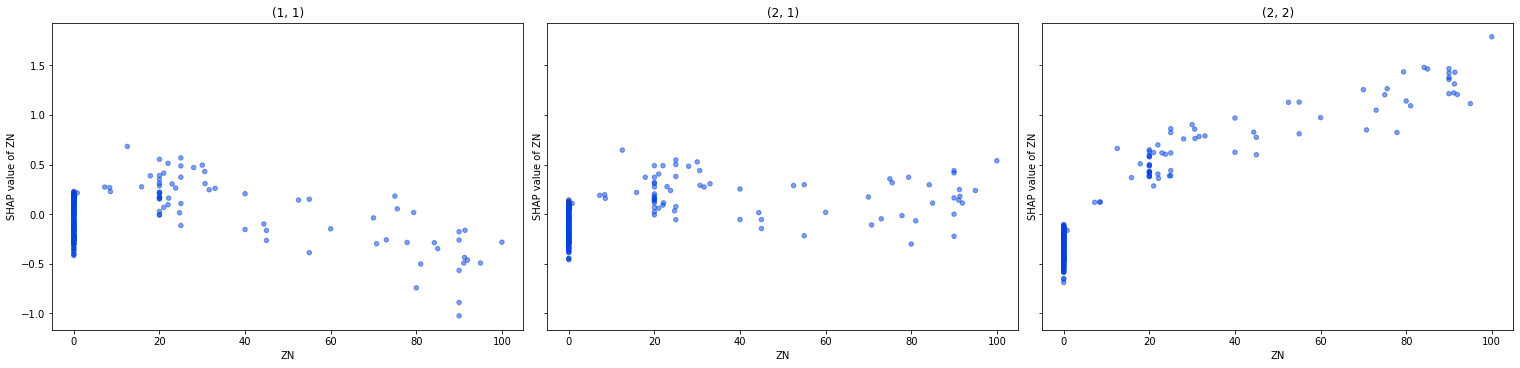

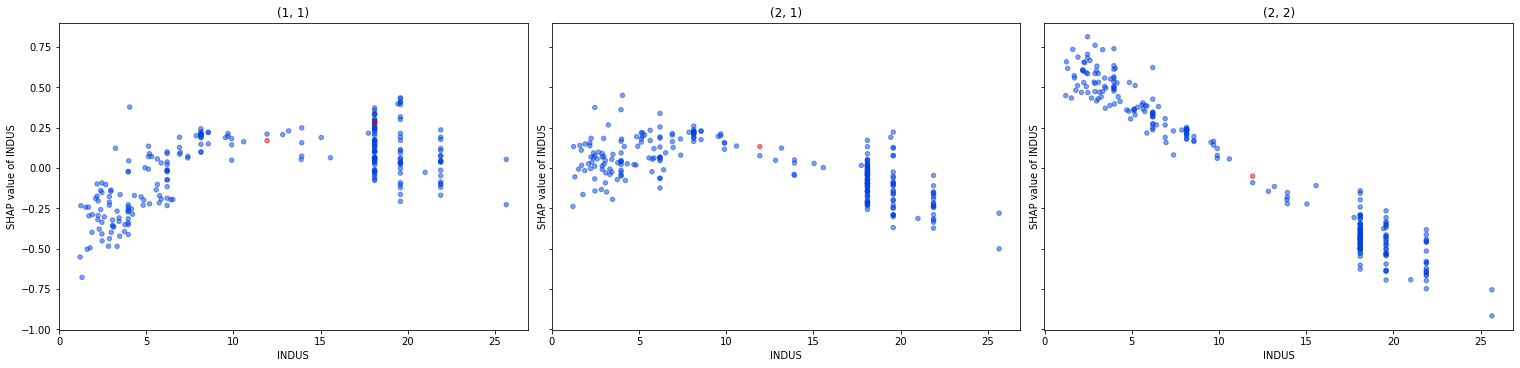

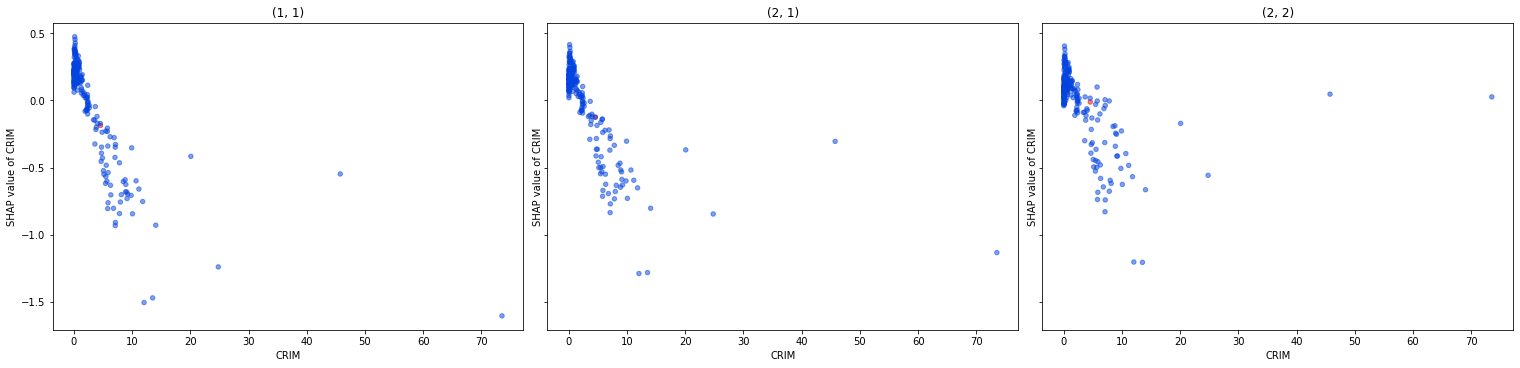

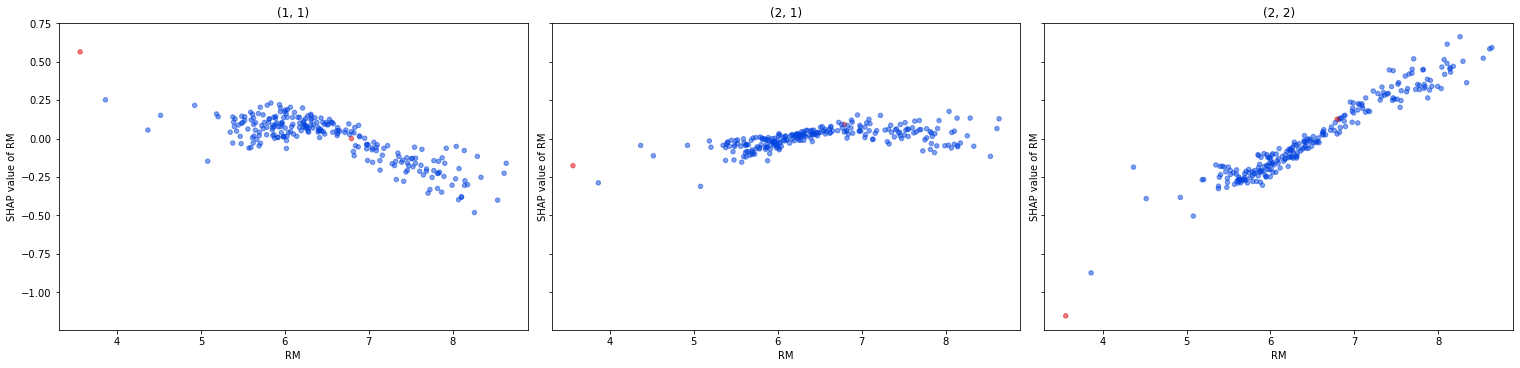

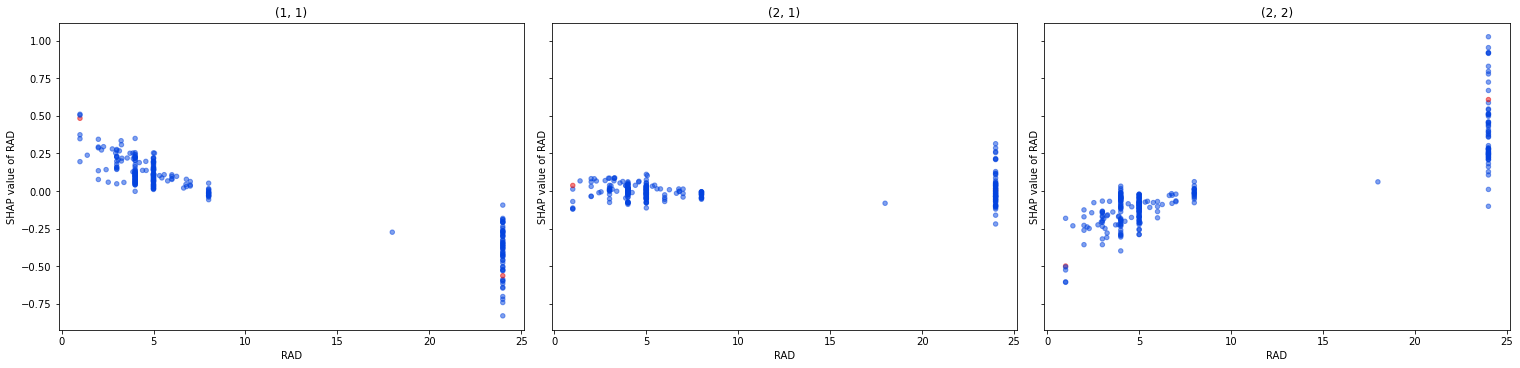

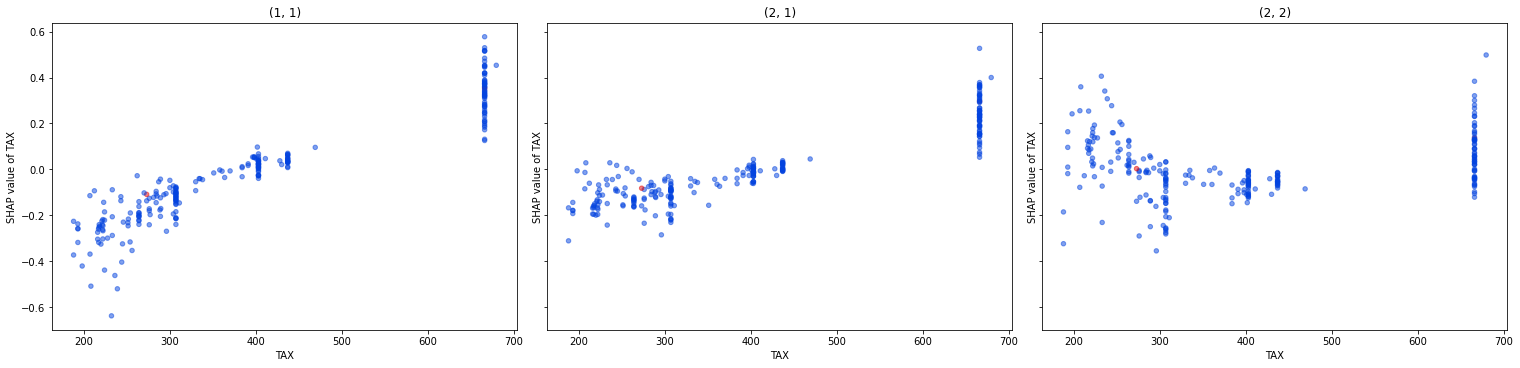

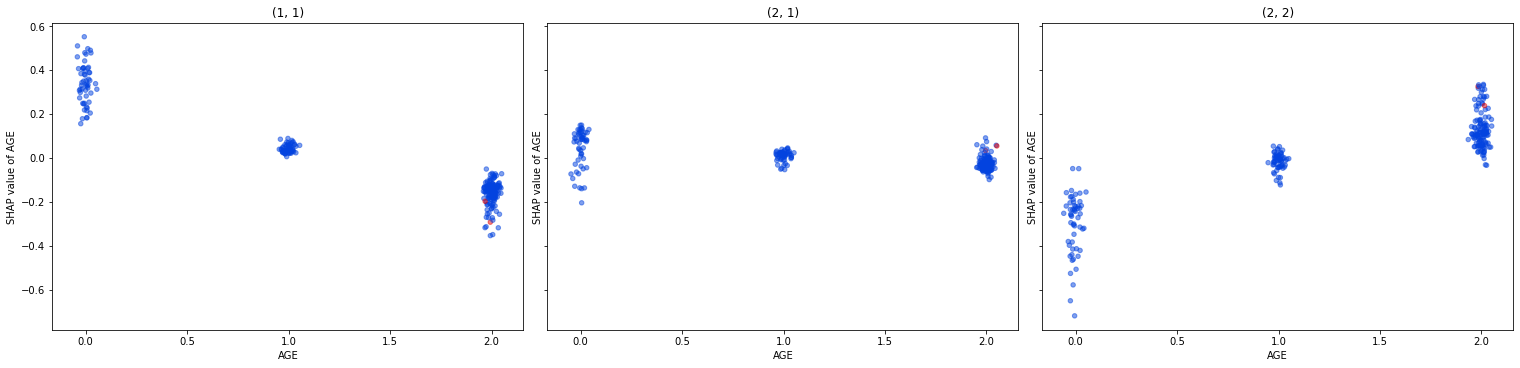

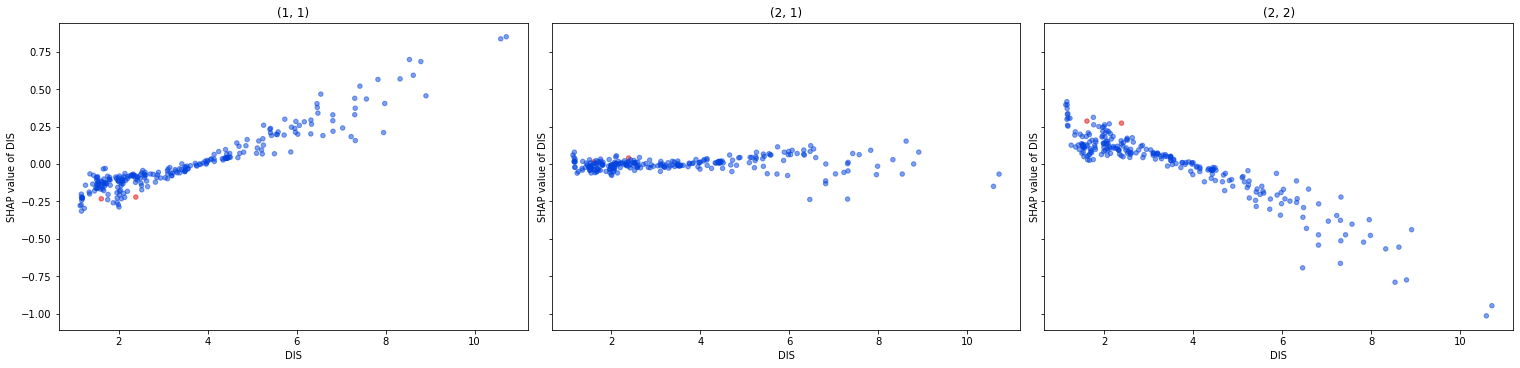

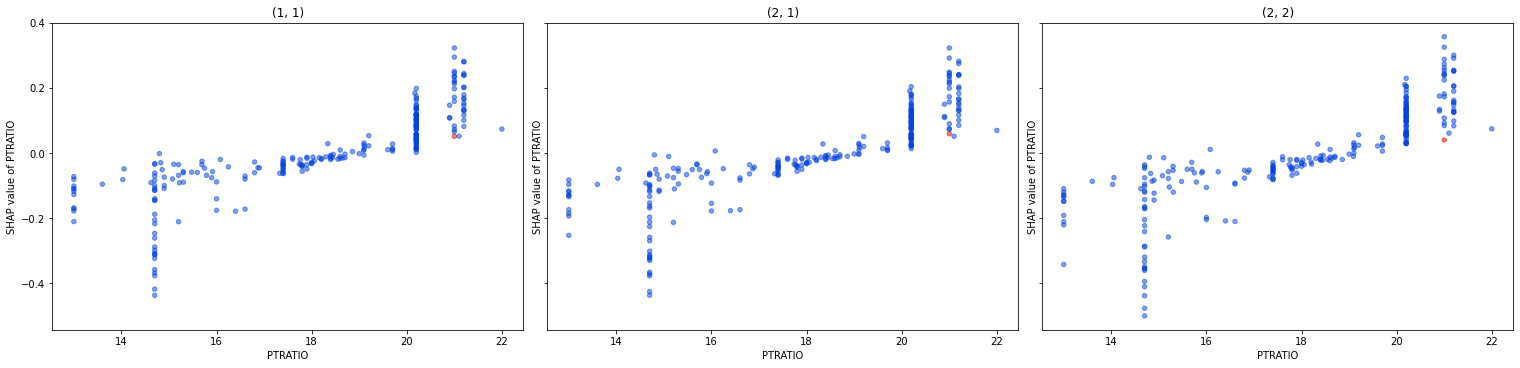

In [201]:
for feature in global_feature_order:
    node.plot_feature(feature, alpha=0.5)

In [202]:
node.describe_feature('LSTAT')

global   local-all  local-diff
count  246.000000  246.000000    2.000000
mean    11.736981   11.736981    6.800000
std      7.372550    7.372550    0.452548
min      1.763949    1.763949    6.480000
25%      5.008267    5.008267    6.640000
50%      9.950000    9.950000    6.800000
75%     17.091674   17.091674    6.960000
max     36.980000   36.980000    7.120000

In [203]:
node.describe_feature('ZN')

global   local-all  local-diff
count  246.000000  246.000000         2.0
mean    12.841063   12.841063         0.0
std     25.552540   25.552540         0.0
min      0.000000    0.000000         0.0
25%      0.000000    0.000000         0.0
50%      0.000000    0.000000         0.0
75%     20.000000   20.000000         0.0
max    100.000000  100.000000         0.0

In [204]:
node.describe_feature('INDUS')

global   local-all  local-diff
count  246.000000  246.000000    2.000000
mean    11.718208   11.718208   15.015000
std      7.290396    7.290396    4.362849
min      1.210000    1.210000   11.930000
25%      4.243588    4.243588   13.472500
50%      9.900000    9.900000   15.015000
75%     18.100000   18.100000   16.557500
max     25.650000   25.650000   18.100000

### Node L

In [206]:
node = node.get_left()

L
(2, 2)    96
(1, 1)    24
(1, 2)     5
(2, 1)     2
dtype: int64


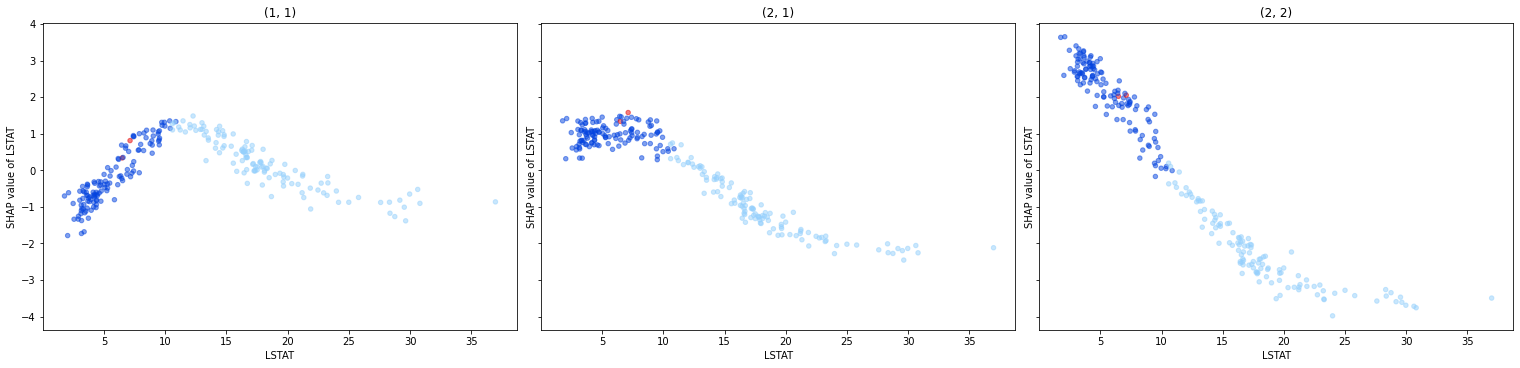

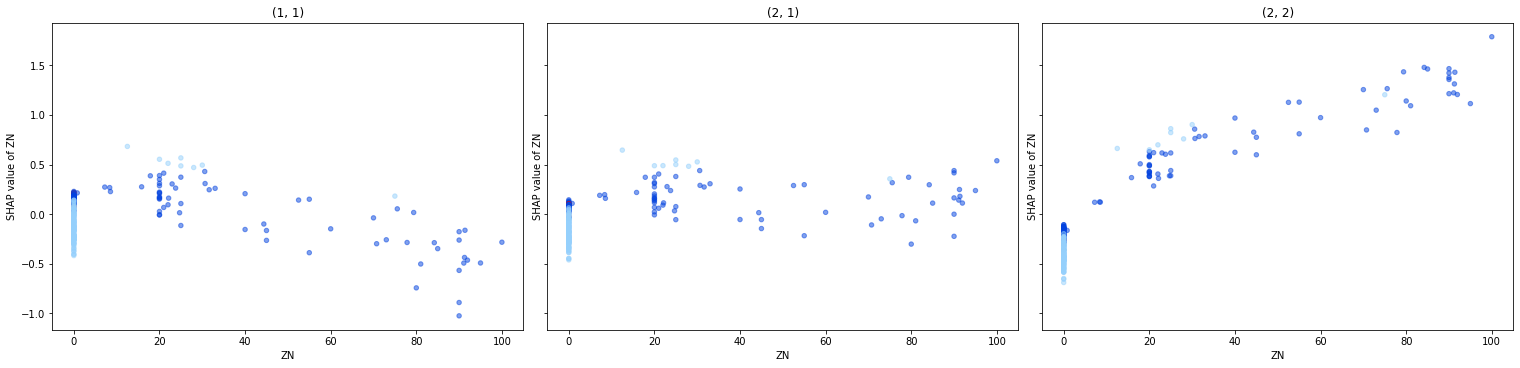

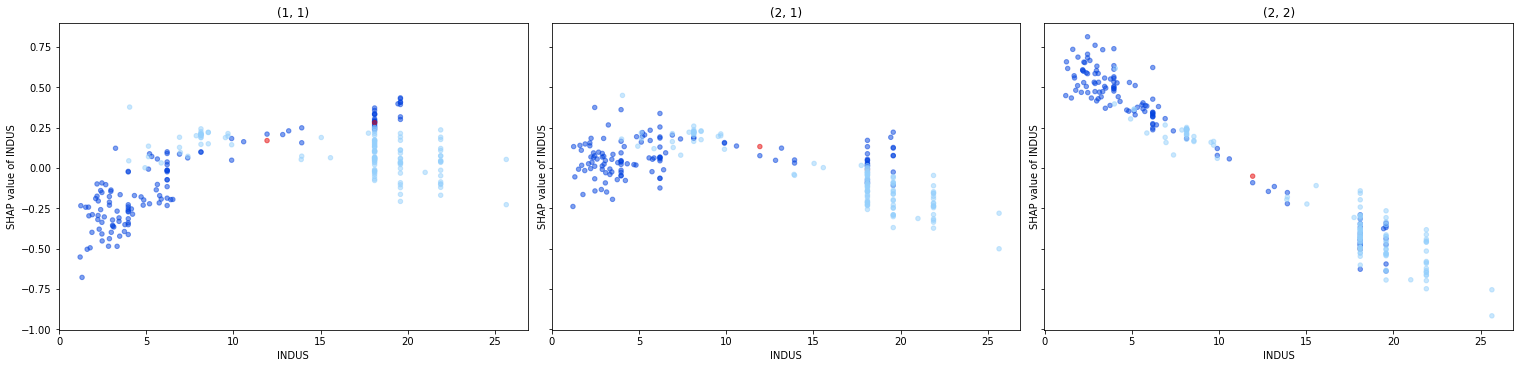

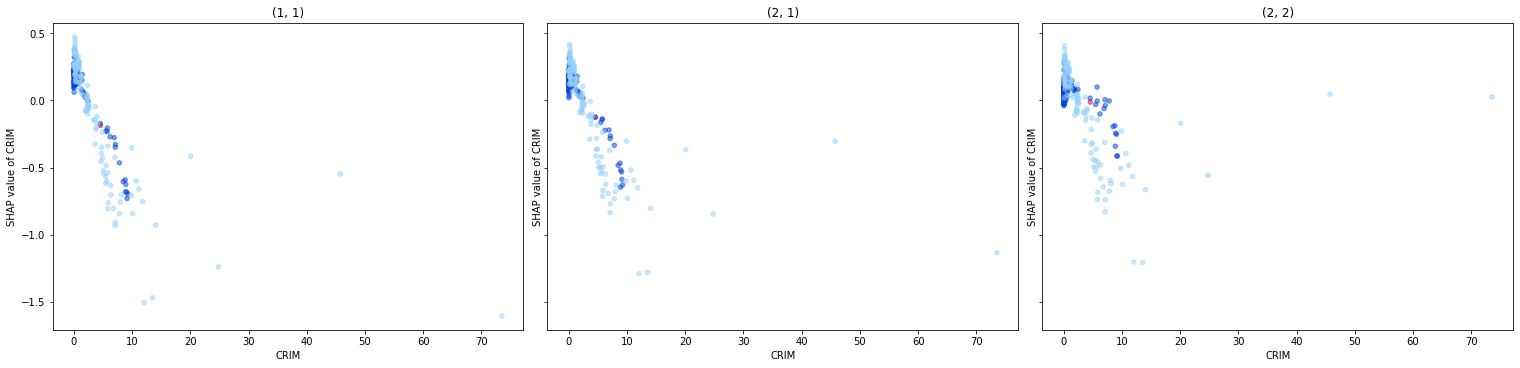

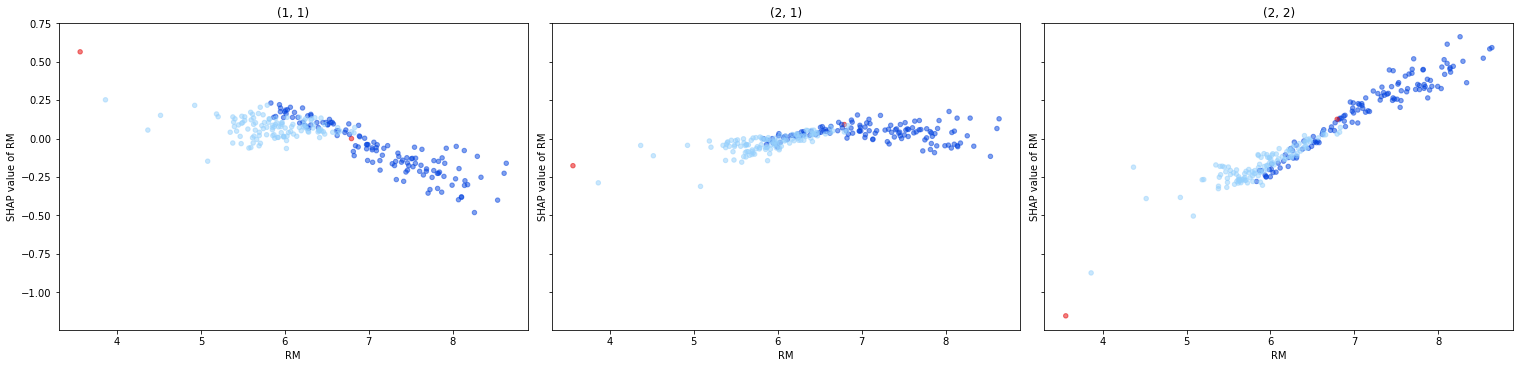

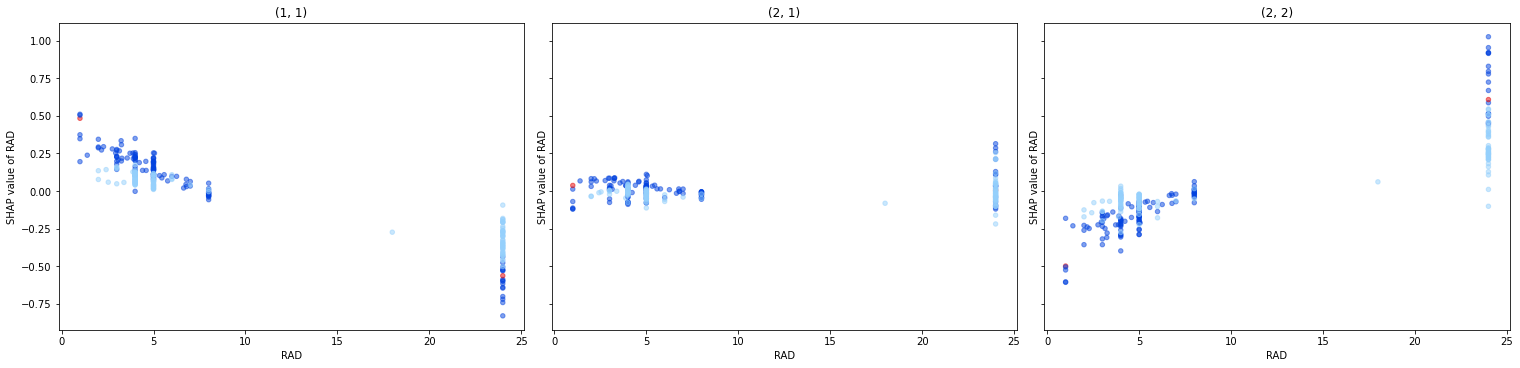

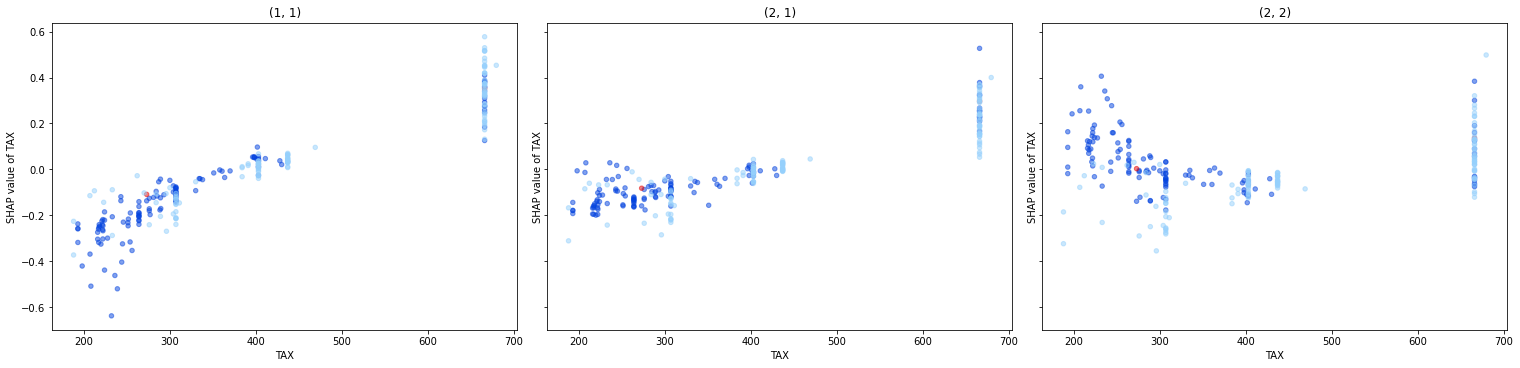

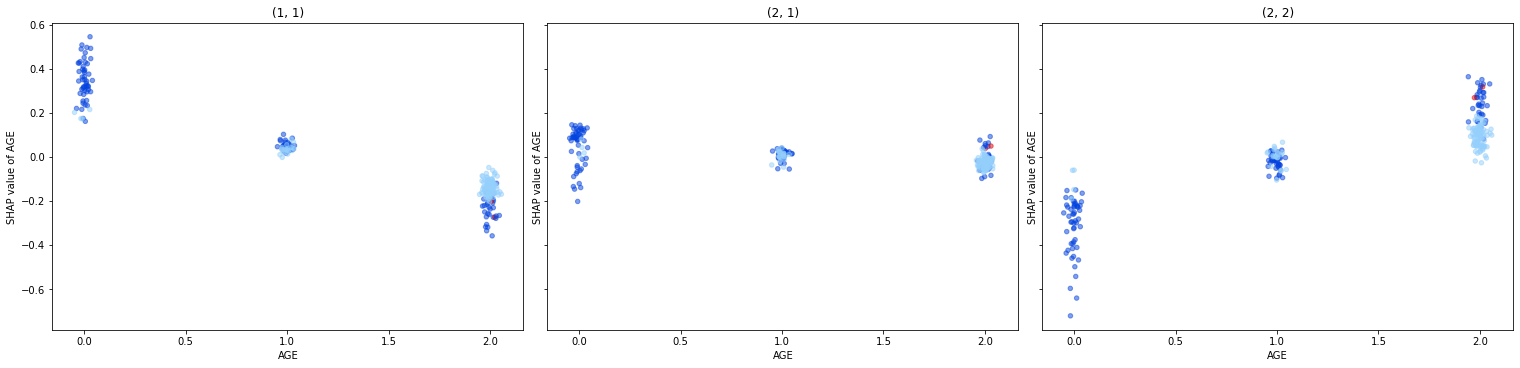

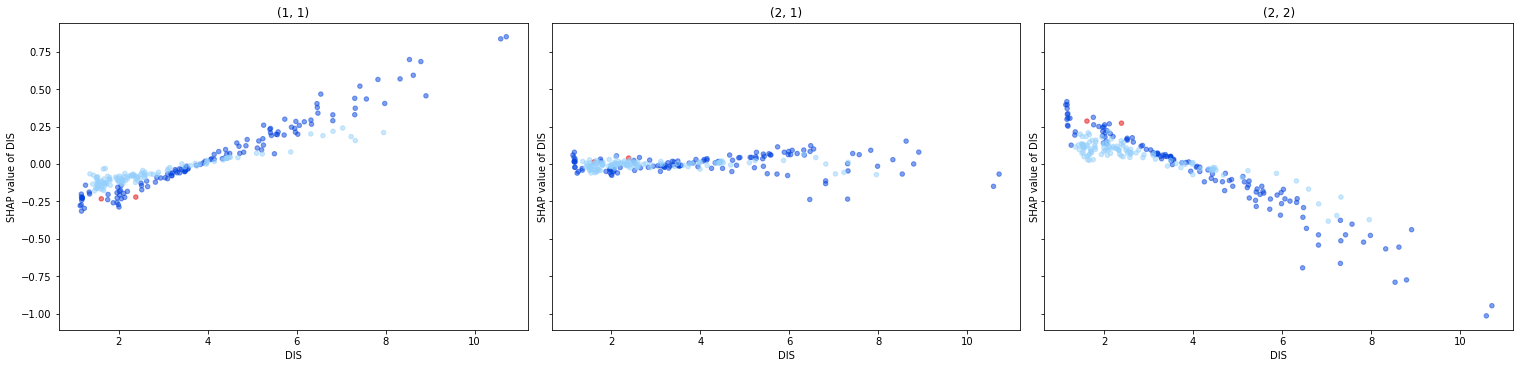

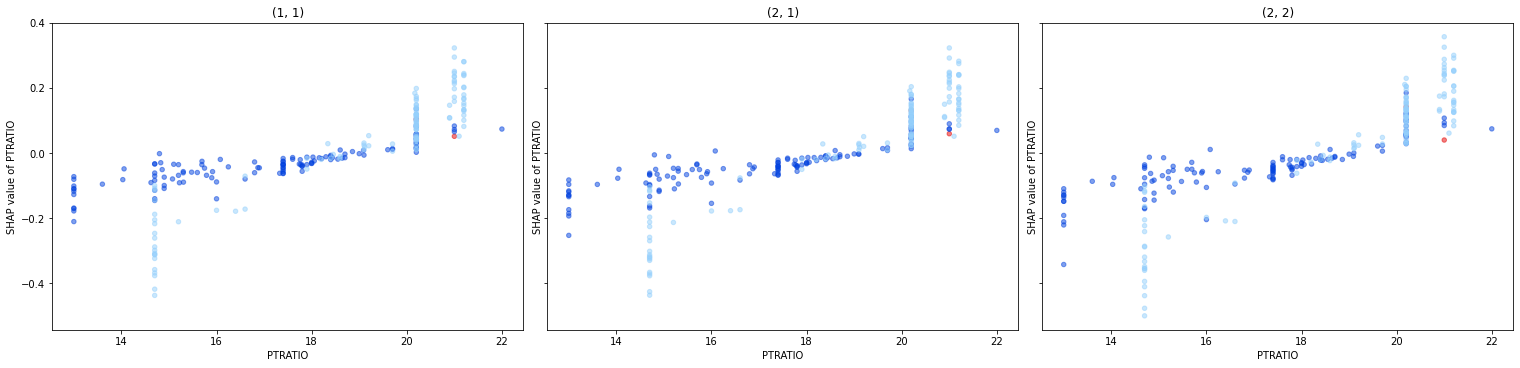

In [207]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, alpha=0.5, focus=node)

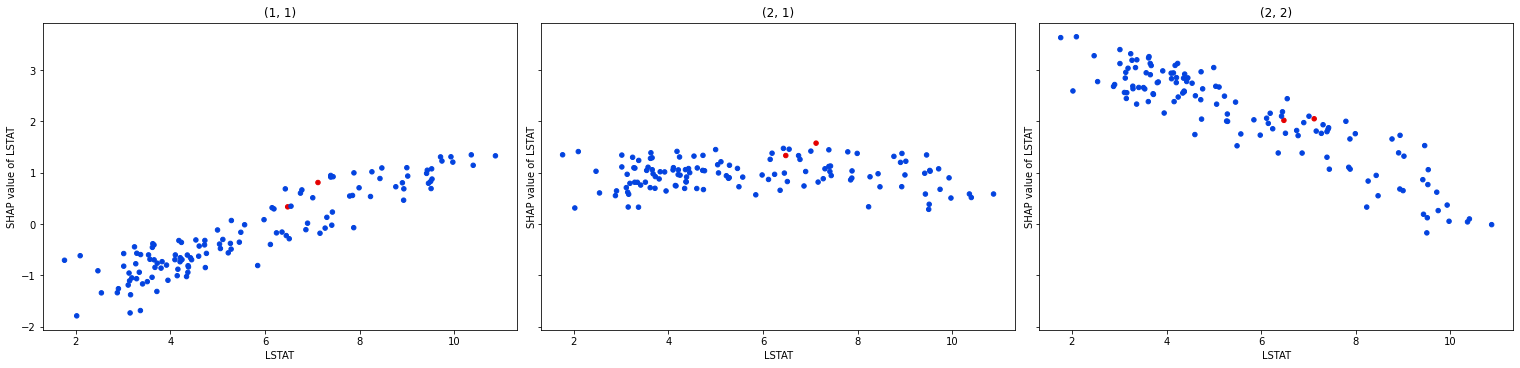

In [208]:
node.plot_feature('LSTAT')

In [219]:
node.describe_feature('LSTAT')

global   local-all  local-diff
count  246.000000  127.000000    2.000000
mean    11.736981    5.681719    6.800000
std      7.372550    2.304218    0.452548
min      1.763949    1.763949    6.480000
25%      5.008267    3.696082    6.640000
50%      9.950000    5.058243    6.800000
75%     17.091674    7.401020    6.960000
max     36.980000   10.870000    7.120000

In [213]:
node.test(LSTAT=6.0)

before  after
(2, 1)     2.0    NaN
(2, 2)     NaN    2.0

In [218]:
node.test(LSTAT=7.5)

before  after
(1, 1)     NaN    2.0
(2, 1)     2.0    NaN

In [226]:
node.test(ZN=19)

before  after
(2, 1)     2.0    NaN
(2, 2)     NaN    2.0

In [234]:
node.test(INDUS=9.8)

before  after
(2, 1)     2.0    NaN
(2, 2)     NaN    2.0

In [240]:
node.test(INDUS=19.7)

before  after
(1, 1)     NaN    2.0
(2, 1)     2.0    NaN